# make_grid:
## Make high res grid, choose either GEBCO_v2023 or bedmachine v3
### Version id:
### bedmachine v3
### v1. completely redoing interpolating and smoothing to reduce halo-ing/fringing high rx1 in cavities
### v1. fixes for pm/pn but and angle calculation
### v2. edge smoothing to increase stability
### v3.  increase northings extent and remake grid.

In [70]:

run ='shackleton'
vers='2km_v3'
plotting = False

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
import xarray as xr
import scipy.io as sio
from scipy.interpolate import griddata
import datetime
import cmocean
# import h5py
import bathy_smoother
# import pyresample


import socket
comp_name = socket.gethostname()
if comp_name=='SEES-3PV4VV3':
    print('running locally')
else:
    os.chdir('/g/data/jk72/deg581/shackleton-setup/notebooks')

#proj_dir = os.path.join(os.pardir,os.pardir)
proj_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(proj_dir,'data')
src_dir = os.path.join(proj_dir,'src')

sys.path.append(src_dir)

from ext.tools.inverse_polar_stereo import inverse_polar_stereo
from ext.tools.cartesian_grid_2d import haversine
from ext.tools.NDinterp import NDinterp
from ext.tools.smoothing_PlusMinus_rx0 import smoothing_PlusMinus_rx0
from ext.tools.smoothing_Laplacian_rx0 import smoothing_Laplacian_rx0
from ext.tools.uvp_masks import uvp_masks



out_path = os.path.join(data_dir,'proc',run+'_'+vers+'_grd.nc')


# define coordinate transforms
## convert convert polarstereo to lat/lon and vice versa.
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")

# load my functions for calculating rx0,rx1 and adjusting the grid
# from ext.tools.calc_z import calc_z as calc_z_old
from functions import GridStiffness
from functions.GridAdjustments import adjustWCT,adjustMask,smoothRegion,minWCTRegion

# Set model vertical coordinate settings

# N=31
# Vtransform=2
# Vstretching=4
# theta_s=1
# theta_b=4
# Tcline=250
# hc=Tcline # if Vtransform==2, hc=Tcline


N=31
Vtransform=2
Vstretching=4
theta_s=0.8
theta_b=3
Tcline=250
hc=Tcline # if Vtransform==2, hc=Tcline


running locally


In [2]:

def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)



import ipywidgets as widgets
from IPython.display import display
# Global variables to store clicked points and the connection ID
clicked_points = []
cid = None  # Callback connection ID
fig, ax = None, None  # Figure and axes objects
line = None  # Line object for dynamic updates

def interactive_plot_and_select_points():
    """
    Sets up the interactive plot for selecting points.
    Initializes global variables and the callback connection.
    """
    global clicked_points, cid, fig, ax, line
    clicked_points = []  # Reset the points list
    
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(15,12))
    line, = ax.plot([], [], 'r-', label='Clicked Path')  # Initialize an empty red line
    ax.legend()
    ax.set_title("Click on the plot to create a connected path")

    # Define a callback function to record clicks and update the line
    def on_click(event):
        if event.inaxes == ax:  # Ensure the click is on the plot axes
            clicked_points.append((event.xdata, event.ydata))
            print(f"Point added: ({event.xdata:.2f}, {event.ydata:.2f})")
            # Update the line dynamically
            x_vals, y_vals = zip(*clicked_points)
            line.set_data(x_vals, y_vals)
            fig.canvas.draw()

    # Connect the click event to the callback
    cid = fig.canvas.mpl_connect('button_press_event', on_click)

    print("Interactive plot setup complete. Click to select points.")
    
    # Add an "Finish Selection" button using ipywidgets
    finish_button = widgets.Button(description="Finish Selection")
    finish_button.on_click(on_finish)
    
    # Display the button below the plot
    display(finish_button)

    # This ensures the interactive plot is shown and stays active in the notebook
    plt.show()

def on_finish(event):
    """
    Handle button click event to finalize the selection and print the clicked points.
    """
    global clicked_points
    # Convert clicked points to NumPy array and return
    points_array = np.array(clicked_points)
    # Print the points in a format that's easy to copy into a numpy array
    print("Selection finished. Final clicked points as array:")
    
    # Format the output for easy copying
    formatted_points = ",\n ".join([f"({x:.9f}, {y:.9f})" for x, y in clicked_points])
    print(f"np.array([\n {formatted_points}\n])")
    
    plt.close(fig)  # Close the plot after finishing


# define inpaint_nans
from scipy.signal import convolve2d
def inpaint_nans(inField):
    im = inField.copy()
    import scipy
    ipn_kernel = np.array([[1,1,1],[1,0,1],[1,1,1]]) # kernel for inpaint_nans
    nans = np.isnan(im)
    while np.sum(nans)>0:
        im[nans] = 0
        vNeighbors = convolve2d((nans==False),ipn_kernel,mode='same',boundary='symm')
        im2 = convolve2d(im,ipn_kernel,mode='same',boundary='symm')
        im2[vNeighbors>0] = im2[vNeighbors>0]/vNeighbors[vNeighbors>0]
        im2[vNeighbors==0] = np.nan
        im2[(nans==False)] = im[(nans==False)]
        im = im2
        nans = np.isnan(im)
    return im


In [3]:
mr = 2
grid_xLims= (2475,3065) #km
grid_yLims= (-750,-130) #km
#establish the grid with grid point distances of mr/2 in km
#we need double resolution to cover all of the staggered grid points (we subset to rho, psi, u, v points later)
#we need an extra line of u and v points at first to calculate all dx and dy on rho points
x,y = np.meshgrid(np.arange(grid_xLims[0],grid_xLims[1]+mr/2,mr/2),np.arange(grid_yLims[0],grid_yLims[1]+mr/2,mr/2))
x_rho = x[1::2,1::2]
y_rho = y[1::2,1::2]

print('x_rho size is: ',x_rho.shape)

x_rho size is:  (310, 295)


In [4]:
GeoGrid=False
if GeoGrid:
    print('making grid points with geographic coordinates')
    res = 1/40
    xc = (94.5,105)
    yc = (-66.8,-63)
    
    Lats = np.arange(yc[0],yc[1]+res/2,res/2)
    Lons = np.arange(xc[0],xc[1]+res/2,res/2)
    
    lat,lon = np.meshgrid(Lats,Lons)
    
    lonr_to_x,latr_to_y = ll_to_ps.transform(lat,lon)
    
    x_rho = lonr_to_x/1000
    y_rho = latr_to_y/1000
    
    print('x_rho size is (note possibly divide by 2): ',x_rho.shape)
    print('x_rho min/max: ',x_rho.min(),' ',x_rho.max())
    print('y_rho min/max: ',y_rho.min(),' ',y_rho.max())
    dx = haversine(lon[1::2,0:-2:2],lat[1::2,0:-2:2],lon[1::2,2::2],lat[1::2,2::2])
    dy = haversine(lon[0:-2:2,1::2],lat[0:-2:2,1::2],lon[2::2,1::2],lat[2::2,1::2])

    print('min dx/dy: ',dx.min(),' ',dy.min())


quick plot of extents


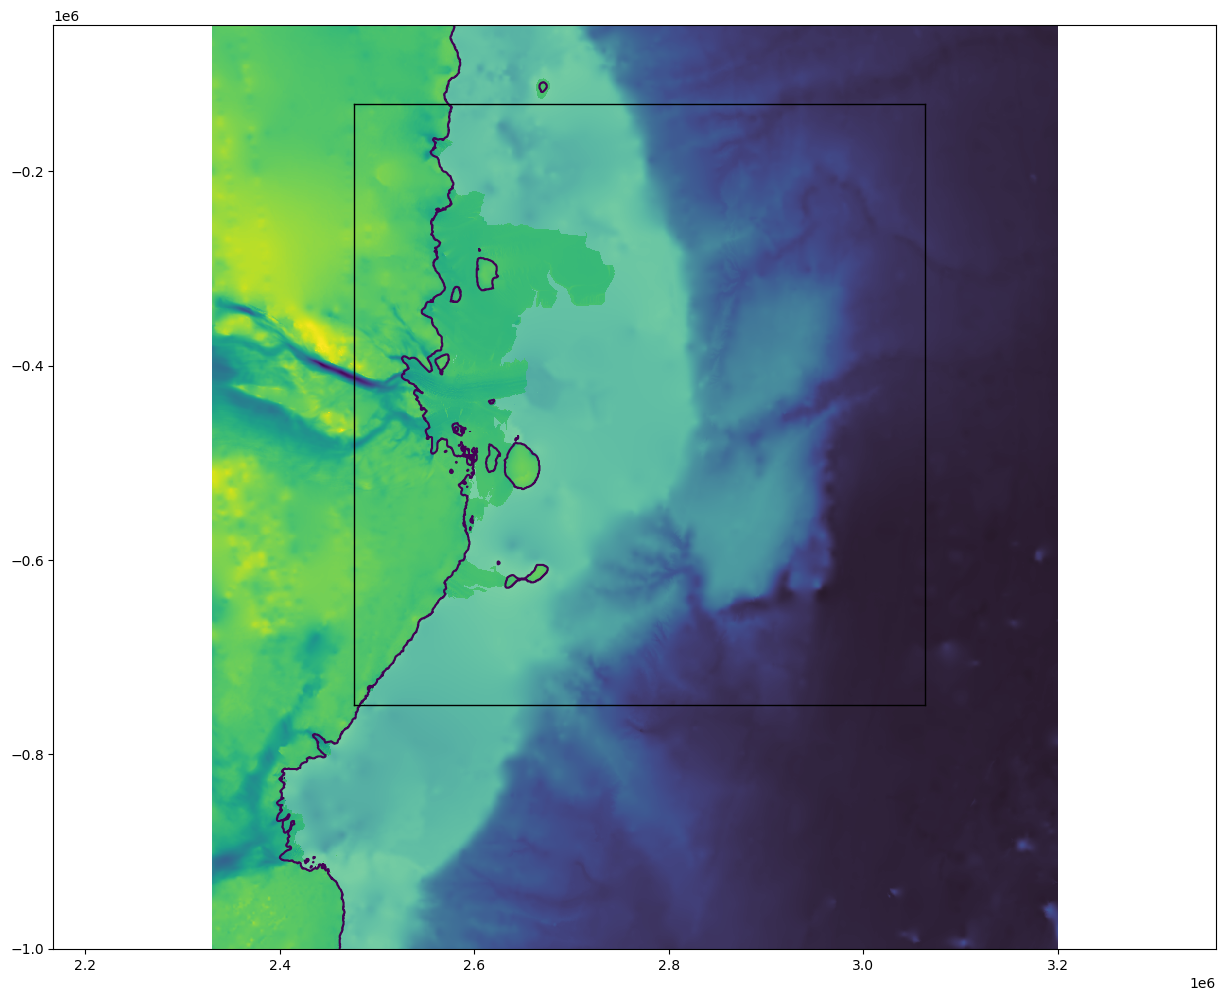

In [5]:
#load BM3 geometry
bedmachine_v3_path = os.path.join(data_dir,'raw','BedMachineAntarctica-v3','BedMachineAntarctica-v3.nc')

bm3_raw = xr.load_dataset(bedmachine_v3_path)

#subset bedmachine dataset
bm3=bm3_raw.sel(x=slice(2.33e6,3.2e6)).sel(y=slice(-.05e6,-1e6)) # note reversed y coord

# make XX and YY coordinates
X,Y = np.meshgrid(bm3.x,bm3.y)
bm3 = bm3.assign_coords({"X": (("y", "x"), X), "Y": (("y", "x"), Y)})

bm3_lat,bm3_lon = ps_to_ll.transform(bm3.X,bm3.Y)
bm3 = bm3.assign_coords({"lon": (("y", "x"), bm3_lon), "lat": (("y", "x"), bm3_lat)})

# make 'draft' abd 'bathy' variables
bm3["draft"]=-(bm3.thickness-bm3.surface) #draft is negative
bm3["bathy"]=-bm3.bed # bathy is postive



geom = bm3
# make masks
geom['mask_full']=bm3.mask
geom["mask_ice"]=np.isfinite(geom.mask_full.where(geom.mask_full==3,np.NaN))
geom["mask_ocean"]=np.isfinite(geom.mask_full.where((geom.mask_full==0)|(geom.mask_full==3),np.NaN))

%matplotlib inline
print('quick plot of extents')
plt.close('all')
masked_ice = geom.draft.where(geom.draft!=0,np.NaN).copy()
plt.figure(figsize=(15,12))
plt.pcolormesh(geom.X,geom.Y,geom.bathy,cmap='cmo.deep')
plt.pcolormesh(geom.X,geom.Y,masked_ice)

plt.contour(geom.X,geom.Y,geom.draft+geom.bathy,levels=0)
# plt.plot(x_rho*1000,y_rho*1000,'ko',markersize=1,alpha=0.02,mec=None)
plt.plot(x_rho[0,:]*1000,y_rho[0,:]*1000,'k',linewidth=1)
plt.plot(x_rho[-1,:]*1000,y_rho[-1,:]*1000,'k',linewidth=1)
plt.plot(x_rho[:,0]*1000,y_rho[:,0]*1000,'k',linewidth=1)
plt.plot(x_rho[:,-1]*1000,y_rho[:,-1]*1000,'k',linewidth=1)
plt.axis('equal')
plt.show()


<Figure size 640x480 with 0 Axes>

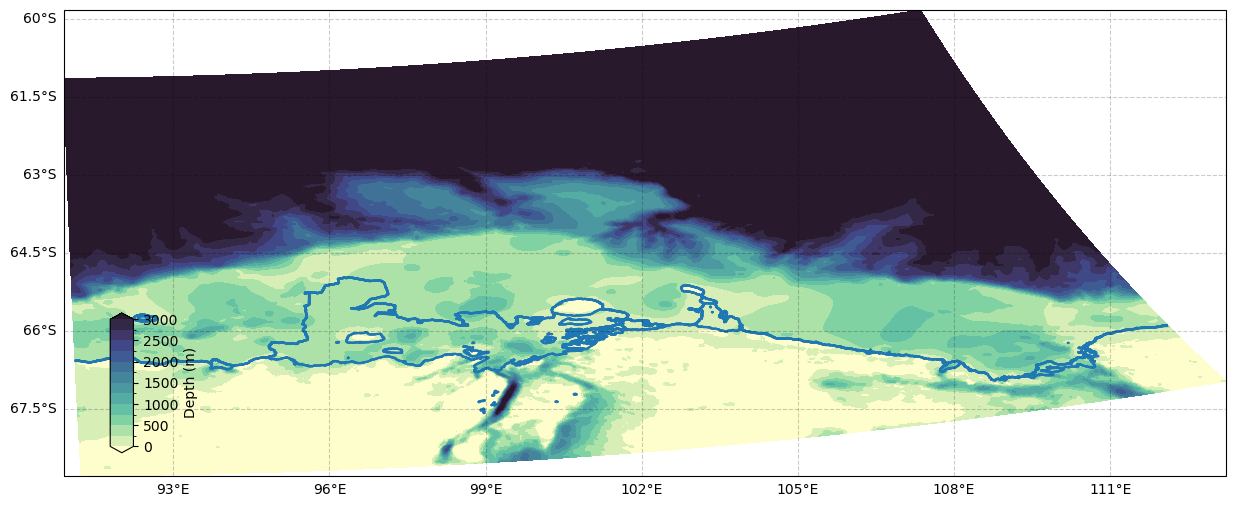

In [6]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# ax.set_extent([64, 80, -75, -62])

#add data
im = (geom['bathy']).plot.contourf(x='lon',y='lat',cmap='cmo.deep',levels=np.array([*np.arange(00,3250,250)]),add_colorbar=False)
co=plt.contour(bm3.lon,bm3.lat,bm3.mask,colors='C0')

#add colourbar
cax = inset_axes(ax,
                width="2%",  # width = 10% of parent_bbox width
                height="30%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax = plt.gca()

plt.show()


<Figure size 640x480 with 0 Axes>

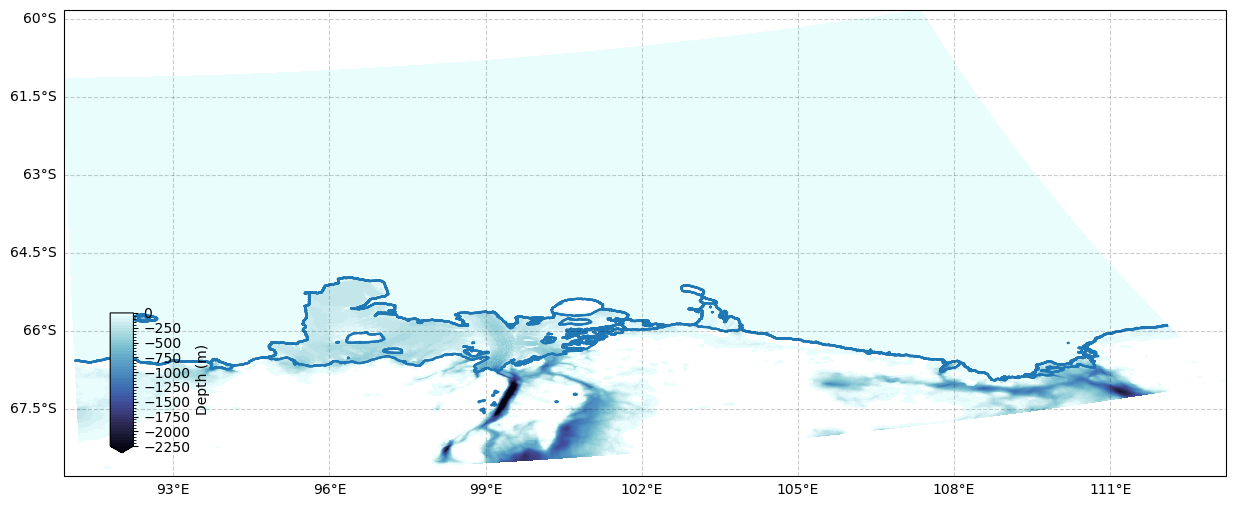

In [7]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# ax.set_extent([64, 80, -75, -62])

#add data
im = (geom.draft).plot.contourf(x='lon',y='lat',cmap='cmo.ice',levels=np.array([*np.arange(-2250,50,50)]),add_colorbar=False,extend='min')
co=plt.contour(bm3.lon,bm3.lat,bm3.mask,colors='C0')

#add colourbar
cax = inset_axes(ax,
                width="2%",  # width = 10% of parent_bbox width
                height="30%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax = plt.gca()

plt.show()


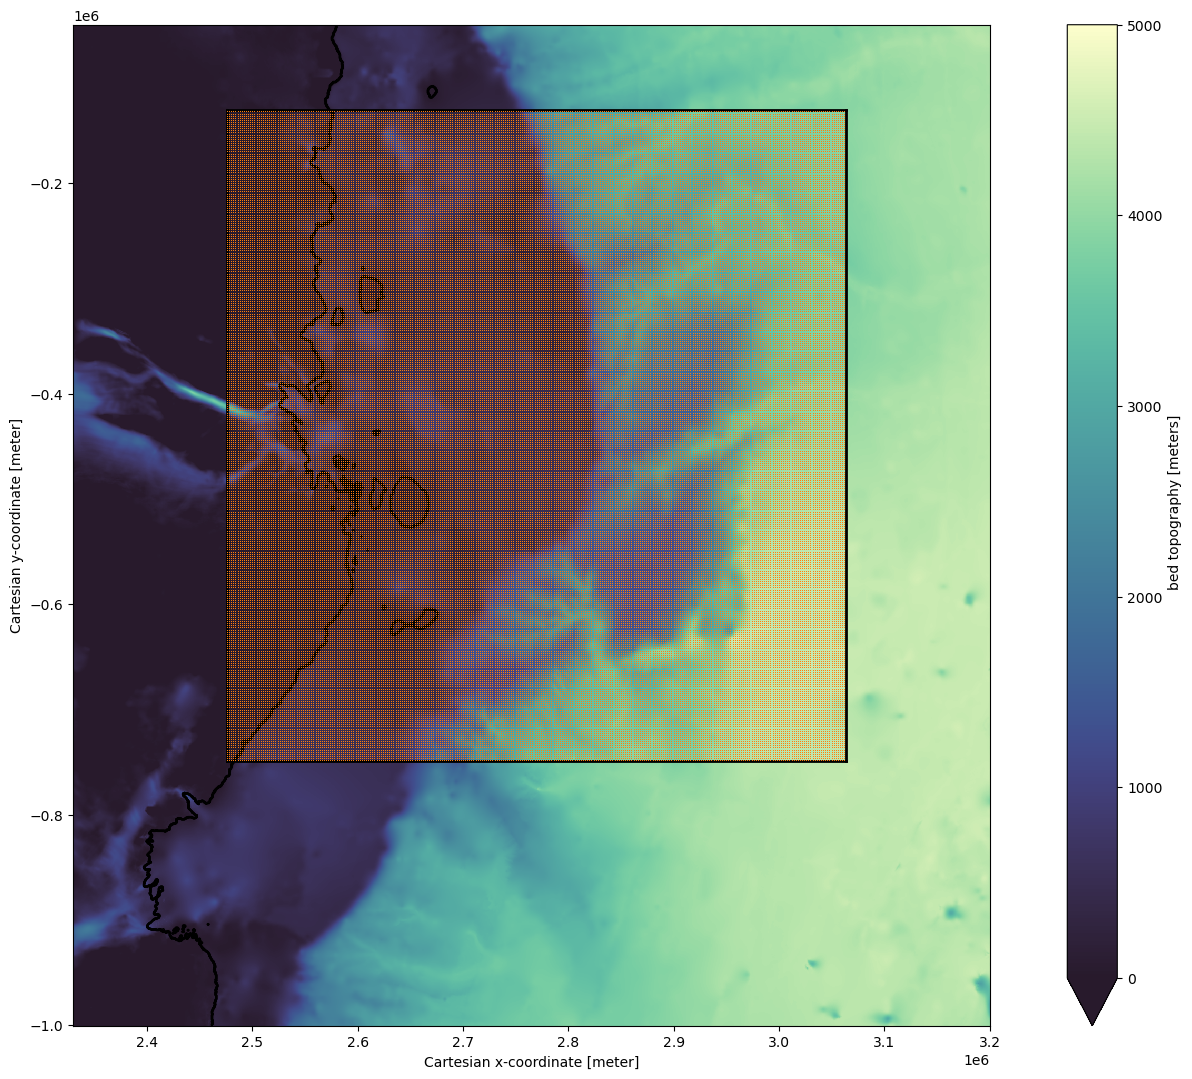

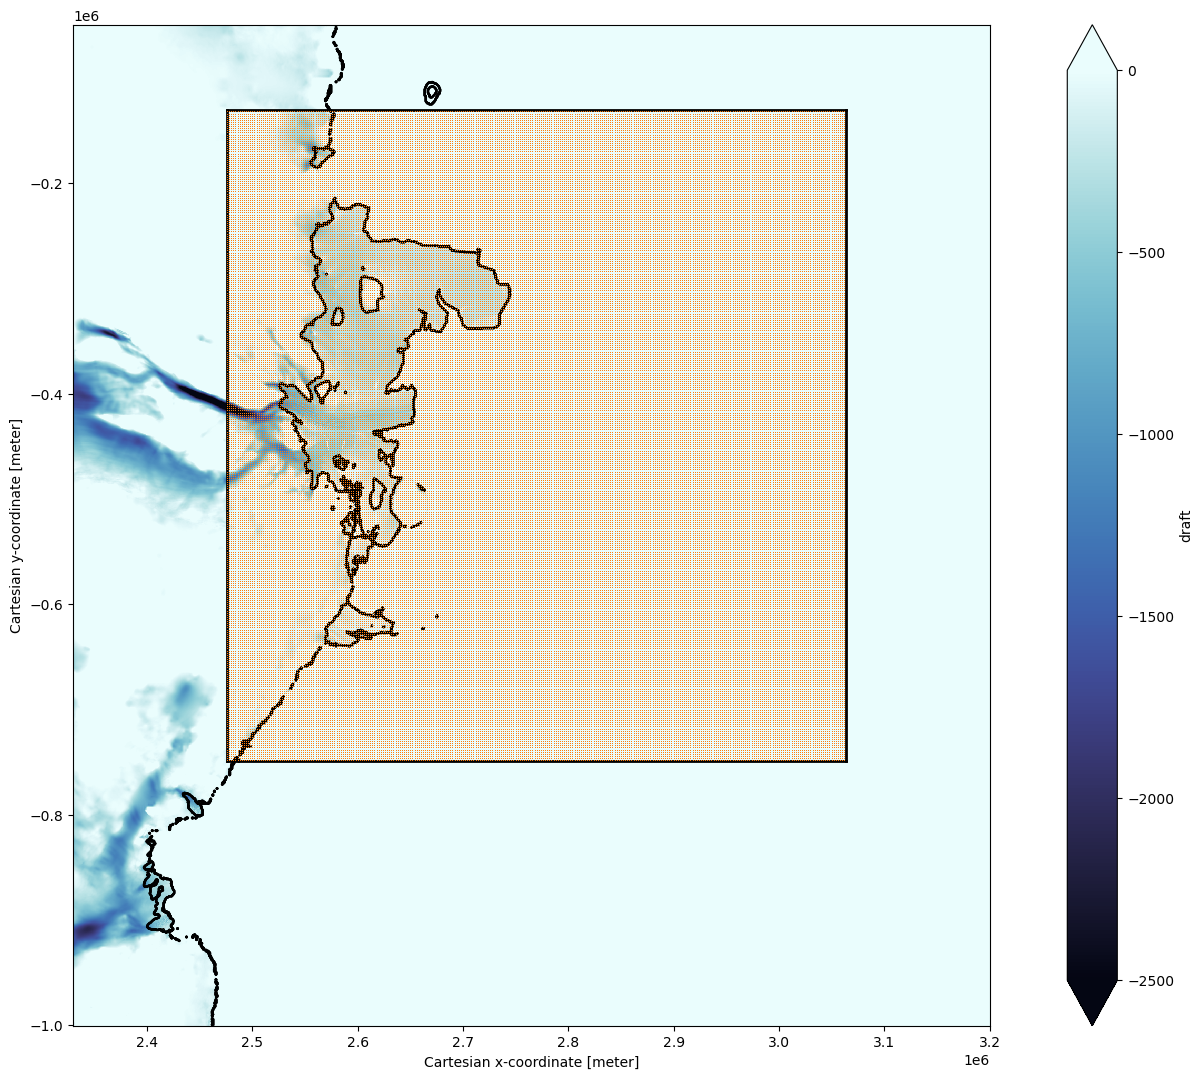

In [8]:
# plot of chosen subset
plot_res=1
fig,ax=plt.subplots(figsize=(20,13))
geom.bathy.plot(vmin=000,vmax=5000,cmap='cmo.deep_r')
geom.mask_ocean.plot.contour(colors='k')
ax.plot(x_rho[0,:]*1000,y_rho[0,:]*1000,'k',linewidth=2)
ax.plot(x_rho[-1,:]*1000,y_rho[-1,:]*1000,'k',linewidth=2)
ax.plot(x_rho[:,0]*1000,y_rho[:,0]*1000,'k',linewidth=2)
ax.plot(x_rho[:,-1]*1000,y_rho[:,-1]*1000,'k',linewidth=2)
ax.plot(x_rho[0:-1:plot_res,0:-1:plot_res]*1000,y_rho[0:-1:plot_res,0:-1:plot_res]*1000,linestyle='',color='C1',marker=',',markersize=0.1)
ax.plot(x_rho[0:-1:plot_res,0:-1:plot_res].T*1000,y_rho[0:-1:plot_res,0:-1:plot_res].T*1000,linestyle='',color='C1',marker=',',markersize=0.1)
ax.set_aspect('equal','box')

plt.show()
fig,ax=plt.subplots(figsize=(20,13))
geom.draft.plot(vmin=-2500,vmax=0,cmap='cmo.ice')
geom.mask_ice.plot.contour(colors='k')
ax.plot(x_rho[0,:]*1000,y_rho[0,:]*1000,'k',linewidth=2)
ax.plot(x_rho[-1,:]*1000,y_rho[-1,:]*1000,'k',linewidth=2)
ax.plot(x_rho[:,0]*1000,y_rho[:,0]*1000,'k',linewidth=2)
ax.plot(x_rho[:,-1]*1000,y_rho[:,-1]*1000,'k',linewidth=2)
ax.plot(x_rho[0:-1:plot_res,0:-1:plot_res]*1000,y_rho[0:-1:plot_res,0:-1:plot_res]*1000,linestyle='',color='C1',marker=',',markersize=0.1)
ax.plot(x_rho[0:-1:plot_res,0:-1:plot_res].T*1000,y_rho[0:-1:plot_res,0:-1:plot_res].T*1000,linestyle='',color='C1',marker=',',markersize=0.1)
ax.set_aspect('equal','box')


In [9]:
#load south polar stereographic projection to convert from grid point distance in m to lat/lon and back

#get lat/lon coordinates at all grid points by shifting the grid to the lower left corner of the map
lat,lon = inverse_polar_stereo(x,y,0,0,-71.0)

#calculate curvilinear coordinate distances at rho points
dx = haversine(lon[1::2,0:-2:2],lat[1::2,0:-2:2],lon[1::2,2::2],lat[1::2,2::2])
dy = haversine(lon[0:-2:2,1::2],lat[0:-2:2,1::2],lon[2::2,1::2],lat[2::2,1::2])


#calculate curvilinear coordinate metrices
pm = 1.0/dx
pn = 1.0/dy
 
dndx = np.empty_like(pm)
dmde = np.empty_like(pn)

dndx[:,1:-1] = 0.5*(pn[:,2:] - pn[:,:-2])
dmde[1:-1,:] = 0.5*(pm[2:,:] - pm[:-2,:])

dndx[:,0]  = 2*dndx[:,1]  - dndx[:,2]
dndx[:,-1] = 2*dndx[:,-2] - dndx[:,-3]
dmde[0,:]  = 2*dmde[1,:]  - dmde[2,:]
dmde[-1,:] = 2*dmde[-2,:] - dmde[-3,:]

#subset lat and lon at rho, psi, u and v points
lon_rho = lon[1::2,1::2]
lat_rho = lat[1::2,1::2]

lon_psi = lon[2:-1:2,2:-1:2]
lat_psi = lat[2:-1:2,2:-1:2]

lon_u = lon[1::2,2:-1:2]
lat_u = lat[1::2,2:-1:2]

lon_v = lon[2:-1:2,1::2]
lat_v = lat[2:-1:2,1::2]

In [10]:
# convert the final rho,psi,u,v points to x,y grid

x_rho,y_rho = ll_to_ps.transform(lat_rho,lon_rho)
x_psi,y_psi = ll_to_ps.transform(lat_psi,lon_psi)
x_u,y_u = ll_to_ps.transform(lat_u,lon_u)
x_v,y_v = ll_to_ps.transform(lat_v,lon_v)




In [11]:
lat_s = geom.lat.values.flatten()
lon_s = geom.lon.values.flatten()

In [12]:
# interpolate from the geometry grid to the new roms grid

from scipy.interpolate import griddata

def grid_data(data):
    return griddata((lon_s,lat_s),data,(lon_rho,lat_rho),'nearest')

roms_tmp = {}
for key in ['bathy','draft','mask_ice','mask_ocean']:
    roms_tmp[key] = grid_data(geom[key].values.flatten())
    print('interpolated',key)

interpolated bathy
interpolated draft
interpolated mask_ice
interpolated mask_ocean


In [13]:
### add raw bathy and draft to netcdf
print('adding hraw and ziceraw')

hraw = roms_tmp['bathy'].copy()
ziceraw = roms_tmp['draft'].copy()
mask_oceanraw = roms_tmp['mask_ocean'].copy()

adding hraw and ziceraw


In [14]:
if plotting:
    plt.close()
    for key,data in roms_tmp.items():
        fig,ax = plt.subplots(figsize=(15,10))
        if key=='draft':
            plot = ax.pcolormesh(data)        
        else:
            plot = ax.pcolormesh(data)
        ax.set_title(key)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('equal')
        plt.show()

  
Minimum r-value =  -3.102402448654175
Maximum r-value =  2431.52783203125
Mean    r-value =  0.2416168089314872
Median  r-value =  0.010532730259001255


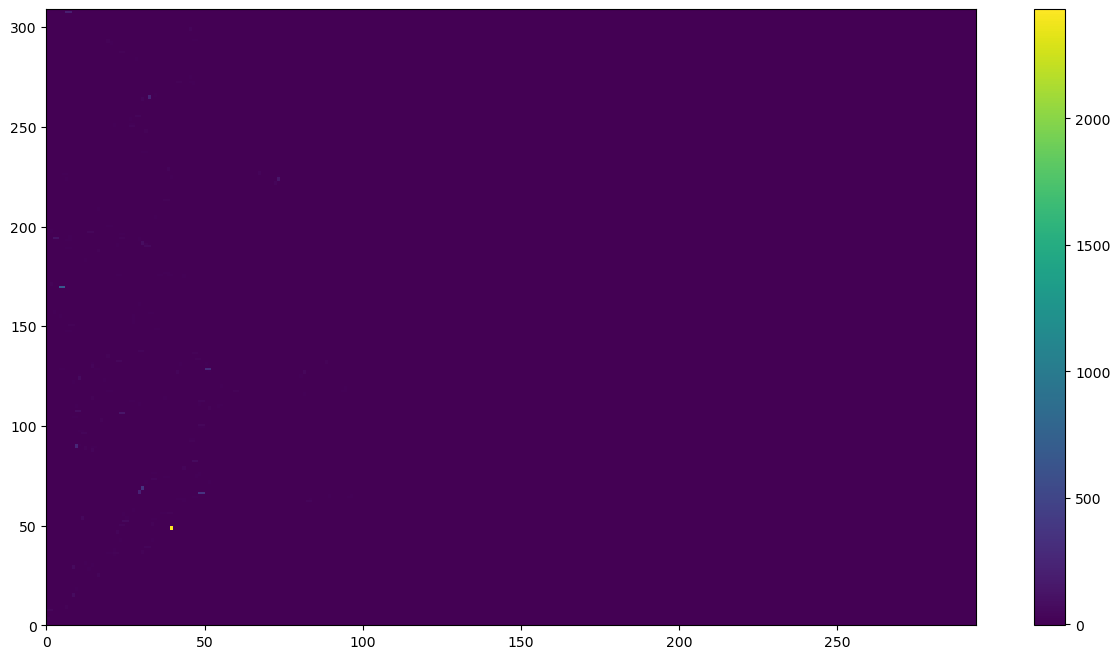

/home/woden/Documents/shackleton-setup/src/functions/GridStiffness.py:141: RuntimeWarning: divide by zero encountered in divide
  zx[k,:] = abs((z_w[k,1:,:] - z_w[k,:-1,:] + z_w[k-1,1:,:] - z_w[k-1,:-1,:]) /
/home/woden/Documents/shackleton-setup/src/functions/GridStiffness.py:143: RuntimeWarning: divide by zero encountered in divide
  zy[k,:] = abs((z_w[k,:,1:] - z_w[k,:,:-1] + z_w[k-1,:,1:] - z_w[k-1,:,:-1]) /


  
Minimum r-value =  0.0
Maximum r-value =  inf
Mean    r-value =  inf
Median  r-value =  2.128608268632422


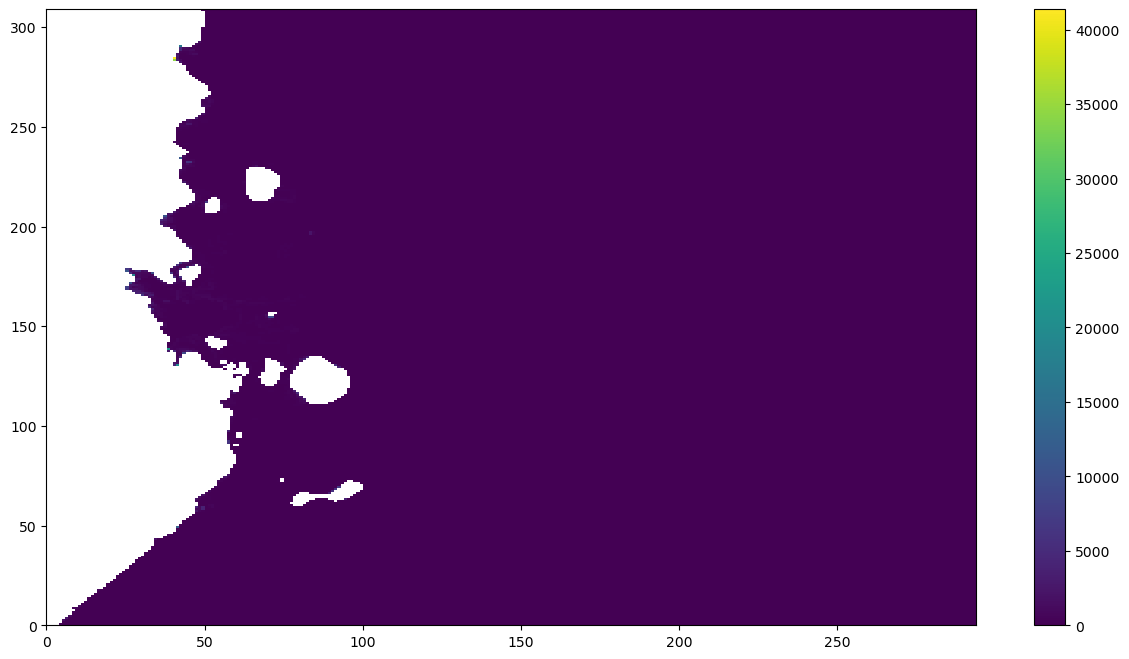

In [15]:


z_rho_pre,z_w_pre,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,roms_tmp['bathy'],roms_tmp['draft'])


fig = plt.figure(figsize=(15,8))
grd_rx0_pre=GridStiffness.rx0(roms_tmp['bathy'],np.ones(roms_tmp['mask_ocean'].shape))
plt.pcolormesh(grd_rx0_pre)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(15,8))
grd_rx1_pre=GridStiffness.rx1(z_w_pre,np.ones(roms_tmp['mask_ocean'].shape))
plt.pcolormesh(grd_rx1_pre)
plt.colorbar()
plt.show()

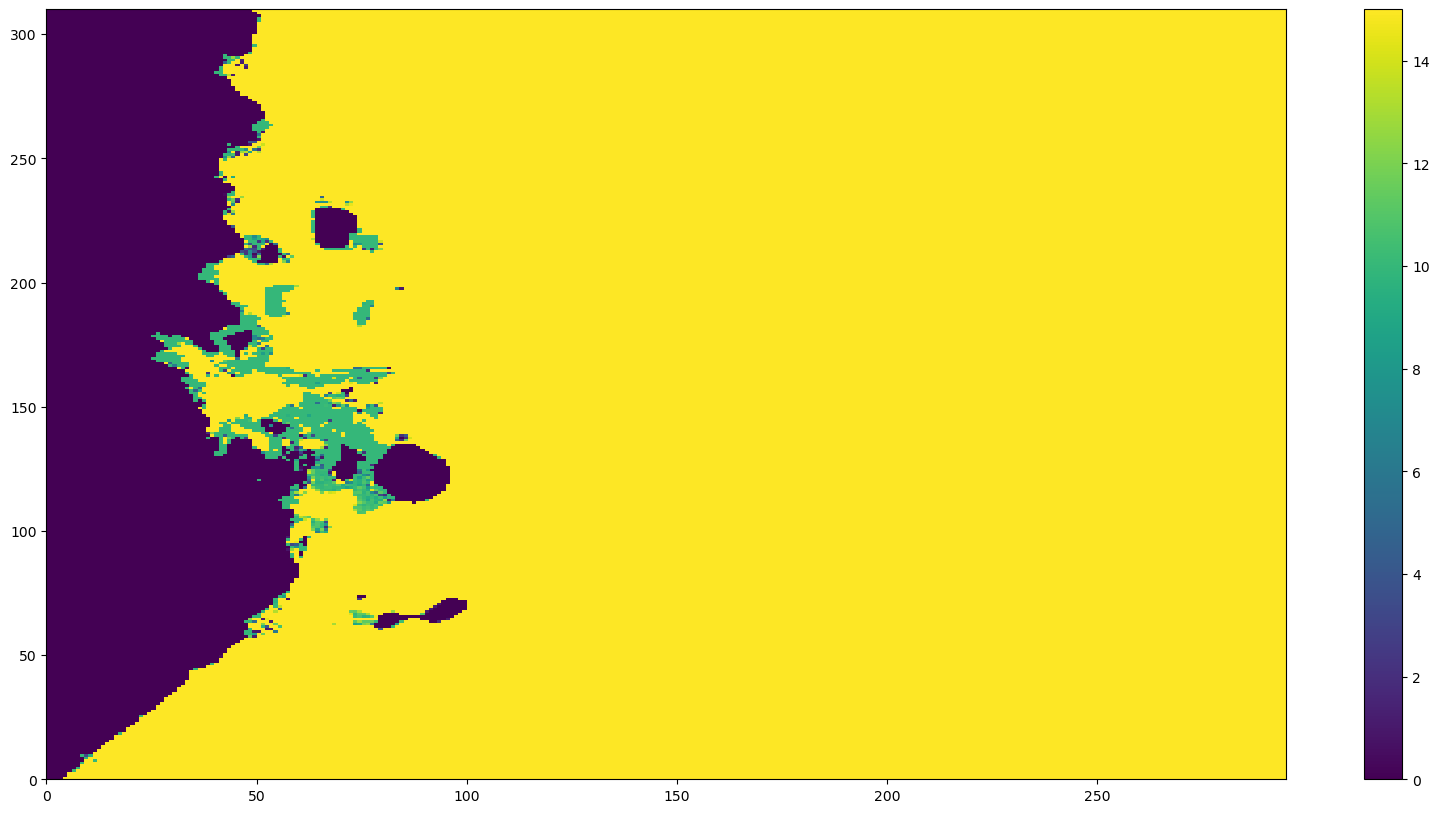

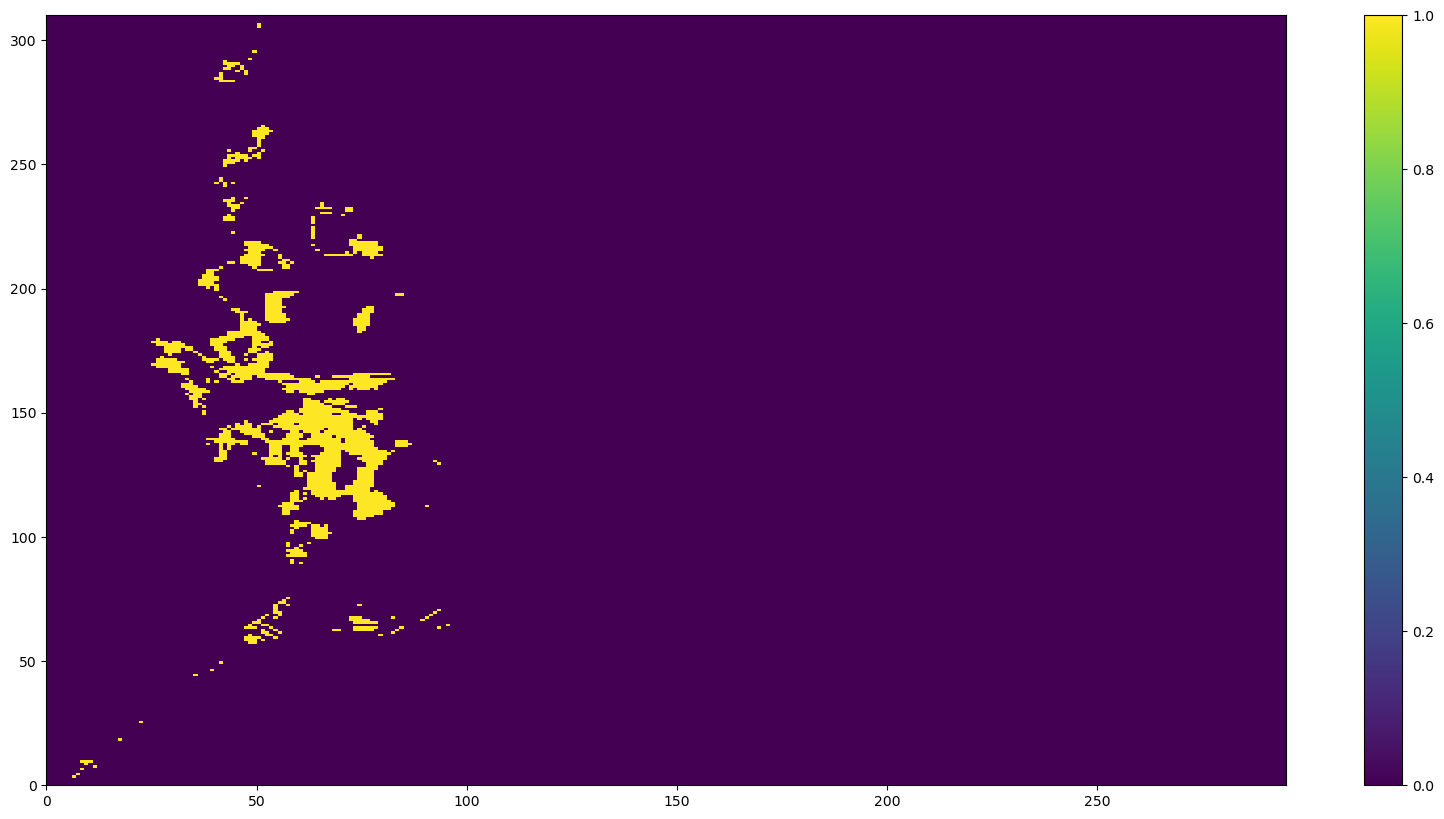

In [16]:
# First need to check for any badly masked points - before any smoothing happens
Thresh = 15

%matplotlib inline
fig = plt.figure(figsize=(20,10))
thin_WCT = (roms_tmp['bathy']+roms_tmp['draft'])*roms_tmp['mask_ocean']
plt.pcolormesh(thin_WCT,vmin=0,vmax=Thresh)
plt.colorbar()

fig = plt.figure(figsize=(20,10))
thin_WCT_mask = (thin_WCT<Thresh) & (roms_tmp['mask_ocean']==1)
plt.pcolormesh(thin_WCT_mask)
plt.colorbar()


In [17]:
# fix a missing blob of ice that wreaks havoc later on!
preliminaryFixes = False

if preliminaryFixes:
    # plt.figure(figsize=(15,15))
    # plt.pcolormesh(lon_rho,lat_rho,roms_tmp['bathy'])#,vmin=-10,vmax=0)
    # plt.colorbar()
    # plt.contour(lon_rho,lat_rho,roms_tmp['mask_ocean'],colors='k')
    # plt.axis((98,101,-67,-66))
    
    interactive_plot_and_select_points()
    %matplotlib widget
    plt.pcolormesh(lon_rho,lat_rho,roms_tmp['bathy'])#,vmin=-10,vmax=0)
    plt.colorbar()
    plt.contour(lon_rho,lat_rho,roms_tmp['mask_ocean'],colors='k')
    plt.axis((98,101,-67,-66))
    
    
    denman_trunk = np.array([
    (99.011290323, -66.534632035),
    (98.917741935, -66.588744589),
    (98.824193548, -66.611471861),
    (98.791935484, -66.645021645),
    (98.762903226, -66.681818182),
    (98.788709677, -66.707792208),
    (98.779032258, -66.738095238),
    (98.743548387, -66.767316017),
    (98.808064516, -66.791125541),
    (98.872580645, -66.790043290),
    (98.927419355, -66.770562771),
    (98.959677419, -66.746753247),
    (99.027419355, -66.729437229),
    (99.133870968, -66.757575758),
    (99.224193548, -66.775974026),
    (99.346774194, -66.752164502),
    (99.398387097, -66.713203463),
    (99.475806452, -66.613636364),
    (99.482258065, -66.581168831),
    (99.417741935, -66.530303030),
    (99.304838710, -66.483766234),
    (99.227419355, -66.479437229),
    (99.120967742, -66.481601732),
    (99.037096774, -66.500000000),
    (98.995161290, -66.514069264)
    ]) 
    
    mask_denmantrunk = inpolygon(lon_rho, lat_rho,denman_trunk[:,0], denman_trunk[:,1])

    mask_to_delete = (mask_denmantrunk==1) & (roms_tmp['mask_ocean']==1)

    plt.figure(figsize=(15,15))
    plt.pcolormesh(lon_rho,lat_rho,mask_to_delete)
    plt.colorbar()
    plt.contour(lon_rho,lat_rho,roms_tmp['mask_ocean'],colors='k')
    plt.axis((98,101,-67,-66))
    
    roms_tmp['bathy_mod'] = roms_tmp['bathy'].copy()
    
    roms_tmp['bathy_mod'][mask_to_delete] = np.NaN
    
    plt.figure(figsize=(15,15))
    plt.pcolormesh(lon_rho,lat_rho,roms_tmp['bathy_mod'],vmin=500,vmax=3000)
    plt.colorbar()  
    plt.contour(lon_rho,lat_rho,roms_tmp['mask_ocean'],colors='k')
    plt.axis((98,101,-67,-66))   
    
    denman_fill_region = np.array([
    (99.259677419, -66.756493506),
    (99.250000000, -66.722943723),
    (99.291935484, -66.660173160),
    (99.333870968, -66.589826840),
    (99.324193548, -66.584415584),
    (99.204838710, -66.713203463),
    (99.191935484, -66.742424242),
    (99.204838710, -66.758658009),
    (99.256451613, -66.765151515)
    ])
    
    denman_fill_region2 = np.array([
    (98.859677419, -66.777056277),
    (98.879032258, -66.747835498),
    (98.924193548, -66.705627706),
    (99.004838710, -66.668831169),
    (99.069354839, -66.649350649),
    (99.046774194, -66.639610390),
    (98.975806452, -66.649350649),
    (98.930645161, -66.672077922),
    (98.882258065, -66.698051948),
    (98.856451613, -66.719696970),
    (98.830645161, -66.744588745),
    (98.808064516, -66.761904762),
    (98.798387097, -66.772727273),
    (98.833870968, -66.781385281),
    (98.856451613, -66.774891775)
    ])
    
    denman_fill_edge = np.array([
    (99.001612903, -66.504329004),
    (99.017741935, -66.532467532),
    (98.859677419, -66.607142857),
    (98.785483871, -66.642857143),
    (98.766129032, -66.682900433),
    (98.798387097, -66.708874459),
    (98.746774194, -66.762987013),
    (98.850000000, -66.798701299),
    (99.040322581, -66.717532468),
    (99.053225806, -66.733766234),
    (99.237096774, -66.767316017),
    (99.324193548, -66.735930736),
    (99.420967742, -66.624458874),
    (99.491935484, -66.593073593),
    (99.456451613, -66.572510823),
    (99.388709677, -66.593073593),
    (99.362903226, -66.608225108),
    (99.330645161, -66.627705628),
    (99.240322581, -66.721861472),
    (99.198387097, -66.734848485),
    (99.098387097, -66.709956710),
    (99.030645161, -66.691558442),
    (98.901612903, -66.733766234),
    (98.859677419, -66.753246753),
    (98.824193548, -66.744588745),
    (98.859677419, -66.715367965),
    (98.843548387, -66.695887446),
    (98.827419355, -66.679653680),
    (98.866129032, -66.638528139),
    (98.943548387, -66.614718615),
    (99.056451613, -66.576839827),
    (99.101612903, -66.543290043),
    (99.104838710, -66.507575758),
    (99.062903226, -66.491341991),
    (98.995161290, -66.502164502)
    ])
    
    denman_seed1 =np.array([
    (99.143548387, -66.535714286),
    (99.198387097, -66.535714286),
    (99.195161290, -66.551948052),
    (99.127419355, -66.561688312),
    (99.114516129, -66.545454545)
    ])
    
    denman_seed2 = np.array([
    (99.382258065, -66.556277056),
    (99.382258065, -66.536796537),
    (99.272580645, -66.528138528),
    (99.237096774, -66.563852814),
    (99.320967742, -66.569264069),
    (99.366129032, -66.570346320)
    ])

    mask_denmanfillregion = inpolygon(lon_rho, lat_rho,denman_fill_region[:,0], denman_fill_region[:,1])
    mask_denmanfillregion2 = inpolygon(lon_rho, lat_rho,denman_fill_region2[:,0], denman_fill_region2[:,1])
    mask_denmanfillregion3 = inpolygon(lon_rho, lat_rho,denman_fill_edge[:,0], denman_fill_edge[:,1])
    mask_denmanseedregion1 = inpolygon(lon_rho, lat_rho,denman_seed1[:,0], denman_seed1[:,1])
    mask_denmanseedregion2 = inpolygon(lon_rho, lat_rho,denman_seed2[:,0], denman_seed2[:,1])

    roms_tmp['bathy_mod'][mask_denmanfillregion3] = -roms_tmp['draft'][mask_denmanfillregion3]+35#1400
    roms_tmp['bathy_mod'][mask_denmanseedregion1] = -roms_tmp['draft'][mask_denmanseedregion1]+150#1400
    roms_tmp['bathy_mod'][mask_denmanseedregion2] = -roms_tmp['draft'][mask_denmanseedregion2]+150#1400

    
    roms_tmp['bathy_mod'][mask_denmanfillregion] = -roms_tmp['draft'][mask_denmanfillregion]+400#1800
    roms_tmp['bathy_mod'][mask_denmanfillregion2] = -roms_tmp['draft'][mask_denmanfillregion2]+300#1400
    
    
  
    plt.figure(figsize=(15,15))
    plt.pcolormesh(lon_rho,lat_rho,roms_tmp['bathy_mod'],vmin=500,vmax=3000)
    plt.colorbar()  
    plt.contour(lon_rho,lat_rho,roms_tmp['mask_ocean'],colors='k')
    plt.axis((98,101,-67,-66))   


    tmp = inpaint_nans(roms_tmp['bathy_mod'])
    
    tmp[tmp+roms_tmp['draft']<0] = -roms_tmp['draft'][tmp+roms_tmp['draft']<0]+150
    
  
    plt.figure(figsize=(15,15))
    plt.pcolormesh(lon_rho,lat_rho,tmp,vmin=000,vmax=3000)
    plt.colorbar()  
    plt.contour(lon_rho,lat_rho,roms_tmp['mask_ocean'],colors='k')
    plt.axis((98,101,-67,-66))       
    
    
    
    plt.figure(figsize=(15,15))
    plt.pcolormesh(lon_rho,lat_rho,tmp-roms_tmp['bathy'],vmin=-300,vmax=300)
    plt.colorbar()  
    plt.contour(lon_rho,lat_rho,roms_tmp['mask_ocean'],colors='k')
    plt.axis((98,101,-67,-66))  
    
        
    plt.figure(figsize=(15,15))
    plt.pcolormesh(lon_rho,lat_rho,tmp+roms_tmp['draft'],vmin=-300,vmax=300)
    plt.colorbar()  
    plt.contour(lon_rho,lat_rho,roms_tmp['mask_ocean'],colors='k')
    plt.axis((98,101,-67,-66))  
    
    
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.pcolormesh(lon_rho,lat_rho,tmp,vmin=000,vmax=3000)
    plt.colorbar()
    plt.contour(lon_rho,lat_rho,roms_tmp['mask_ocean'],colors='k')
    plt.axis((98,101,-67,-66))
    plt.subplot(122)
    plt.pcolormesh(lon_rho,lat_rho,roms_tmp['bathy'],vmin=000,vmax=3000)
    plt.colorbar()
    plt.contour(lon_rho,lat_rho,roms_tmp['mask_ocean'],colors='k')
    plt.axis((98,101,-67,-66))
    

In [18]:
# now overwrite the original bathy with the fixed bathy
if preliminaryFixes:
    roms_tmp['bathy'] = tmp.copy()


In [19]:
# do checks
print('min/max zice is',roms_tmp['draft'].min(),'/',roms_tmp['draft'].max())
print('min/max h is',roms_tmp['bathy'].min(),'/',roms_tmp['bathy'].max())
print('min/max wct is',(roms_tmp['draft']+roms_tmp['bathy']).min(),'/',(roms_tmp['draft']+roms_tmp['bathy']).max())

min/max zice is -3446.1323 / 1171.7562
min/max h is -1171.7562 / 4546.427
min/max wct is 0.0 / 4546.427


First round of smoothing
make masks
remove mountains etc
begin smoothing
now, smooth bed
Old Max Roughness value is:  0.9995940327644348


DeltaBathymetry =  -6334.75
New Max Roughness value is:  0.18476346135139465
now, smooth bed more beneath ice
Old Max Roughness value is:  0.15144696831703186


DeltaBathymetry =  -8901.625
New Max Roughness value is:  0.10079029202461243
truncate any ice deeper than new smoothed bed
deepen bedrock until it is at least min_depth
deepen the deep ice bedrock to a slightly deeper min_depth
deepen bedrock in shallow open ocean and thin cavity
finally, smooth bed in ocean
Old Max Roughness value is:  0.47850802540779114


DeltaBathymetry =  0.0
New Max Roughness value is:  0.47850802540779114
  
Minimum r-value =  0.0
Maximum r-value =  0.47850802540779114
Mean    r-value =  0.019477353158484007
Median  r-value =  0.008359086699783802


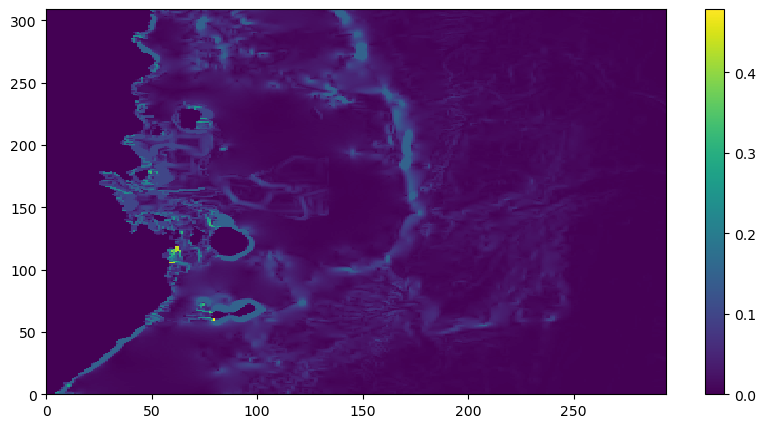

  
Minimum r-value =  0.0
Maximum r-value =  205.28861609789078
Mean    r-value =  4.532077279889257
Median  r-value =  1.1472584407283157


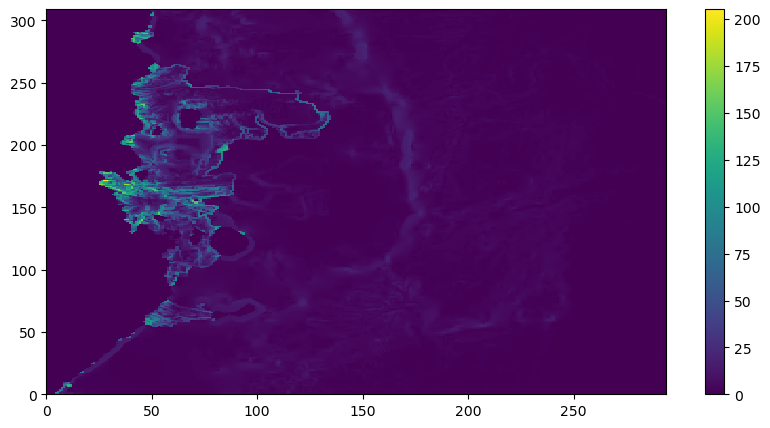

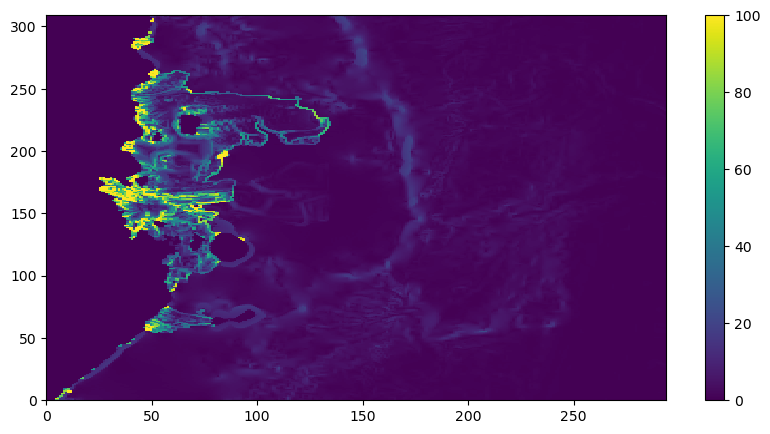

In [20]:
print('First round of smoothing')

print('make masks')
bed = roms_tmp['bathy'].copy()
bed_raw = roms_tmp['bathy'].copy()
ice = roms_tmp['draft'].copy()
mask = roms_tmp['mask_ocean'].copy()
maskNaN = mask.copy() # make a nan mask.
maskNaN = np.where(maskNaN==0,np.NaN,maskNaN)
mask_ice = roms_tmp['mask_ice'].copy()


# # first, make any bedrock above MSL, and any ice above MSL to 0. (remove mountains)
# print('remove mountains etc')
# min_depth0=0.3
# ice[ice>0] = 0
# bed[bed < min_depth0] = min_depth0 #note that bathy cannot >=0

# # for any locations where there is wct<min_depth0; deepen the ice a bit until it is at least min_depth0
# print('deepen ice until it is at least min_depth')
# wct = bed + ice
# ice[wct<min_depth0] = -bed[wct<min_depth0] + min_depth0  
# wct = bed + ice

# # make ice mask
# mask_ice = ice.copy()
# mask_ice[mask_ice>=0]=0
# mask_ice[mask_ice<0]=1
# mask_ice = mask_ice*mask
# mask_openocean = (mask_ice==0)*mask

RemoveMountains=True
if RemoveMountains:
    #  make any bedrock above MSL, and any ice above MSL to 0. (remove mountains)
    print('remove mountains etc')
    min_depth0=0.3
    ice[ice>0] = 0
    bed[bed < min_depth0] = min_depth0 #note that bathy cannot >=0


# smooth the wct and bed, then deepen the ice to correct for smoothed wct/bed.
print('begin smoothing')
Area = 1/(pm*pn)

# print('smooth ice')
# rx0in = 0.2
# max_iter = 1
# ice, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(mask,ice,rx0in,Area,max_iter)

# print('reimpose original ice mask')
# ice = ice*mask_ice

print('now, smooth bed')
rx0in = 0.15
max_iter = 50
bed, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones(mask.shape),bed,rx0in,Area,max_iter)

print('now, smooth bed more beneath ice')
rx0in = 0.1
max_iter = 50
bed, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(mask_ice,bed,rx0in,Area,max_iter)

print('truncate any ice deeper than new smoothed bed')
ice[-ice>bed] = -bed[-ice>bed]


# for any locations where there is wct<min_depth0; deepen the ice a bit until it is at least min_depth0
print('deepen bedrock until it is at least min_depth')
min_depth=25
wct = bed + ice
bed[wct<min_depth] = -ice[wct<min_depth] + min_depth
wct = bed + ice

print('deepen the deep ice bedrock to a slightly deeper min_depth')
min_depth1=150
wct = bed + ice
iii = (wct<50) & (ice<-450) & (mask_ice==1)
bed[iii] = -ice[iii] + min_depth1
wct = bed + ice


print('deepen bedrock in shallow open ocean and thin cavity')
min_depth_open_ocean = 25.0
min_depth_under_ice = 50.0

ii = ((bed + ice) < min_depth_open_ocean) & (mask == 1) & (ice == 0) #set the minimum open ocean water column thickness
bed[ii] = -ice[ii] + min_depth_open_ocean
wct=bed+ice

ii = ((bed + ice) < min_depth_under_ice) & (mask == 1) & (ice < 0) #set the minimum wct beneath ice shelf
bed[ii] = -ice[ii] + min_depth_under_ice
wct=bed+ice


print('finally, smooth bed in ocean')
rx0in = 0.65
max_iter = 50
bed, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(mask,bed,rx0in,Area,max_iter)


z_rho_mid,z_w_mid,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,bed,ice)

fig = plt.figure(figsize=(10,5))
grd_rx0_mid=GridStiffness.rx0(bed,mask)
plt.pcolormesh(grd_rx0_mid)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(10,5))
grd_rx1_mid=GridStiffness.rx1(z_w_mid,mask)
plt.pcolormesh(grd_rx1_mid)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(10,5))
plt.pcolormesh(grd_rx1_mid,vmin=0,vmax=100)
plt.colorbar()
plt.show()


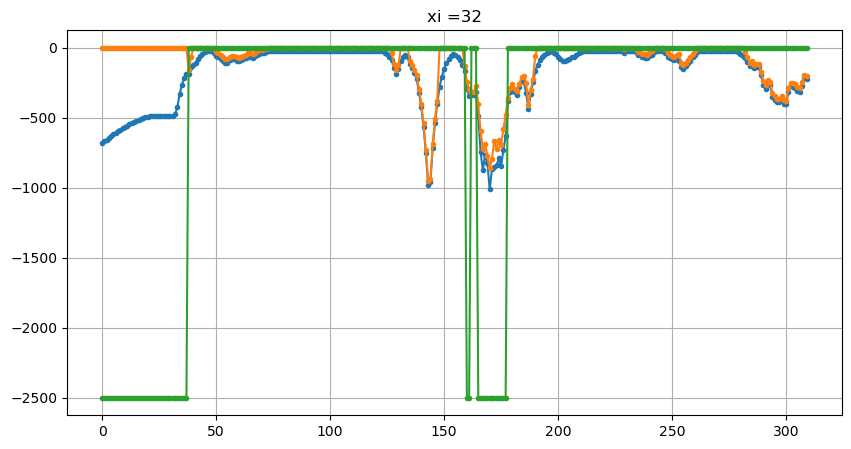

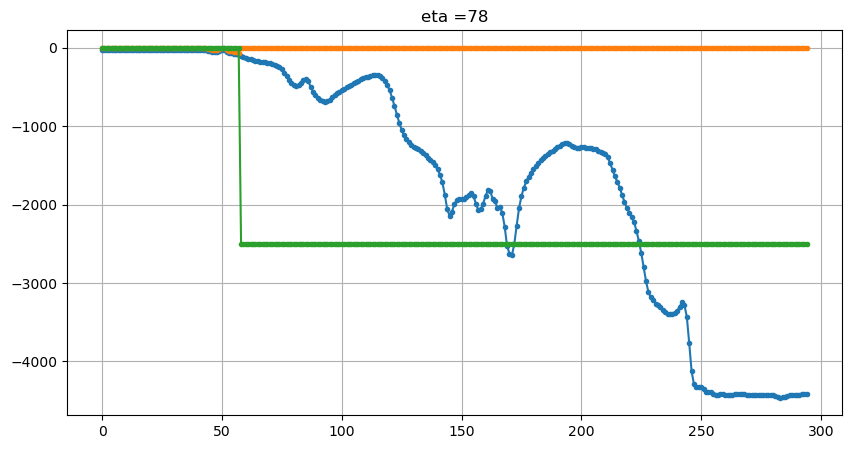

In [21]:
# %matplotlib widget
# look along a single xi value
lookAtX=32
fig = plt.figure(figsize=(10,5))
plt.plot(-bed[:,lookAtX],'.-')
plt.plot(ice[:,lookAtX],'.-')
plt.plot(-1*mask[:,lookAtX]*2500,'.-')
# plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
# plt.yticks(np.arange(-3500,0,200))
plt.title('xi ='+str(lookAtX))
# plt.xlim(focusRange[2],focusRange[3])
plt.grid()

# look along a single eta value
lookAtE=78
fig = plt.figure(figsize=(10,5))
plt.plot(-bed[lookAtE,:],'.-')
plt.plot(ice[lookAtE,:],'.-')
plt.plot(-1*mask[lookAtE,:]*2500,'.-')
# plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
# plt.yticks(np.arange(-3500,0,200))
plt.title('eta ='+str(lookAtE))
plt.grid()


In [22]:
# do checks
print('whole domain')
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(wct).min(),'/',(wct).max())
print('ocean cells')
print('min/max zice is',np.nanmin((ice*maskNaN)),'/',np.nanmax((ice*maskNaN)))
print('min/max h is',np.nanmin((bed*maskNaN)),'/',np.nanmax((bed*maskNaN)))
print('min/max wct is',np.nanmin((wct*maskNaN)),'/',np.nanmax((wct*maskNaN)))

whole domain
min/max zice is -2505.46 / -0.0
min/max h is 25.0 / 4546.427
min/max wct is 24.999939 / 4546.427
ocean cells
min/max zice is -1323.3829345703125 / -0.0
min/max h is 25.0 / 4546.4267578125
min/max wct is 25.0 / 4546.4267578125


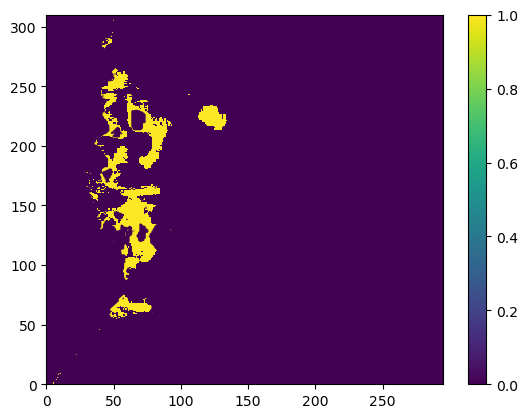

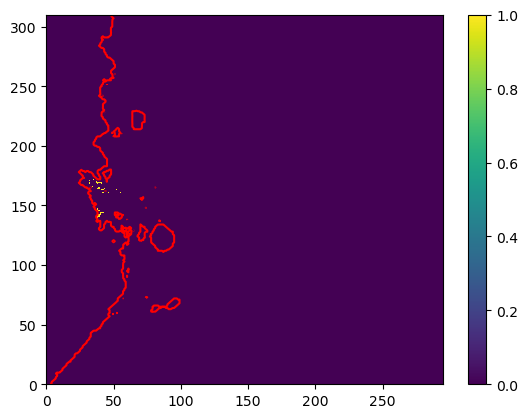

In [23]:
wct = bed+ice
plt.figure()
plt.pcolor((wct<100) & (mask_ice==1))
plt.colorbar()
plt.contour((roms_tmp['bathy']+roms_tmp['draft']),levels=[1],linestyles='-')
plt.show()
plt.figure
plt.pcolor( (wct<100) & (ice<-500) & (mask_ice==1) )
plt.colorbar()
plt.contour((roms_tmp['bathy']+roms_tmp['draft']),levels=[1],linestyles='-',colors='r')
plt.show()

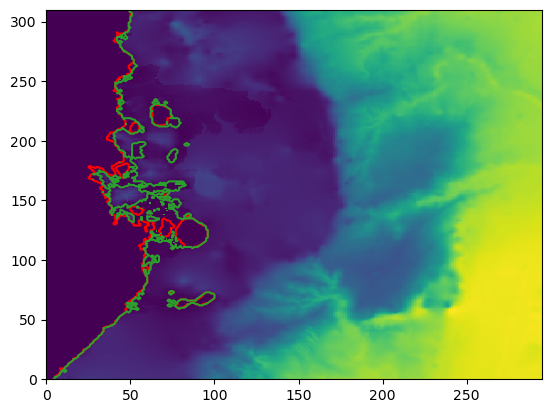

bed 90.342285  ice  90.342285 wct 0.0


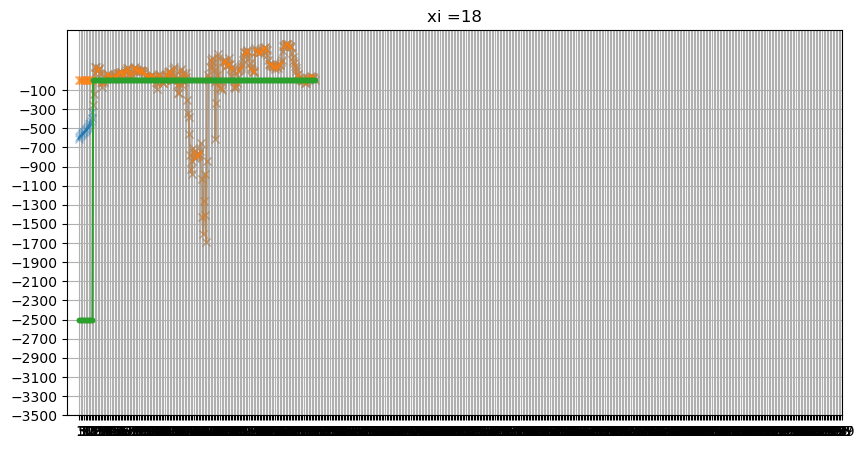

In [24]:
#%matplotlib widget
plt.figure()
plt.pcolor((roms_tmp['bathy']+roms_tmp['draft']),linestyles='-')
plt.contour((roms_tmp['bathy']+roms_tmp['draft'])==0,levels=[0,1],linestyles='-',colors='r')
plt.contour((roms_tmp['bathy']+roms_tmp['draft'])<=10,levels=[0,1],linestyles='-',colors='C2')
# plt.contour(mask,levels=[0,1],colors='r'),
plt.show()

# look along a single xi value
lookAtX=18
fig = plt.figure(figsize=(10,5))

print('bed',-roms_tmp['bathy'][56,lookAtX],' ice ',roms_tmp['draft'][56,lookAtX],'wct',roms_tmp['draft'][56,lookAtX]+roms_tmp['bathy'][56,lookAtX])

# plt.plot(-bed[:,lookAtX],'.-',color='C0')
plt.plot(-roms_tmp['bathy'][:,lookAtX],'x-',color='C0',alpha=0.4)
# plt.plot(ice[:,lookAtX],'.-',color='C1')
plt.plot(roms_tmp['draft'][:,lookAtX],'x-',color='C1',alpha=0.4)
plt.plot(-1*mask[:,lookAtX]*2500,'.-',color='C2')
plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
plt.yticks(np.arange(-3500,0,200))
plt.title('xi ='+str(lookAtX))
# plt.xlim(focusRange[2],focusRange[3])
plt.grid()

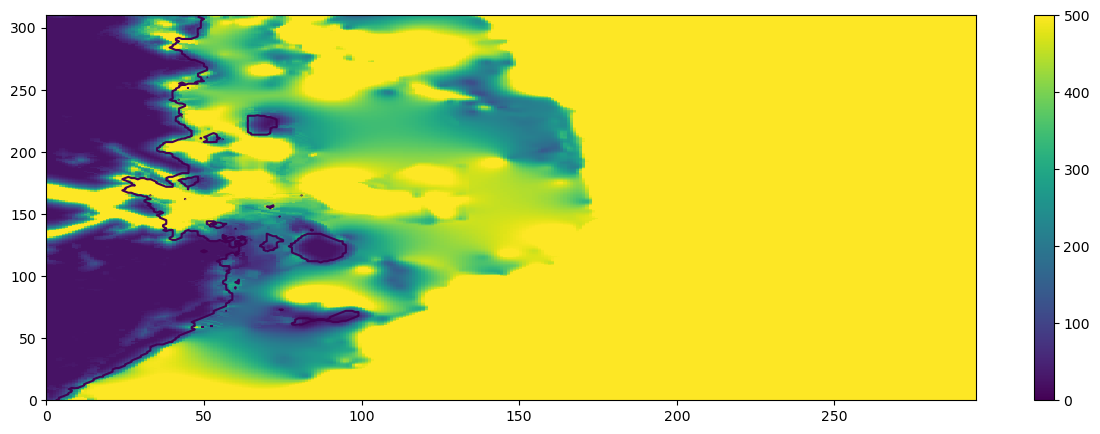

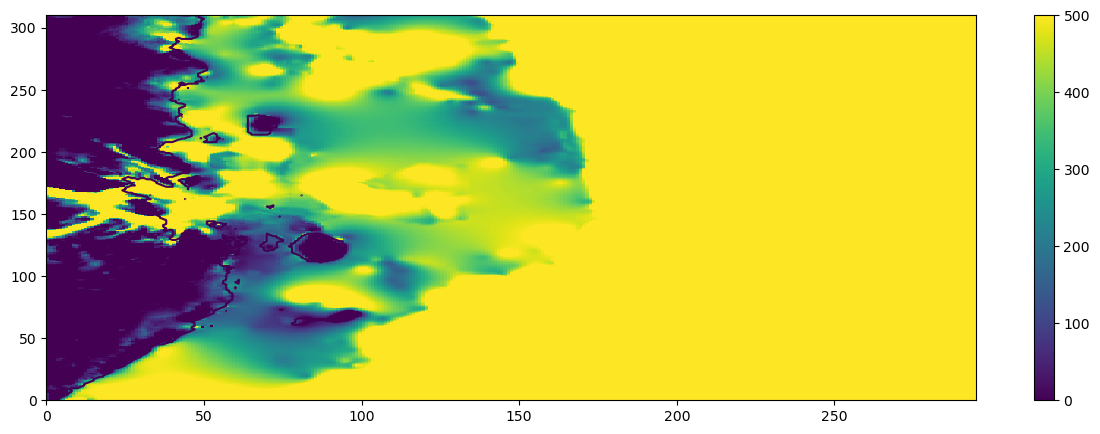

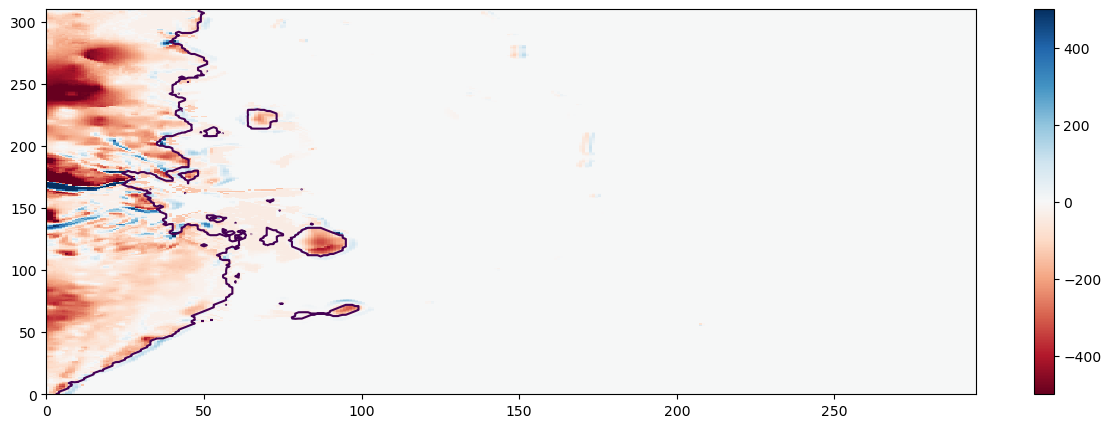

In [25]:
plt.figure(figsize=(15,5))
plt.pcolormesh(bed,vmin=00,vmax=500)
plt.colorbar()
plt.contour((roms_tmp['bathy']+roms_tmp['draft']),levels=[1],linestyles='-')
plt.show()
plt.figure(figsize=(15,5))
plt.pcolormesh(roms_tmp['bathy'],vmin=00,vmax=500)
plt.colorbar()
plt.contour((roms_tmp['bathy']+roms_tmp['draft']),levels=[1],linestyles='-')
plt.figure(figsize=(15,5))
plt.pcolormesh(roms_tmp['bathy']-bed,vmin=-500,vmax=500,cmap='RdBu')
plt.colorbar()
plt.contour((roms_tmp['bathy']+roms_tmp['draft']),levels=[1],linestyles='-')


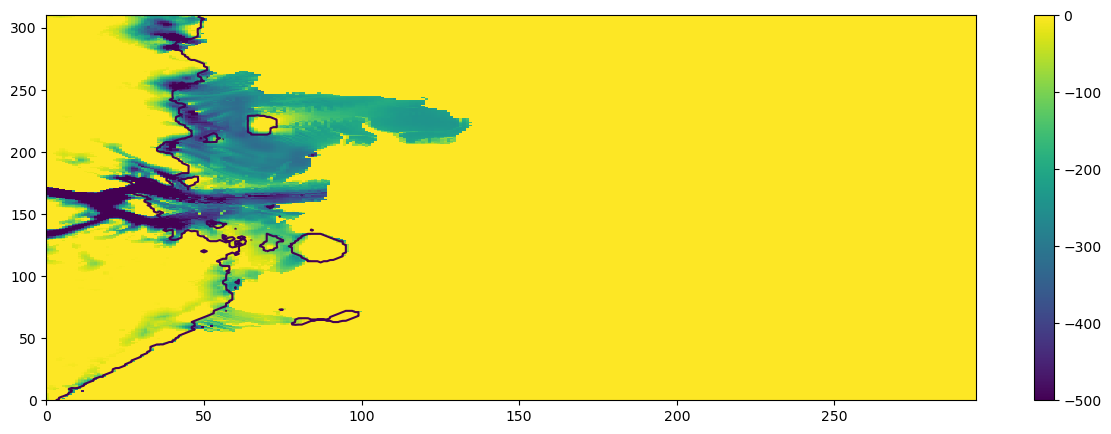

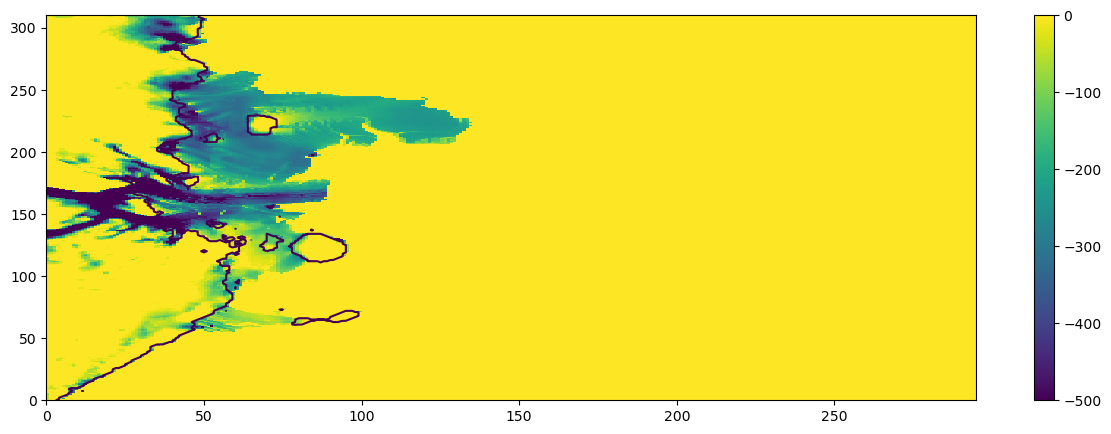

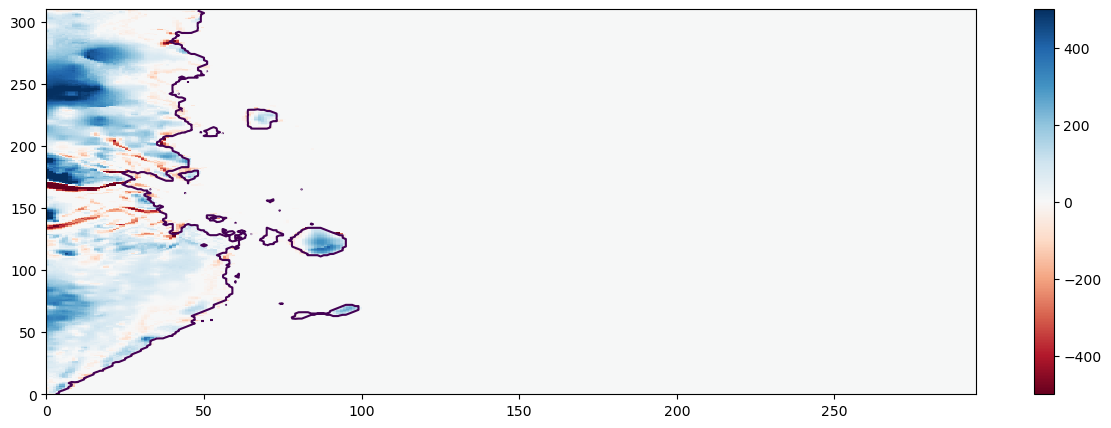

In [26]:
plt.figure(figsize=(15,5))
plt.pcolormesh(ice,vmin=-500,vmax=0)
plt.colorbar()
# plt.contour(ice,levels=(-1000,-100,-10,-1,0),colors='k',linewidths=1)
plt.contour((roms_tmp['bathy']+roms_tmp['draft']),levels=[1],linestyles='-')
plt.figure(figsize=(15,5))
plt.pcolormesh(roms_tmp['draft'],vmin=-500,vmax=0)
plt.colorbar()
# plt.contour(roms_tmp['draft'],levels=(-1000,-100,-10,-1,0),colors='k',linewidths=1)
plt.contour((roms_tmp['bathy']+roms_tmp['draft']),levels=[1],linestyles='-')
plt.figure(figsize=(15,5))
plt.pcolormesh(roms_tmp['draft']-ice,vmin=-500,vmax=500,cmap='RdBu')
plt.colorbar()
plt.contour((roms_tmp['bathy']+roms_tmp['draft']),levels=[1],linestyles='-')


In [27]:
# do checks
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(wct).min(),'/',(wct).max())
print('ocean cells')
print('min/max zice is',np.nanmin((ice*maskNaN)),'/',np.nanmax((ice*maskNaN)))
print('min/max h is',np.nanmin((bed*maskNaN)),'/',np.nanmax((bed*maskNaN)))
print('min/max wct is',np.nanmin((wct*maskNaN)),'/',np.nanmax((wct*maskNaN)))

min/max zice is -2505.46 / -0.0
min/max h is 25.0 / 4546.427
min/max wct is 24.999939 / 4546.427
ocean cells
min/max zice is -1323.3829345703125 / -0.0
min/max h is 25.0 / 4546.4267578125
min/max wct is 25.0 / 4546.4267578125


  
Minimum r-value =  0.0
Maximum r-value =  0.47850802540779114
Mean    r-value =  0.019477353158484007
Median  r-value =  0.008359086699783802


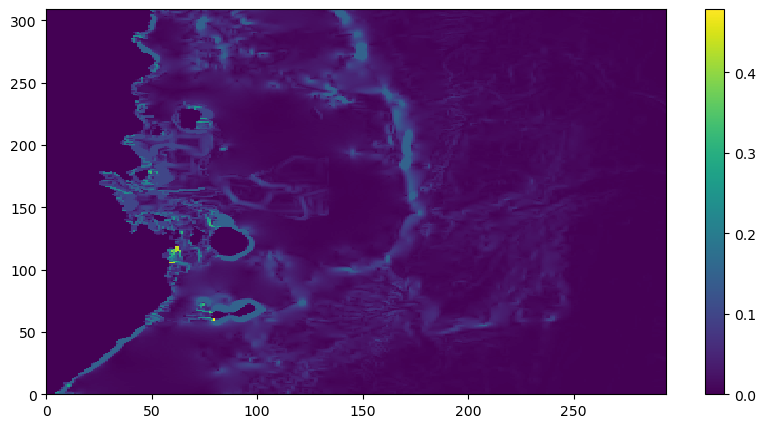

  
Minimum r-value =  0.0
Maximum r-value =  205.28861609789078
Mean    r-value =  4.532077279889257
Median  r-value =  1.1472584407283157


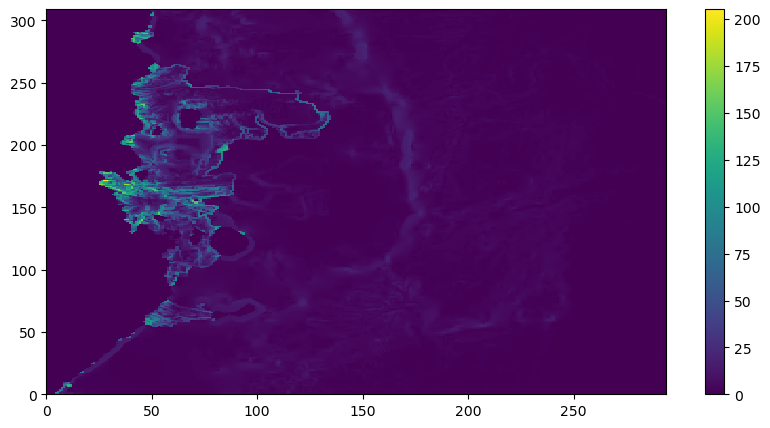

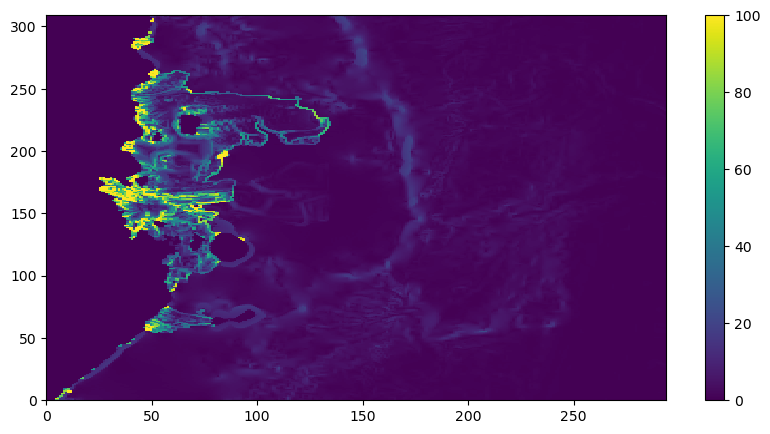

In [28]:


z_rho_mid,z_w_mid,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,bed,ice)

fig = plt.figure(figsize=(10,5))
grd_rx0_mid=GridStiffness.rx0(bed,mask)
plt.pcolormesh(grd_rx0_mid)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(10,5))
grd_rx1_mid=GridStiffness.rx1(z_w_mid,mask)
plt.pcolormesh(grd_rx1_mid)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(10,5))
plt.pcolormesh(grd_rx1_mid,vmin=0,vmax=100)
plt.colorbar()
plt.show()

  
Minimum r-value =  0.0
Maximum r-value =  0.47850802540779114
Mean    r-value =  0.019477353158484007
Median  r-value =  0.008359086699783802
  
Minimum r-value =  0.0
Maximum r-value =  205.28861609789078
Mean    r-value =  4.532077279889257
Median  r-value =  1.1472584407283157


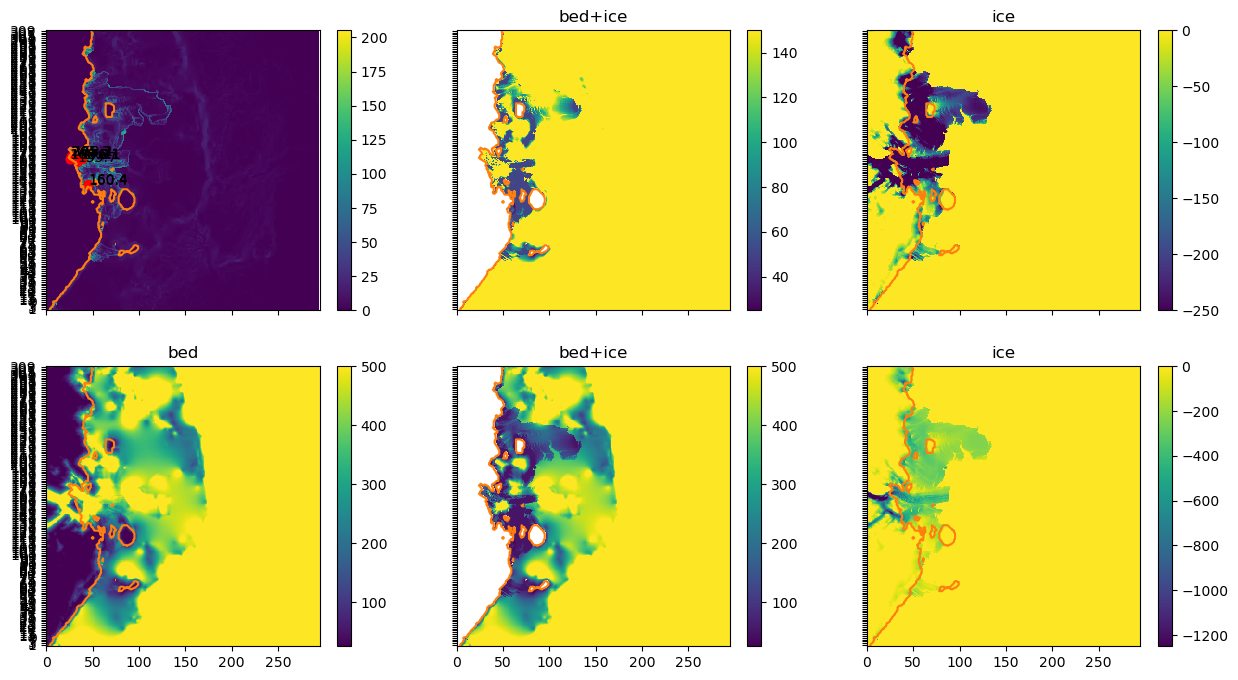

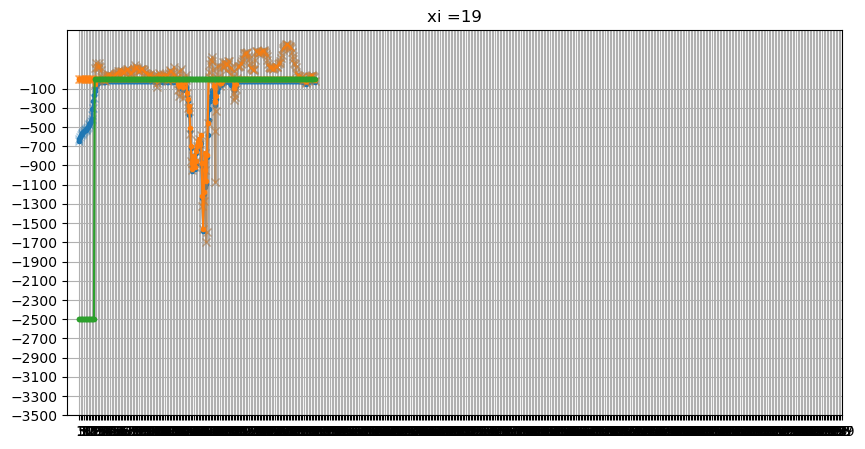

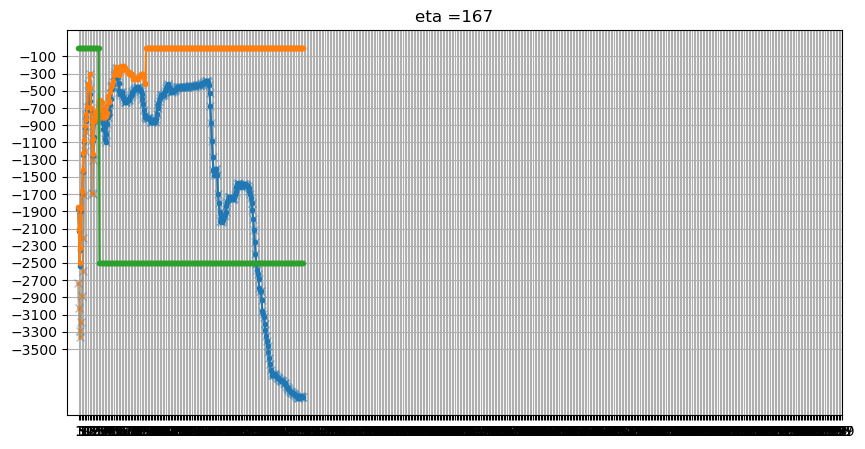

In [29]:
#%matplotlib widget
%matplotlib inline

z_rho_post,z_w_post,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,bed,ice)
grd_rx0_post=GridStiffness.rx0(bed,mask)
grd_rx1_post=GridStiffness.rx1(z_w_post,mask)

plt.close('all')


fig,axs = plt.subplots(ncols=3,nrows=2,figsize=(15,8),sharex=True,sharey=True)
im=axs[0,0].pcolormesh(grd_rx1_post)
rx1_flat = grd_rx1_post.ravel().round(1)
ind = np.argpartition(rx1_flat,-10)[-10:]
ind
for where in ind: 
    w_j,w_i=np.unravel_index(where,grd_rx1_post.shape)
    axs[0,0].plot(w_i,w_j,'ro')
    axs[0,0].text(w_i,w_j,rx1_flat[where])
axs[0,0].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[0,0])
axs[0,0].contour(mask,levels=((0,1)),colors='C1')
im=axs[0,1].pcolormesh((bed+ice)*maskNaN,vmax=150)
axs[0,1].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[0,1])
axs[0,1].contour(mask,levels=((0,1)),colors='C1')
axs[0,1].set_title('bed+ice')
im=axs[0,2].pcolormesh(ice,vmin=-250)
axs[0,2].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[0,2])
axs[0,2].contour(mask,levels=((0,1)),colors='C1')
axs[0,2].set_title('ice')
im=axs[1,0].pcolormesh(bed,vmax=500)
axs[1,0].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[1,0])
axs[1,0].contour(mask,levels=((0,1)),colors='C1')
axs[1,0].set_title('bed')
im=axs[1,1].pcolormesh((bed+ice)*maskNaN,vmax=500)
axs[1,1].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[1,1])
axs[1,1].contour(mask,levels=((0,1)),colors='C1')
axs[1,1].set_title('bed+ice')
im=axs[1,2].pcolormesh(ice,vmin=-1250)
axs[1,2].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[1,2])
axs[1,2].contour(mask,levels=((0,1)),colors='C1')
axs[1,2].set_title('ice')

# look along a single xi value
lookAtX=19
fig = plt.figure(figsize=(10,5))
plt.plot(-bed[:,lookAtX],'.-',color='C0')
plt.plot(-roms_tmp['bathy'][:,lookAtX],'x-',color='C0',alpha=0.4)
plt.plot(ice[:,lookAtX],'.-',color='C1')
plt.plot(roms_tmp['draft'][:,lookAtX],'x-',color='C1',alpha=0.4)
plt.plot(-1*mask[:,lookAtX]*2500,'.-',color='C2')
plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
plt.yticks(np.arange(-3500,0,200))
plt.title('xi ='+str(lookAtX))
# plt.xlim(focusRange[2],focusRange[3])
plt.grid()

# look along a single eta value
lookAtE=167
fig = plt.figure(figsize=(10,5))
plt.plot(-bed[lookAtE,:],'.-',color='C0')
plt.plot(-roms_tmp['bathy'][lookAtE,:],'x-',color='C0',alpha=0.4)
plt.plot(ice[lookAtE,:],'.-',color='C1')
plt.plot(roms_tmp['draft'][lookAtE,:],'.-',color='C1',alpha=0.4)
plt.plot(-1*mask[lookAtE,:]*2500,'.-',color='C2')
plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
plt.yticks(np.arange(-3500,0,200))
plt.title('eta ='+str(lookAtE))
plt.grid()



In [30]:
# apply min_depth value from before.

# Now enforce that there is no ice > 0
ii = ice>0
ice[ii] = 0

# now re-check that min_depth is obeyed for all ocean points
ii = ((bed + ice) < min_depth) & (mask == 1)
bed[ii] = -ice[ii] + min_depth

# do the same for all non-ocean points
ii = ((bed + ice) < min_depth) & (mask == 0)
ice[ii] = min_depth-bed[ii] # for those locations, the depth needs to be min_depth above the bathy

wct=bed+ice

In [31]:


roms_tmp['bed'] = bed
roms_tmp['ice'] = ice
roms_tmp['mask'] = mask

In [32]:
mask = mask.astype(float)
mindxy = min(np.hstack((1/pm.flatten(),1/pn.flatten())))
maskNaN = mask.copy()
maskNaN[mask==0]=np.nan
CFL = mindxy/abs(np.sqrt(9.81*wct))*maskNaN

print('max fast DT in s following CFL: ', np.nanmin(CFL))
print('max slow DT in s following CFL: ', np.nanmin(mindxy/8*maskNaN)) # approx max 8m/s baroclinic wave speed
print('Set ROMS timestep settings of at least: \n','DT <',np.nanmin(mindxy/8*maskNaN),'s \n NDTFAST >',(np.nanmin(mindxy/8*maskNaN)/np.nanmin(CFL)).round())
timescale = 12*60*60 #s
print('approximate viscosity settings for smoothing timescale of ',timescale/(60*60),' hrs')
print('visc2 for 2dx noise ~ ',(2*mindxy/(2*np.pi))**2 / timescale)
print('approximate diff settings are an order of magnitude lower:')
print('tnu2 ~ ',((2*mindxy/(2*np.pi))**2 / timescale/10))

# do checks
print('whole domain')
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(bed+ice).min(),'/',(bed+ice).max())
print('ocean cells')
print('min/max zice is',np.nanmin(ice*maskNaN),'/',np.nanmax(ice*maskNaN))
print('min/max h is',np.nanmin(bed*maskNaN),'/',np.nanmax(bed*maskNaN))
print('min/max wct is',np.nanmin(wct*maskNaN),'/',np.nanmax(wct*maskNaN))

max fast DT in s following CFL:  9.11462688446045
max slow DT in s following CFL:  240.61270894854079
Set ROMS timestep settings of at least: 
 DT < 240.61270894854079 s 
 NDTFAST > 26.0
approximate viscosity settings for smoothing timescale of  12.0  hrs
visc2 for 2dx noise ~  8.690276748210465
approximate diff settings are an order of magnitude lower:
tnu2 ~  0.8690276748210465
whole domain
min/max zice is -2505.46 / -0.0
min/max h is 25.0 / 4546.427
min/max wct is 25.0 / 4546.427
ocean cells
min/max zice is -1323.3829345703125 / -0.0
min/max h is 25.0 / 4546.4267578125
min/max wct is 25.0 / 4546.4267578125


  
Minimum r-value =  0.0
Maximum r-value =  0.47850802540779114
Mean    r-value =  0.019477353158484007
Median  r-value =  0.008359086699783802


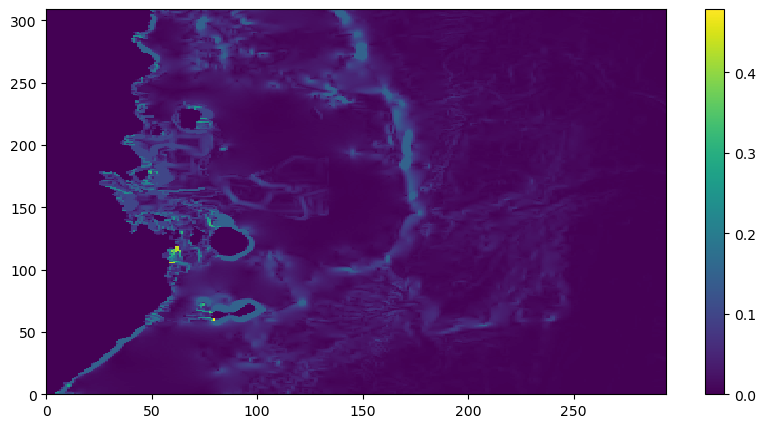

  
Minimum r-value =  0.0
Maximum r-value =  205.28861609789078
Mean    r-value =  4.532077279889257
Median  r-value =  1.1472584407283157


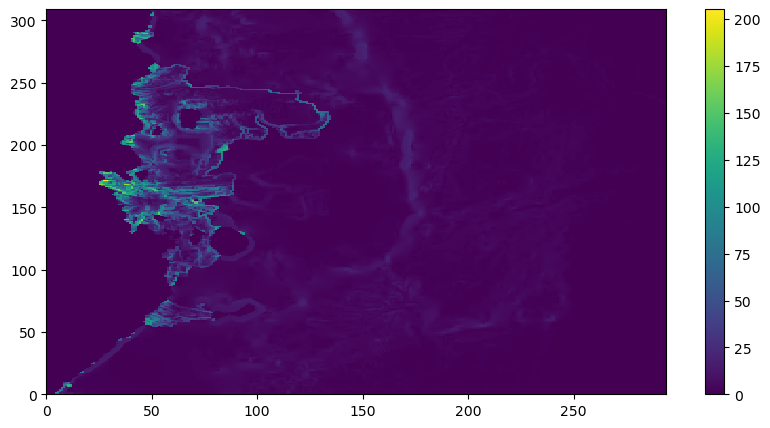

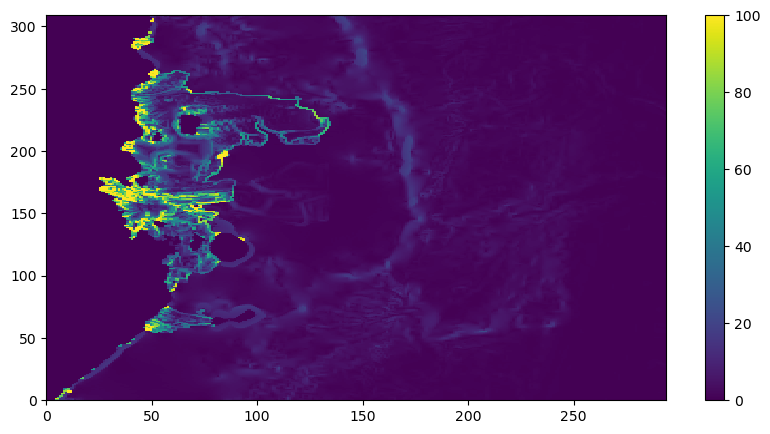

In [33]:



z_rho_post,z_w_post,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,roms_tmp['bed'],roms_tmp['ice'])

fig = plt.figure(figsize=(10,5))
grd_rx0_post=GridStiffness.rx0(roms_tmp['bed'],roms_tmp['mask'])
plt.pcolormesh(grd_rx0_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(10,5))
grd_rx1_post=GridStiffness.rx1(z_w_post,roms_tmp['mask'])
plt.pcolormesh(grd_rx1_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(10,5))
plt.pcolormesh(grd_rx1_post,vmin=0,vmax=100)
plt.colorbar()
plt.show()

In [34]:
# !!! BEWARE, ALL YE WHO ENTER HERE, THE REALM OF HAND-EDITING SUB-ICE SHELF GEOMETRY. HERE BE DRAGONS. !!!
# ensure that GridAdjustments functions are already loaded.



hhh=roms_tmp['bed'].copy()
zzz=roms_tmp['ice'].copy()
mmm=roms_tmp['mask'].copy()

if False:

    ## an edit to eta_n, xi_n will affect rx1 in the eta_n-2--eta_n-1,xi_n--xi_n+1

    # fix strange open ocean triangle in east shelf
    hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=15,roi_row_max=45,roi_col_min=32,roi_col_max=50,if_plotting=0,min_threshold_h=150) 


    #adjust denman
    hhh,zzz=adjustWCT(hhh,zzz,h_alter=-150,zice_alter=150,eta=97,xi=7)
    hhh,zzz=adjustWCT(hhh,zzz,h_alter=-150,zice_alter=150,eta=96,xi=8)
    hhh,zzz=adjustWCT(hhh,zzz,h_alter=-150,zice_alter=150,eta=95,xi=9)
    hhh,zzz=adjustWCT(hhh,zzz,h_alter=-150,zice_alter=150,eta=94,xi=10)
    hhh,zzz=adjustWCT(hhh,zzz,h_alter=-150,zice_alter=150,eta=93,xi=11)
    hhh,zzz=adjustWCT(hhh,zzz,h_alter=-150,zice_alter=150,eta=92,xi=12)
    hhh,zzz=adjustWCT(hhh,zzz,h_alter=-150,zice_alter=150,eta=91,xi=13)
    hhh,zzz=adjustWCT(hhh,zzz,h_alter=-150,zice_alter=150,eta=90,xi=14)
    # hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=71,roi_row_max=103,roi_col_min=0,roi_col_max=14,if_plotting=0,min_threshold_h=300) 
    # hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=71,roi_row_max=97,roi_col_min=0,roi_col_max=23,if_plotting=0,min_threshold_h=200) 
    out_smooth = smoothRegion(zzz.copy(),mmm.copy(),0.03,Area,1,roi_row_min=71,roi_row_max=103,roi_col_min=0,roi_col_max=14,if_plotting=0)
    hhh = hhh + (zzz - out_smooth)
    zzz = out_smooth.copy()
    out_smooth = smoothRegion(zzz.copy(),mmm.copy(),0.03,Area,1,roi_row_min=91,roi_row_max=96,roi_col_min=15,roi_col_max=20,if_plotting=0)
    hhh = hhh + (zzz - out_smooth)
    zzz = out_smooth.copy()
    hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=71,roi_row_max=105,roi_col_min=0,roi_col_max=20,if_plotting=0,min_threshold_h=220) 
    hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=0,eta=slice(115,130),xi=slice(5,19))
    hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=0,eta=slice(117,128),xi=slice(20,23))
    hhh,zzz=adjustWCT(hhh,zzz,h_alter=-50,zice_alter=50,eta=89,xi=(15,16))
    hhh,zzz=adjustWCT(hhh,zzz,h_alter=-50,zice_alter=50,eta=89,xi=20)
    hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=0,eta=slice(85,93),xi=slice(0,5))
    hhh,zzz=adjustWCT(hhh,zzz,h_alter=75,zice_alter=0,eta=slice(88,91),xi=slice(13,18))
    hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=-100,eta=89,xi=16)
    hhh,zzz=adjustWCT(hhh,zzz,h_alter=-40,zice_alter=40,eta=89,xi=14)
    hhh,zzz=adjustWCT(hhh,zzz,h_alter=-40,zice_alter=40,eta=87,xi=14)
    # hhh,zzz=adjustWCT(hhh,zzz,h_alter=00,zice_alter=0,eta=88,xi=15)
    out_smooth = smoothRegion(zzz.copy(),mmm.copy(),0.03,Area,1,roi_row_min=113,roi_row_max=131,roi_col_min=10,roi_col_max=25,if_plotting=0)
    hhh = hhh + (zzz - out_smooth)
    zzz = out_smooth.copy()
    hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=0,eta=slice(83,101),xi=slice(0,9))
    hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=0,eta=slice(94,104),xi=slice(13,21))


    # west of denman
    hhh = minWCTRegion(zzz.copy(),hhh.copy(),mmm.copy(),roi_row_min=43,roi_row_max=57,roi_col_min=15,roi_col_max=20,if_plotting=0,min_threshold_h=320) 
    out_smooth = smoothRegion(zzz.copy(),mmm.copy(),0.03,Area,1,roi_row_min=146,roi_row_max=153,roi_col_min=0,roi_col_max=25,if_plotting=0)
    hhh = hhh + (zzz - out_smooth)
    zzz = out_smooth.copy()
    out_smooth = smoothRegion(zzz.copy(),mmm.copy(),0.03,Area,1,roi_row_min=88,roi_row_max=91,roi_col_min=12,roi_col_max=16,if_plotting=0)
    hhh = hhh + (zzz - out_smooth)
    zzz = out_smooth.copy()

    #far west
    mmm=adjustMask(mmm,0,eta=slice(181,186),xi=slice(20,29))

    # outer shelf region
    mmm=adjustMask(mmm,0,eta=slice(52,55),xi=slice(55,58))

    #far east of shelf
    mmm=adjustMask(mmm,0,eta=50,xi=slice(16,18))
    mmm=adjustMask(mmm,0,eta=51,xi=16)


    # mask out bigger lakes
    mmm=adjustMask(mmm,0,eta=slice(61,63),xi=slice(28,30))
    mmm=adjustMask(mmm,0,eta=slice(43,49),xi=slice(32,38))
    mmm=adjustMask(mmm,0,eta=slice(40,41),xi=slice(26,27))


# adjust east of denman
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=0,eta=140,xi=45)

#adjust denman
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=0,eta=172,xi=28)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=0,eta=169,xi=38)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=-50,eta=168,xi=26)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-50,eta=171,xi=27)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=00,eta=171,xi=28)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=00,eta=164,xi=34)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=100,zice_alter=00,eta=slice(170,172),xi=26)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=-50,eta=slice(172,174),xi=29)

#adjust some spurious ice shallowings in west
hhh,zzz=adjustWCT(hhh,zzz,h_alter=0,zice_alter=-200,eta=slice(232,234),xi=slice(47,50))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=0,zice_alter=-150,eta=232,xi=47)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=0,zice_alter=50,eta=233,xi=47)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=0,zice_alter=100,eta=slice(231,233),xi=slice(45,47))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=0,zice_alter=200,eta=slice(203,205),xi=slice(39,41))

mmmNaN = mmm.copy().astype('float')
mmmNaN[mmmNaN == 0] = np.NaN


##### REMEMBER: THE RX0/1 VALUES ARE BELOW and TO THE LEFT OF THE PROBLEMATIC CELL.
z_rho_post,z_w_post,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh,zzz)
grd_rx0_post=GridStiffness.rx0(hhh,mmm)
grd_rx1_post=GridStiffness.rx1(z_w_post,mmm)

  
Minimum r-value =  0.0
Maximum r-value =  0.47850802540779114
Mean    r-value =  0.01947909783026367
Median  r-value =  0.008359086699783802
  
Minimum r-value =  0.0
Maximum r-value =  154.30531706752615
Mean    r-value =  4.516501782919679
Median  r-value =  1.1472584407283157


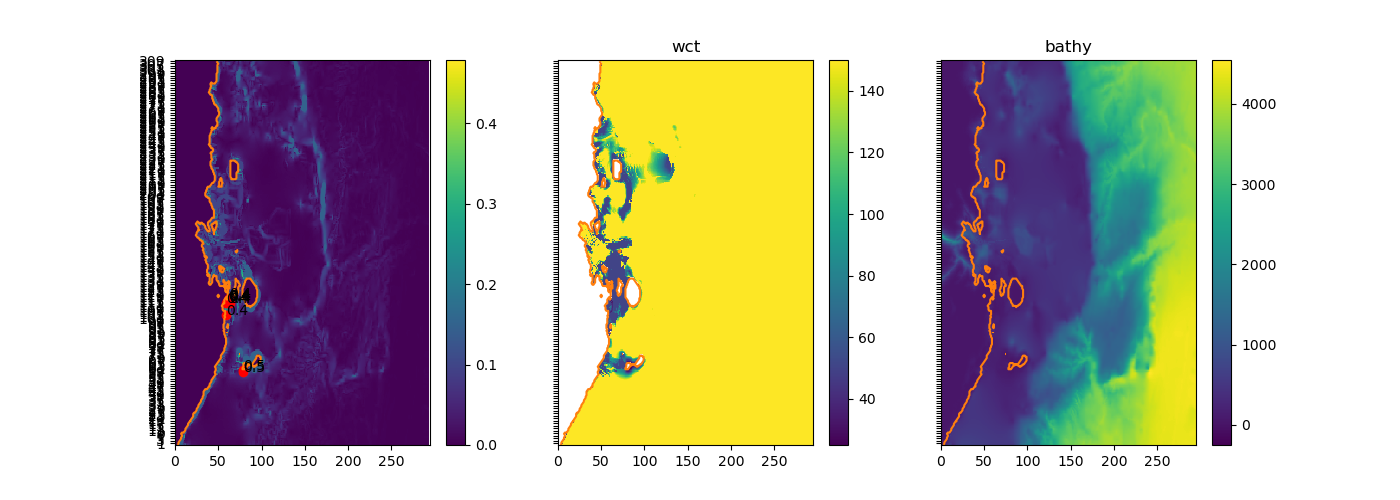

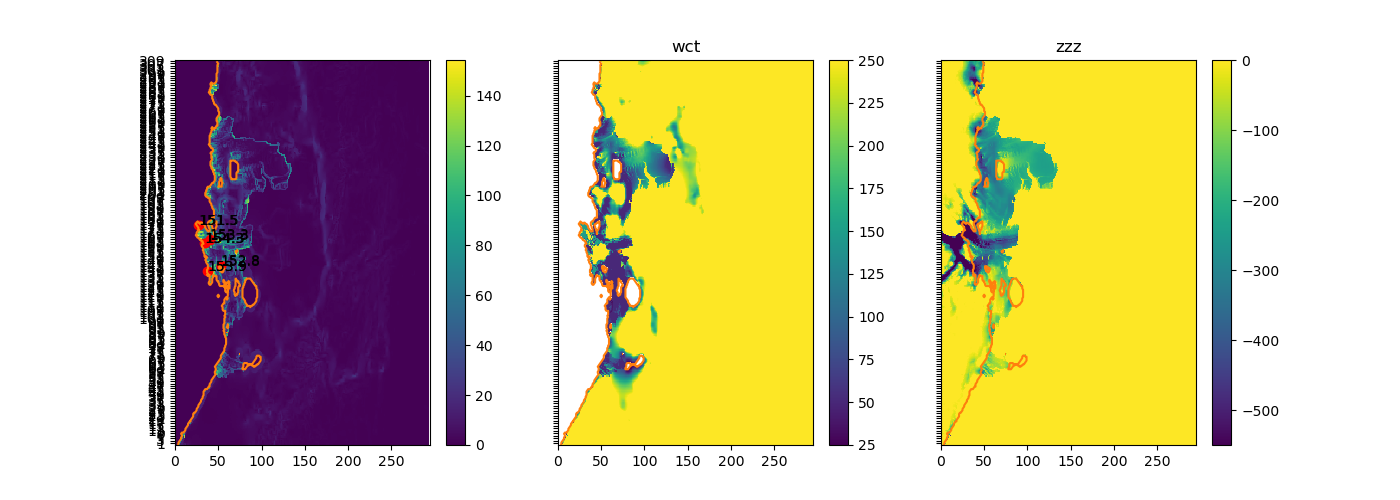

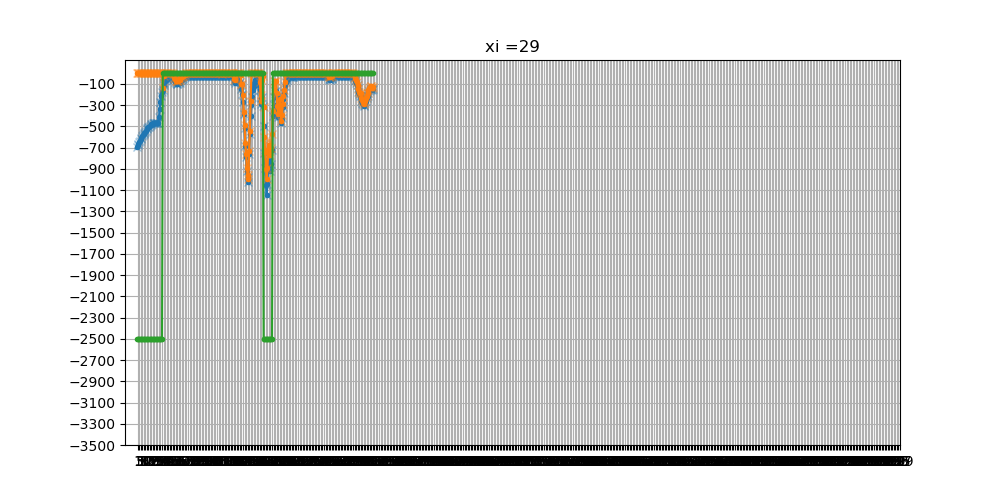

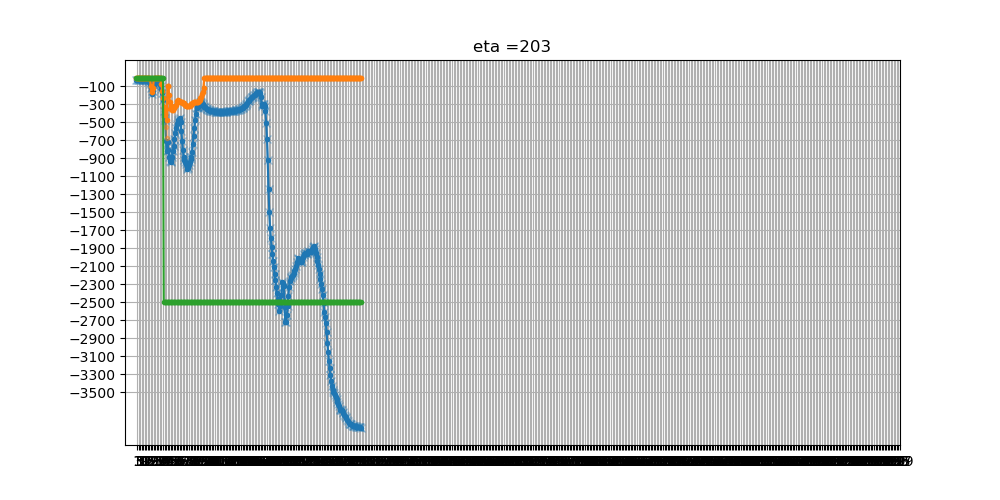

In [35]:
%matplotlib widget

plt.close('all')


fig,axs = plt.subplots(ncols=3,figsize=(14,5),sharex=True,sharey=True)
im=axs[0].pcolormesh(grd_rx0_post)
rx0_flat = grd_rx0_post.ravel().round(1)
ind = np.argpartition(rx0_flat,-10)[-10:]
ind
for where in ind: 
    w_j,w_i=np.unravel_index(where,grd_rx0_post.shape)
    axs[0].plot(w_i,w_j,'ro')
    axs[0].text(w_i,w_j,rx0_flat[where])
axs[0].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[0])
axs[0].contour(mmm,levels=((0,1)),colors='C1')
im=axs[1].pcolormesh((hhh+zzz)*mmmNaN,vmax=150)
axs[1].set_title('wct')
axs[1].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[1])
axs[1].contour(mmm,levels=((0,1)),colors='C1')
im=axs[2].pcolormesh(hhh,vmin=-250)
axs[2].set_title('bathy')
axs[2].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[2])
axs[2].contour(mmm,levels=((0,1)),colors='C1')


fig,axs = plt.subplots(ncols=3,figsize=(14,5),sharex=True,sharey=True)
im=axs[0].pcolormesh(grd_rx1_post)
rx1_flat = grd_rx1_post.ravel().round(1)
ind = np.argpartition(rx1_flat,-10)[-10:]
ind
for where in ind: 
    w_j,w_i=np.unravel_index(where,grd_rx1_post.shape)
    axs[0].plot(w_i,w_j,'ro')
    axs[0].text(w_i,w_j,rx1_flat[where])
axs[0].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[0])
axs[0].contour(mmm,levels=((0,1)),colors='C1')
im=axs[1].pcolormesh((hhh+zzz)*mmmNaN,vmax=250)
axs[1].set_title('wct')
axs[1].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[1])
axs[1].contour(mmm,levels=((0,1)),colors='C1')
im=axs[2].pcolormesh(zzz,vmin=-550)
axs[2].set_title('zzz')
axs[2].set_yticks(np.arange(1.5,750.5,2),np.arange(1,750,2))
fig.colorbar(im,ax=axs[2])
axs[2].contour(mmm,levels=((0,1)),colors='C1')


# look along a single xi value
lookAtX=29
fig = plt.figure(figsize=(10,5))
plt.plot(-hhh[:,lookAtX],'.-',color='C0')
plt.plot(-roms_tmp['bed'][:,lookAtX],'x-',color='C0',alpha=0.4)
plt.plot(zzz[:,lookAtX],'.-',color='C1')
plt.plot(roms_tmp['ice'][:,lookAtX],'x-',color='C1',alpha=0.4)
plt.plot(-1*mmm[:,lookAtX]*2500,'.-',color='C2')
plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
plt.yticks(np.arange(-3500,0,200))
plt.title('xi ='+str(lookAtX))
# plt.xlim(focusRange[2],focusRange[3])
plt.grid()

# look along a single eta value
lookAtE=203
fig = plt.figure(figsize=(10,5))
plt.plot(-hhh[lookAtE,:],'.-',color='C0')
plt.plot(-roms_tmp['bed'][lookAtE,:],'x-',color='C0',alpha=0.4)
plt.plot(zzz[lookAtE,:],'.-',color='C1')
plt.plot(roms_tmp['ice'][lookAtE,:],'.-',color='C1',alpha=0.4)
plt.plot(-1*mmm[lookAtE,:]*2500,'.-',color='C2')
plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
plt.yticks(np.arange(-3500,0,200))
plt.title('eta ='+str(lookAtE))
plt.grid()



In [36]:
plt.close('all')
%matplotlib inline

In [38]:
# Remove single cell water "lakes"


from contextlib import suppress

def compare_neighbors(arr):
# # test example:
# arr = np.array([[False, False, False, False, False, False],
#                 [False, True, False, True, False, False],
#                 [False, False, False, False, True, False],
#                 [True, False, False, True, True, False],
#                 [False, True, True, True, False, False],
#                 [False, True, False, True, False, False],
#                 [False, True, True, True, False, False]])

    comp_arr = np.full(arr.shape, False, dtype=bool)

    for (x, y), item in np.ndenumerate(arr):
        # print(x,y)
        # print(x,y,arr.shape[0],arr.shape[1])
        # print((x<arr.shape[0]) & (y<arr.shape[1]))
        if (x>0) & (y>0) & (x<arr.shape[0]-1) & (y<arr.shape[1]-1):
            # print(x,y)
            if (arr[x-1, y] != item) & (arr[x+1, y] != item) & (arr[x, y+1] != item) & (arr[x, y-1] != item):
                if (arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item):
                    comp_arr[x, y] = True # Isolated cells are set to True
                if ((arr[x-1, y-1] == item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] == item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] == item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] == item)):
                    comp_arr[x, y] = True # find diagonal single cells
    return comp_arr


islands = compare_neighbors(mmm)

mmm_noSS = mmm.copy()

islandBehaviour = 'keep_islands' #'keep_islands' or 'remove_islands'
if islandBehaviour=='remove_islands':
    mmm_noSS[islands] = np.logical_not(mmm_noSS[islands]) # flip sign on only the islands
elif islandBehaviour=='keep_islands':
    mmm_noSS[islands] = np.full(mmm_noSS[islands].shape,False) # flip sign on only the islands



mmm = mmm_noSS

  
Minimum r-value =  0.0
Maximum r-value =  0.47850802540779114
Mean    r-value =  0.01947909783026367
Median  r-value =  0.008359086699783802


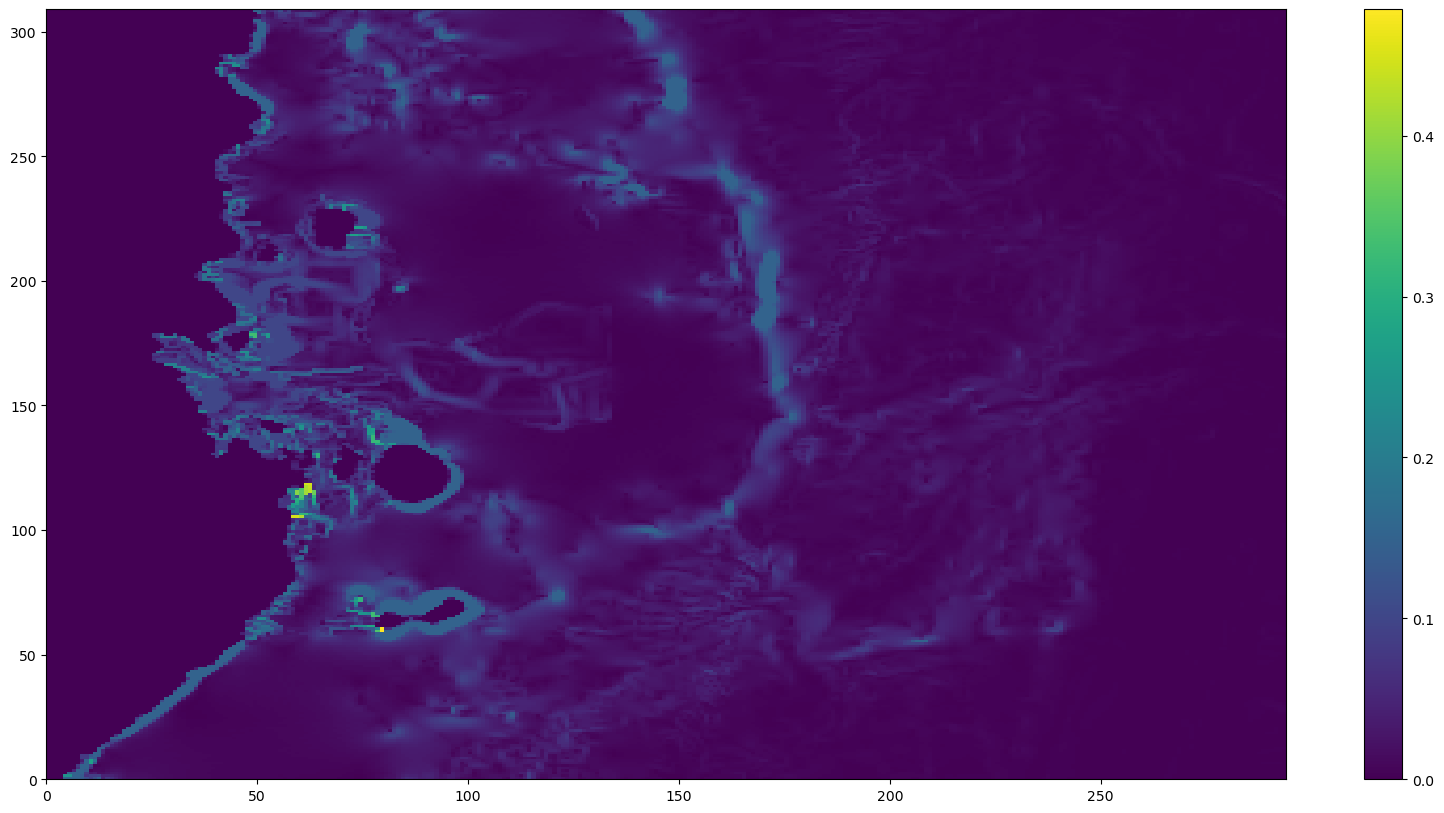

  
Minimum r-value =  0.0
Maximum r-value =  154.30531706752615
Mean    r-value =  4.516501782919679
Median  r-value =  1.1472584407283157


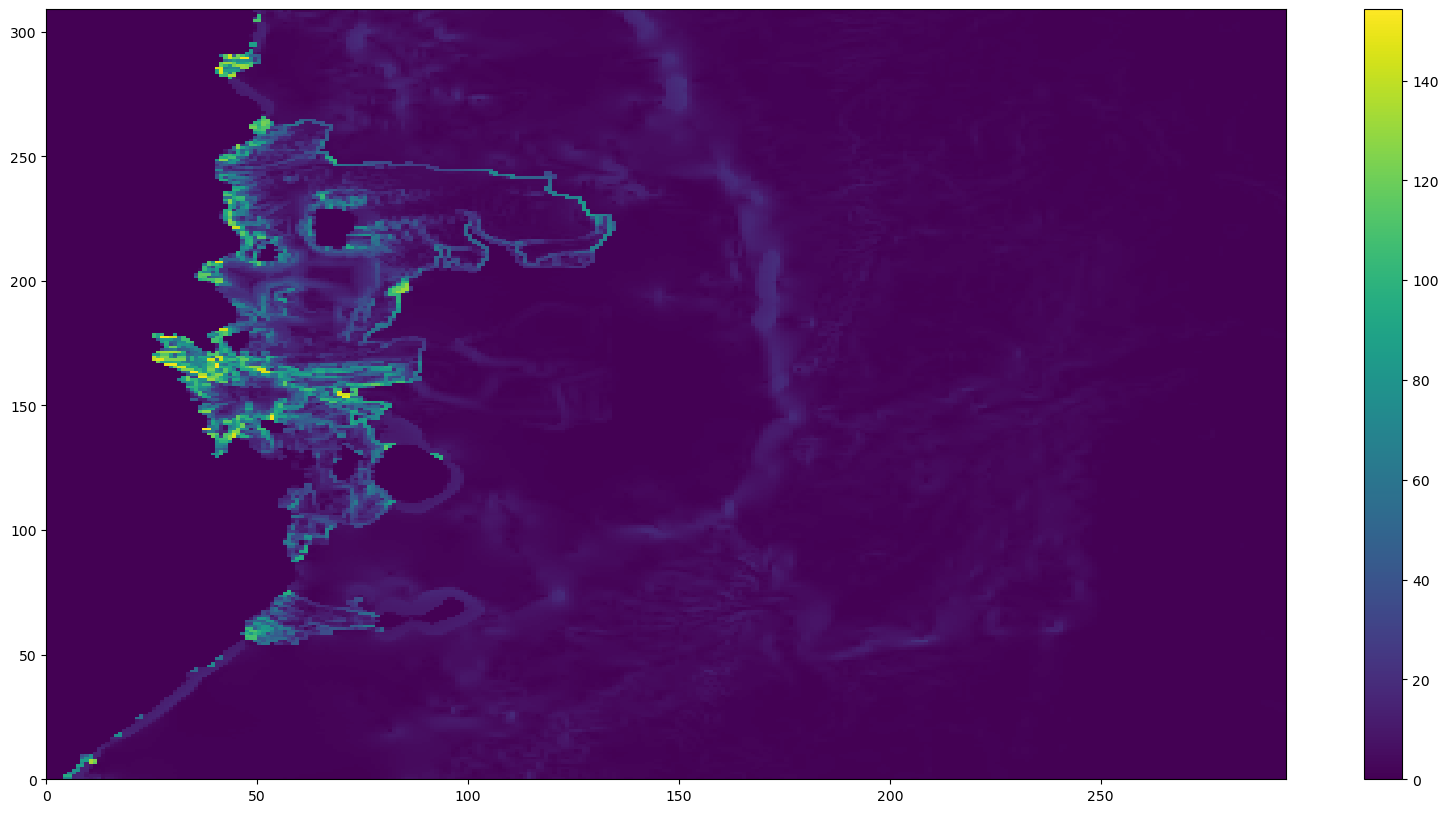

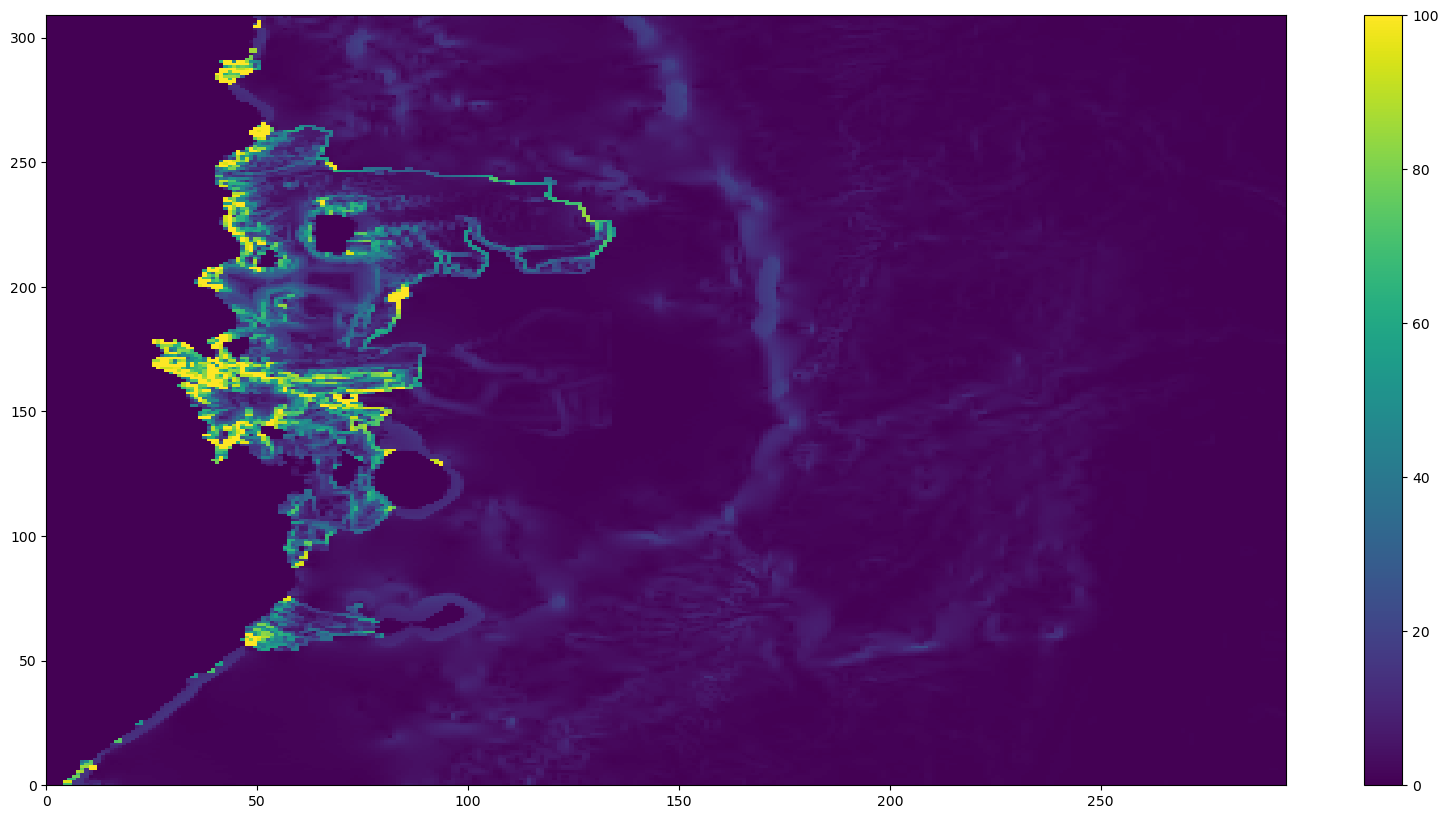

In [39]:
# Now check post-manual editing rx values

%matplotlib inline

z_rho_postManualEdits,z_w_postManualEdits,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh,zzz)
plt.close('all')
fig = plt.figure(figsize=(20,10))
grd_rx0_postManualEdits=GridStiffness.rx0(hhh,mmm)
plt.pcolormesh(grd_rx0_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
grd_rx1_postManualEdits=GridStiffness.rx1(z_w_postManualEdits,mmm)
plt.pcolormesh(grd_rx1_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
plt.pcolormesh(grd_rx1_postManualEdits,vmin=0,vmax=100)
plt.colorbar()
plt.show()

In [40]:
# interannual_coverage_cutoff = 0.5 # Interannual persistence: at least this fractional% required over 2000-2018 monthly climatology to be considered as ice.
# annual_coverage_cutoff = 0.9 # Annual persistence: at least this fractional % required over the year to be considered as ice

# filelist= glob.glob(data_dir+'/raw/adf_fastice/'+'FastIce*.nc')
# for file in filelist:
#     fi_singlefile = xr.open_dataset(filelist)
#     fi_full = fi_singlefile.drop(['x','y','area','date_alt'])

#     # make the fast ice mask data array
#     fi = (fi_full.Fast_Ice_Time_series==4) | (fi_full.Fast_Ice_Time_series==5) | (fi_full.Fast_Ice_Time_series==6)
    
#     # # check that i'm adding all the required fields
#     # (((fi - fi_full.Fast_Ice_Time_series==4) - fi_full.Fast_Ice_Time_series==5) - fi_full.Fast_Ice_Time_series==6).isel(time=10).plot()


#     fi_clima = fi.groupby('time.month').mean() #make the monthly climatology
#     # # check that the mean is working
#     # (fi.groupby('time.month').mean()>0.5).isel(month=2).plot()
#     # plt.contour((fi.groupby('time.month').mean()).isel(month=2),[0.5],linewidths=0.5,colors='k')
#     # plt.show()
#     # (fi.groupby('time.month').mean()).isel(month=2).plot()
#     # plt.contour((fi.groupby('time.month').mean()).isel(month=2),[0.5],linewidths=0.5,colors='k')


#     fi_mean_interannual = (fi_clima>=interannual_coverage_cutoff).mean(dim='month')

#     fi_mean_annual = fi_mean_interannual>=annual_coverage_cutoff

In [41]:
# add fast ice

# fi_fulldata = xr.open_mfdataset(data_dir+'/raw/adf_fastice/'+'*.nc') # load full fast ice data set
fi_fulldata = xr.open_mfdataset(data_dir+'/raw/adf_fastice/'+'FastIce_70_200[0-2].nc',data_vars='different') # load full fast ice data set, don't concat similar datavars (e.g. lon)

fi_full = fi_fulldata.drop(['x','y','area','date_alt'])
# fi_full = fi_full_coordCorrected

fi_full.nbytes/1e9

2.009250544

In [42]:
fi_full

<xarray.Dataset>
Dimensions:               (Y: 4700, X: 5625, time: 68)
Coordinates:
  * time                  (time) datetime64[ns] 2000-03-01 ... 2002-12-12
Dimensions without coordinates: Y, X
Data variables:
    latitude              (Y, X) float32 dask.array<chunksize=(4700, 5625), meta=np.ndarray>
    longitude             (Y, X) float32 dask.array<chunksize=(4700, 5625), meta=np.ndarray>
    Fast_Ice_Time_series  (time, Y, X) int8 dask.array<chunksize=(20, 4700, 5625), meta=np.ndarray>
Attributes:
    title:        Fast ice time series
    institution:  Institute for Marine and Antarctic Studies, University of T...
    source:       MODIS 15-day composite images and automated edge detection
    history:      Version 2.2
    references:   Fraser et al., 2020 (Earth System Science Data, submitted)
    comment:      This is the lat_ts=-70 version of the data - year 2000
    contact:      Alex Fraser (adfraser@utas.edu.au)
    Conventions:  CF-1.7

In [43]:
interannual_coverage_cutoff = 0.5 # Interannual persistence: at least this fractional% required over 2000-2018 monthly climatology to be considered as ice.
annual_coverage_cutoff = 0.8 # Annual persistence: at least this fractional % required over the year to be considered as fast ice

fi = (fi_full.Fast_Ice_Time_series==4) | (fi_full.Fast_Ice_Time_series==5) | (fi_full.Fast_Ice_Time_series==6) # make the fast ice mask data array
# # check that i'm adding all the required fields
# (((fi - fi_full.Fast_Ice_Time_series==4) - fi_full.Fast_Ice_Time_series==5) - fi_full.Fast_Ice_Time_series==6).isel(time=10).plot()


fi_clima = fi.groupby('time.month').mean() #make the monthly climatology
# # check that the mean is working
# (fi.groupby('time.month').mean()>0.5).isel(month=2).plot()
# plt.contour((fi.groupby('time.month').mean()).isel(month=2),[0.5],linewidths=0.5,colors='k')
# plt.show()
# (fi.groupby('time.month').mean()).isel(month=2).plot()
# plt.contour((fi.groupby('time.month').mean()).isel(month=2),[0.5],linewidths=0.5,colors='k')


fi_mean_interannual = (fi_clima>=interannual_coverage_cutoff).mean(dim='month')

fi_mean_annual = fi_mean_interannual>=annual_coverage_cutoff




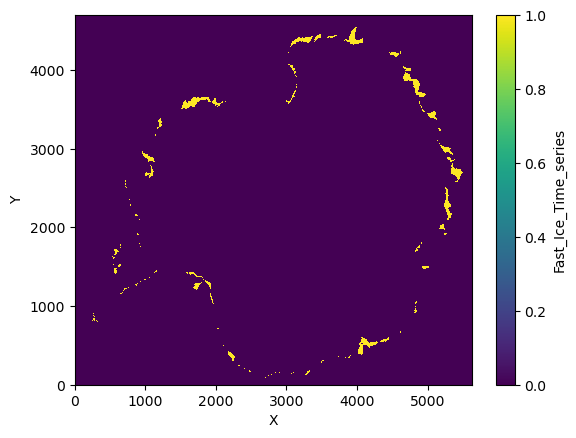

In [44]:
# now map the fast ice data to the model grid
fi_mean_annual.plot()

# interp (nearest) to the model lat/lon

fi_mean_annual_i = griddata((fi_full['longitude'].values.flatten(),fi_full['latitude'].values.flatten()),fi_mean_annual.values.flatten(),(lon_rho,lat_rho),'nearest')


### add fast ice

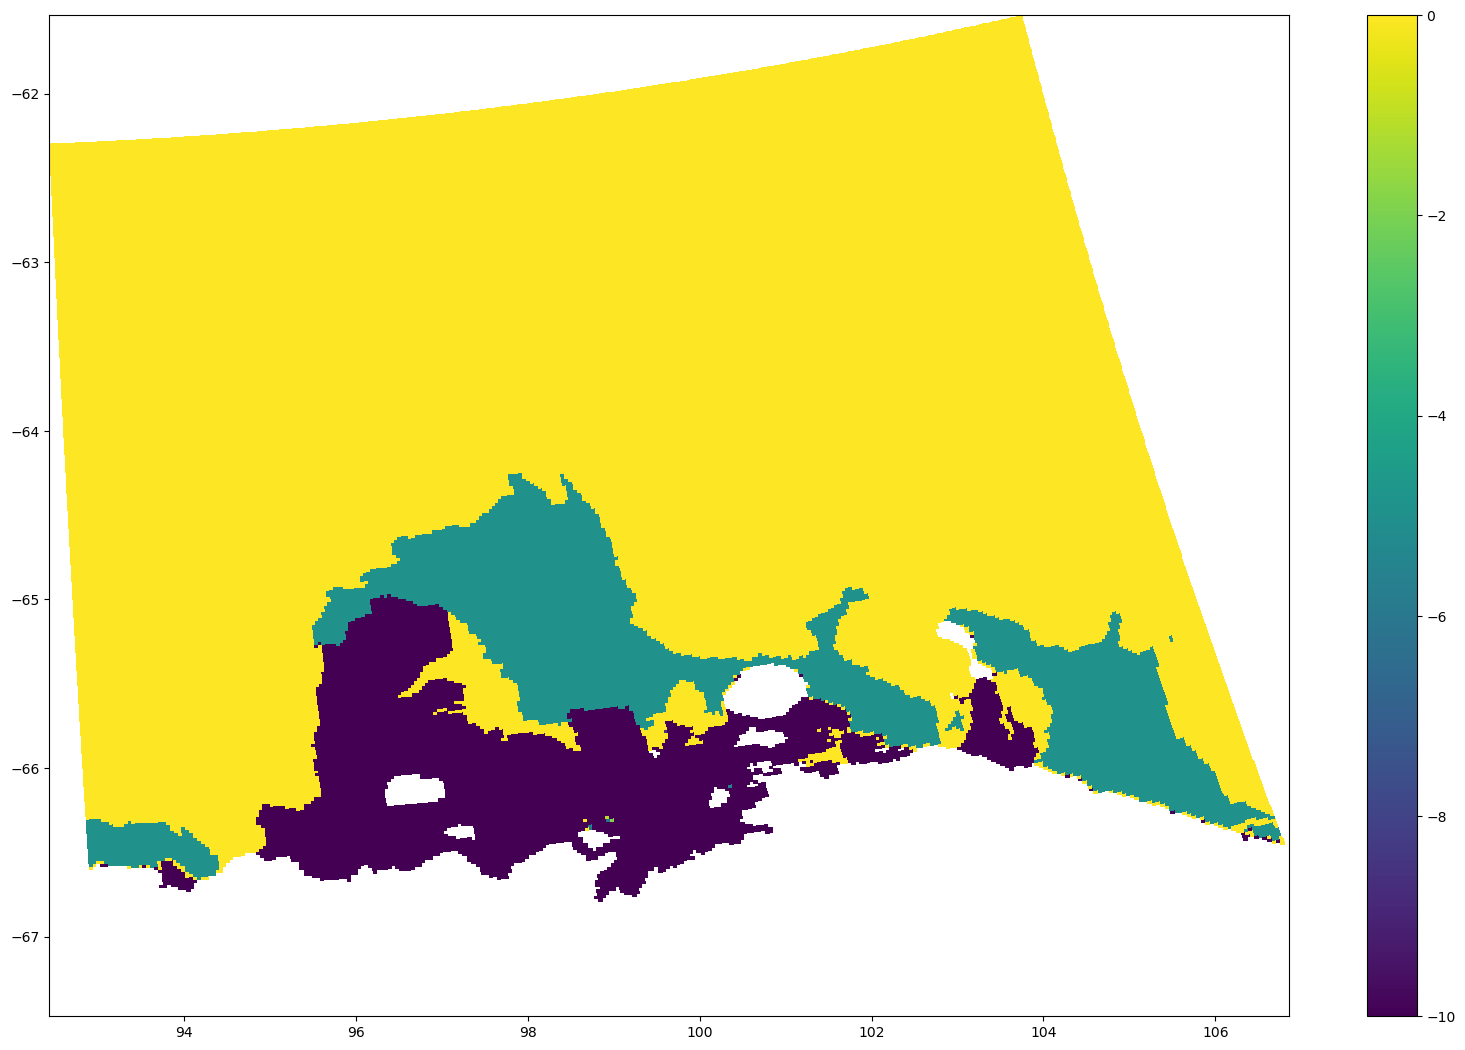

In [45]:
addFastIceFromSat=True
if addFastIceFromSat:

    # for fast ice alter the zice.
    fastice_draft = -5 #m below surface, negative downwards
    zzz_test = zzz.copy()
    mmm_test = mmm.copy()
    zzz_test[(fi_mean_annual_i==1) & (zzz==0) & (mmm==1)] = fastice_draft
    hhh_test = hhh.copy()

    # also add any missing fast ice fill
    # zzz_test[(mask_fasticefill==1) & (zzz==0) & (mmm==1)] = fastice_draft


    # # for icebergs, assume fully grounded.
    # zzz_test[mask_icebergs==1] = min_depth-hhh_test[mask_icebergs] # set ice to be min depth above bathy,
    # mmm_test[mask_icebergs==1] = 0                                  # and remove from water, i.e. grounded.

    mmmNaN = mmm.copy().astype('float')
    mmmNaN[mmmNaN == 0] = np.NaN

    fig = plt.figure(figsize=(20,13))
    plt.pcolormesh(lon_rho,lat_rho,zzz_test*mmmNaN,vmin=-10,vmax=0)
    plt.colorbar()
    plt.show()
    # fig = plt.figure(figsize=(20,13))
    # plt.pcolormesh(lon_rho,lat_rho,mmm_test)
    # plt.show()

#### correct fast ice gaps

Interactive plot setup complete. Click to select points.


Button(description='Finish Selection', style=ButtonStyle())

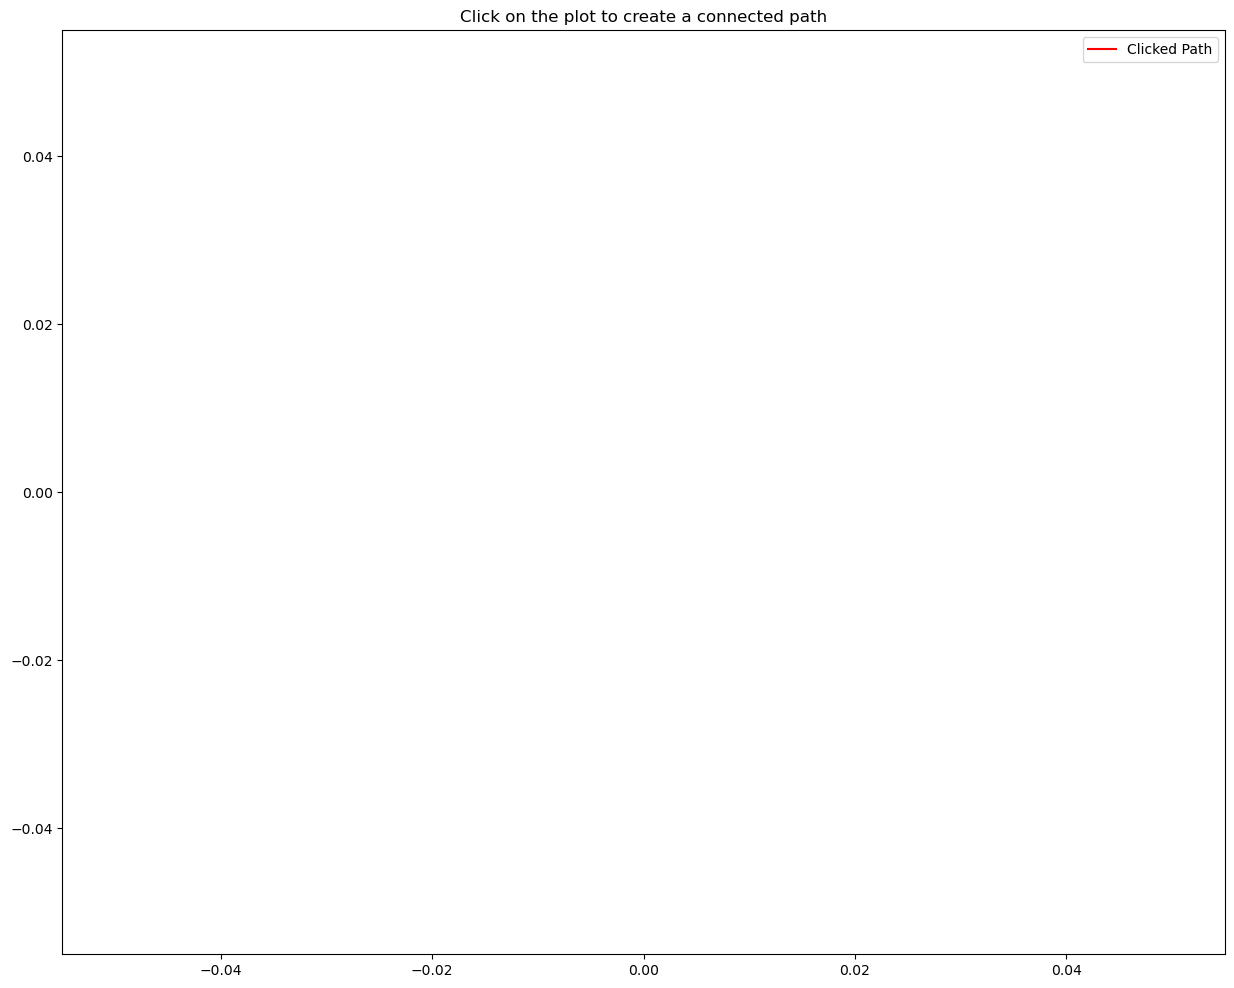

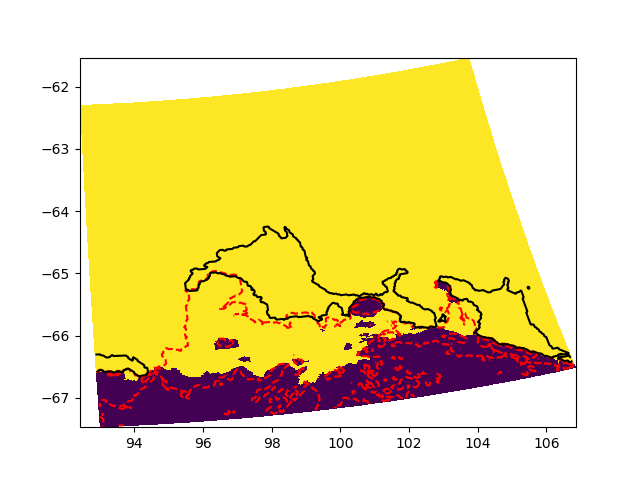

In [46]:
interactive_plot_and_select_points()

# Step 2: Add your custom plots here
%matplotlib widget
plt.pcolormesh(lon_rho,lat_rho,mmm)
plt.contour(lon_rho,lat_rho,zzz,levels=[-1,0],colors='r')

plt.contour(lon_rho,lat_rho,fi_mean_annual_i,colors='k')


# interactive_plot_and_select_points()

# # Step 2: Add your custom plots here
# # ax.pcolormesh(lon_rho,lat_rho,mmm)
# # ax.contour(lon_rho,lat_rho,zzz,levels=[-1,0],colors='r')

# # ax.contour(lon_rho,lat_rho,fi_mean_annual_i,colors='k')
# ax.pcolormesh(lon_rho,lat_rho,zzz_test*mmmNaN,vmin=-10,vmax=0)

# # Step 3: Post-plotting to finalize and get the clicked points
# # clicked_points_array = post_plotting()

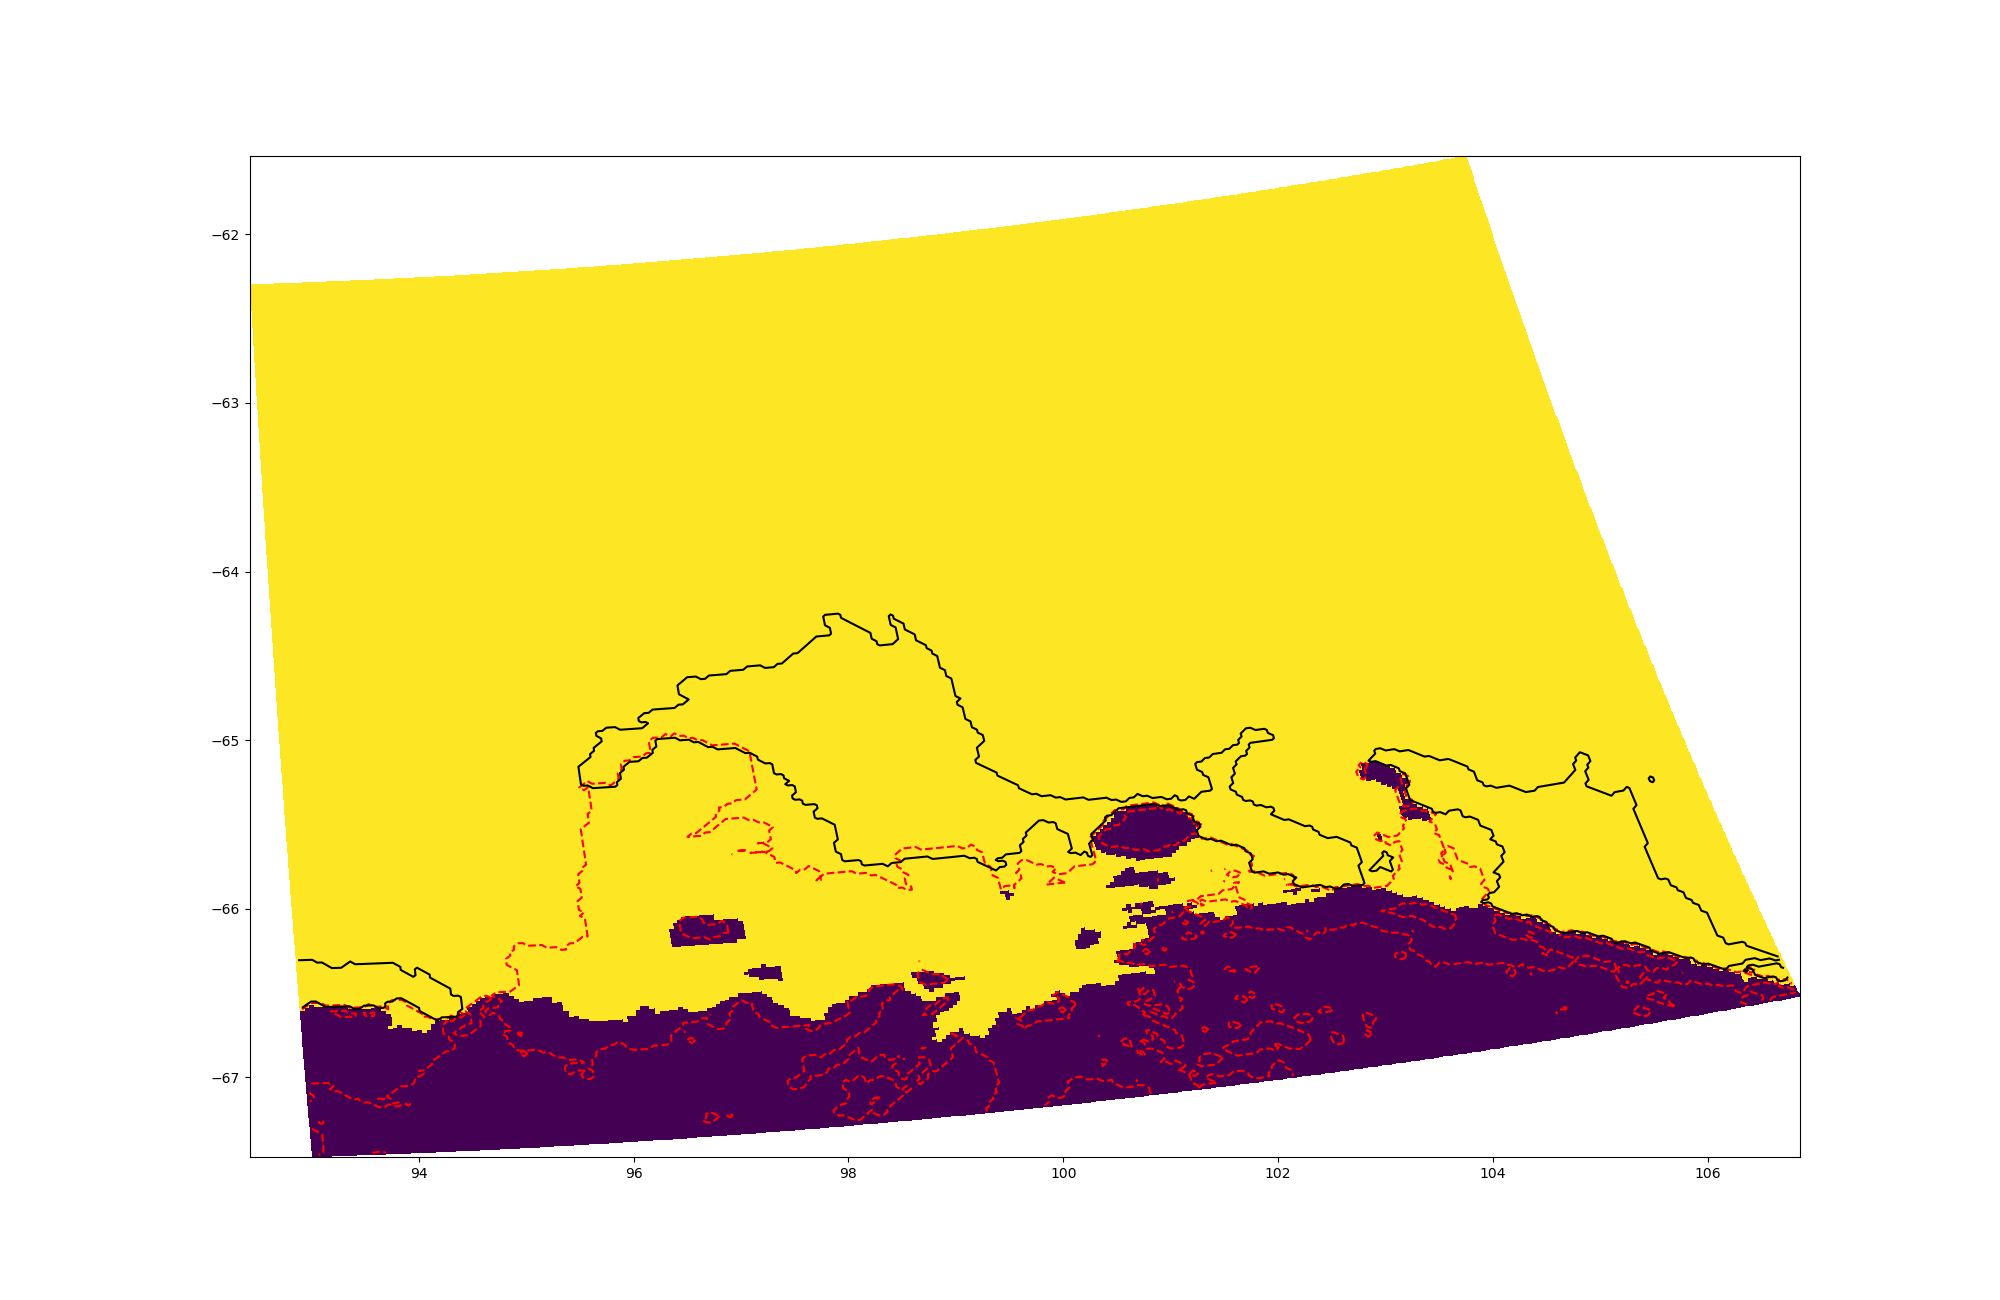

In [47]:
%matplotlib widget
fig = plt.figure(figsize=(20,13))
plt.pcolormesh(lon_rho,lat_rho,mmm)
plt.contour(lon_rho,lat_rho,zzz,levels=[-1,0],colors='r')

plt.contour(lon_rho,lat_rho,fi_mean_annual_i,colors='k')

In [48]:


add_fasticefill = np.array([
 (92.794880665, -66.688639169),
 (92.782468028, -66.476588044),
 (93.353449345, -66.483013836),
 (93.936843299, -66.502291211),
 (94.284397144, -66.592252294),
 (94.756077363, -66.560123336),
 (94.694014176, -66.842858169),
 (93.080371324, -66.759322877)
])

add_fasticefill2 = np.array([
 (96.804162521, -65.075765461),
 (97.226192191, -64.953675419),
 (98.033013617, -65.409906627),
 (98.703296032, -65.487016127),
 (99.621831195, -65.377777669),
 (100.130749325, -65.422758211),
 (100.676905367, -65.352074502),
 (101.285124596, -65.364926086),
 (101.645091079, -65.544848252),
 (102.625689427, -65.795454127),
 (102.749815801, -65.956098919),
 (101.458901519, -66.155298461),
 (100.974808663, -66.399478544),
 (99.187388888, -66.881412919),
 (97.983363067, -66.772174461),
 (95.724263074, -66.707916544),
 (95.053980659, -66.637232836),
 (96.022166370, -66.071763169),
 (96.307657028, -65.191429711)
])

add_fasticefill3 = np.array([
 (102.625689427, -65.660512502),
 (102.998068547, -65.583403002),
 (103.432510854, -65.615531961),
 (103.246321294, -65.429184002),
 (103.022893822, -65.210707086),
 (102.873942174, -65.146449169),
 (103.010481185, -65.095042836),
 (103.866953160, -65.364926086),
 (104.425521840, -65.692641461),
 (104.686187224, -65.936821544),
 (105.617135023, -66.155298461),
 (106.063989967, -66.213130586),
 (106.461194361, -66.277388502),
 (106.721859745, -66.303091669),
 (106.796335569, -66.399478544),
 (106.759097657, -66.476588044),
 (106.374305900, -66.450884877),
 (104.326220741, -66.161724252),
 (102.898767449, -65.981802086),
 (102.600864153, -65.943247336),
 (101.930581737, -65.930395752),
 (101.136172948, -65.602680377),
 (101.111347674, -65.506293502),
 (101.769217452, -65.480590336),
 (102.402261956, -65.692641461)
])

add_fasticefill4 = np.array([
 (105.828149858, -66.386626961),
 (106.250179527, -66.238833752),
 (106.448781724, -66.264536919),
 (106.783922932, -66.309517461),
 (106.833573481, -66.438033294),
 (106.845986118, -66.553697544),
 (105.840562495, -66.476588044)
])


mask_fasticefill = inpolygon(lon_rho, lat_rho,add_fasticefill[:,0], add_fasticefill[:,1])
mask_fasticefill2 = inpolygon(lon_rho, lat_rho,add_fasticefill2[:,0], add_fasticefill2[:,1])
mask_fasticefill3 = inpolygon(lon_rho, lat_rho,add_fasticefill3[:,0], add_fasticefill3[:,1])
mask_fasticefill4 = inpolygon(lon_rho, lat_rho,add_fasticefill4[:,0], add_fasticefill4[:,1])

mask_fasticefill = mask_fasticefill | mask_fasticefill2 | mask_fasticefill3  | mask_fasticefill4

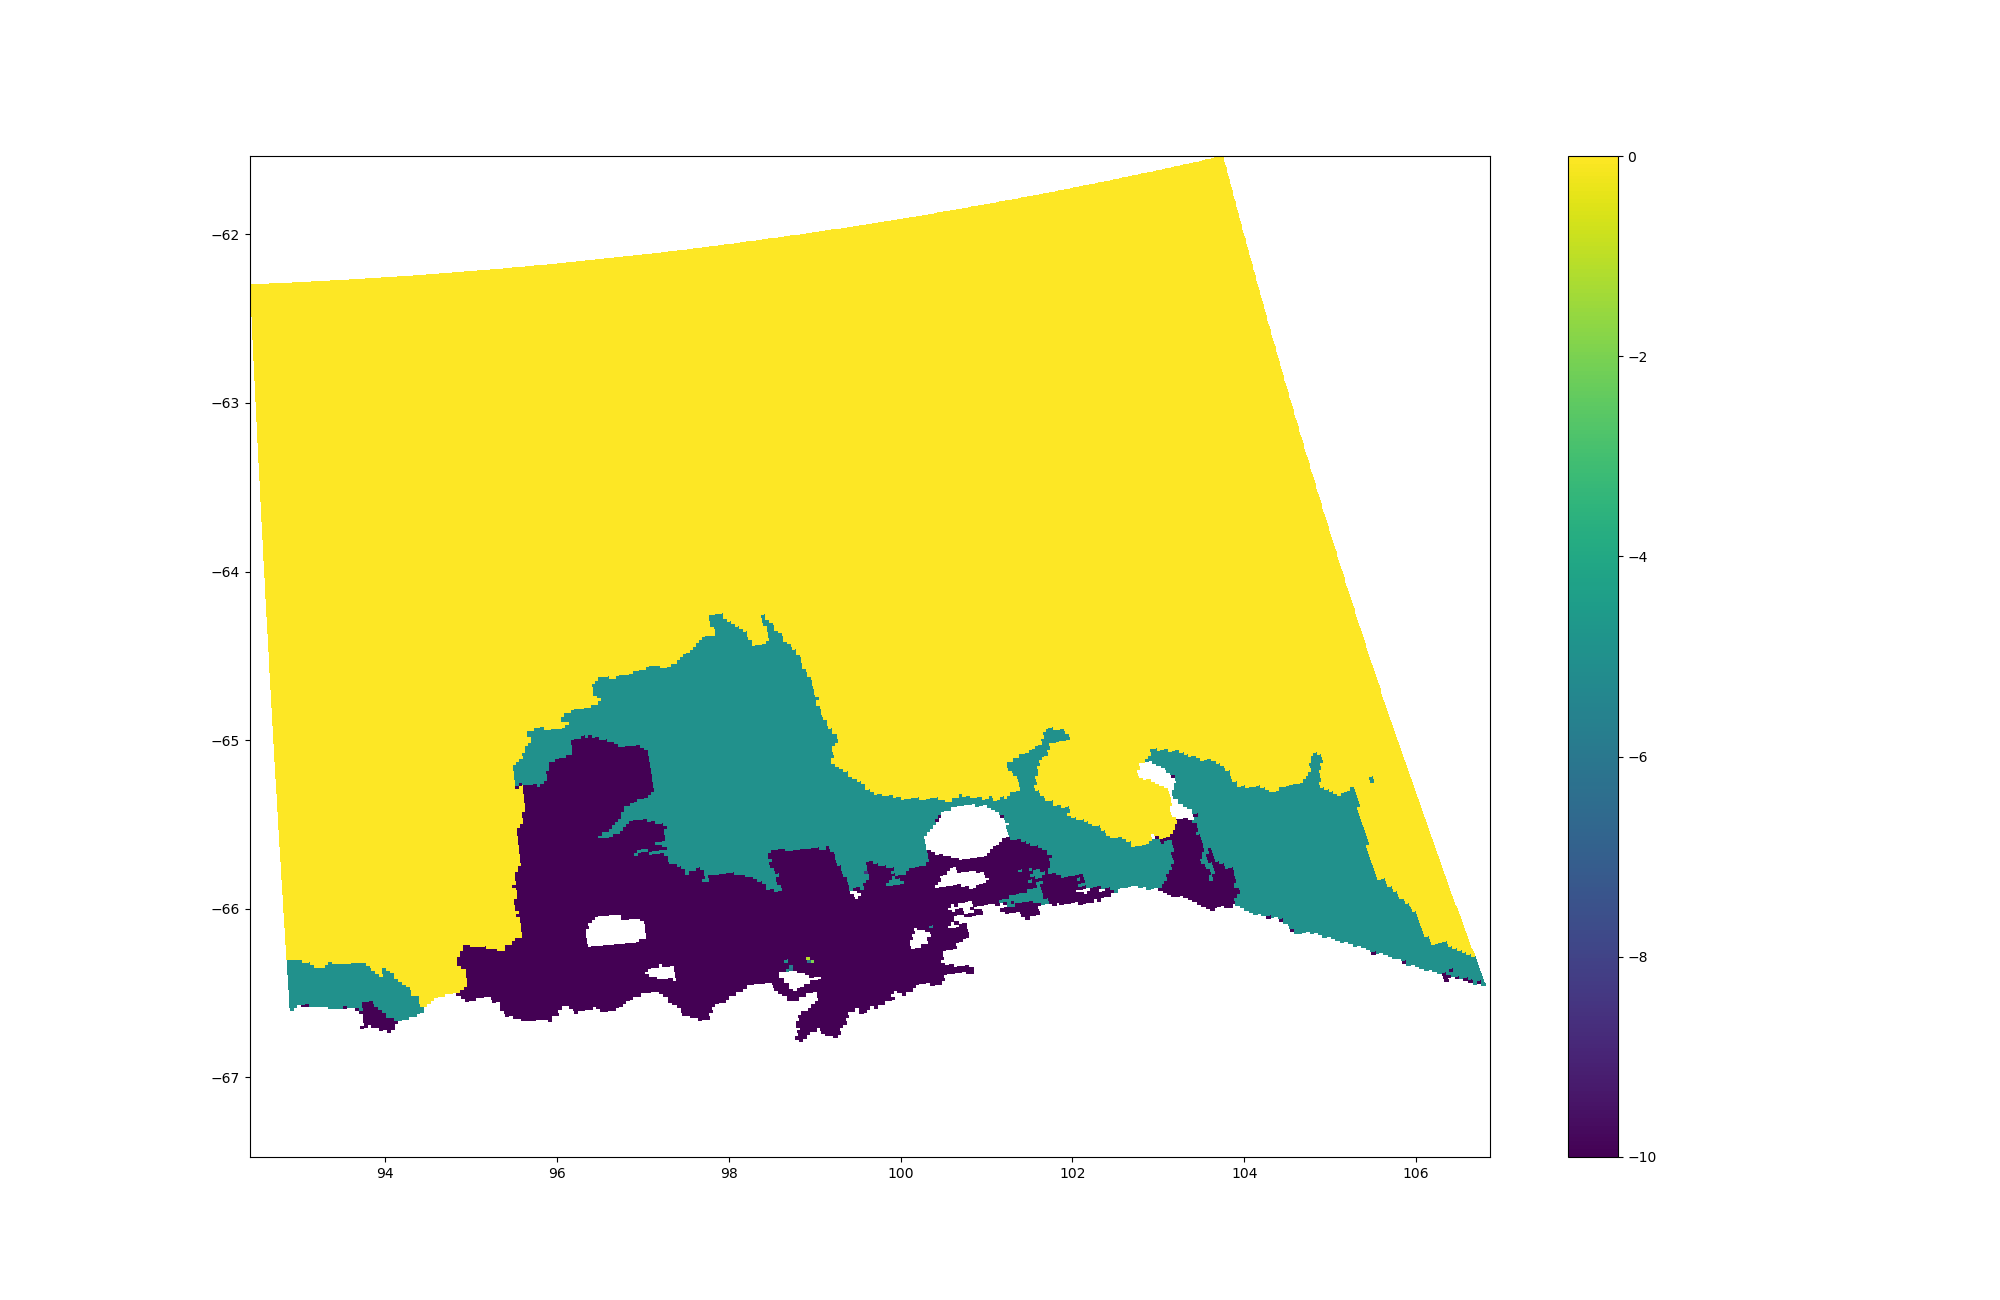

In [49]:
addFastIceCorrections=True
if addFastIceCorrections:

    # for fast ice alter the zice.
    fastice_draft = -5 #m below surface, negative downwards

    # also add any missing fast ice fill
    zzz_test[(mask_fasticefill==1) & (zzz==0) & (mmm==1)] = fastice_draft


    mmmNaN = mmm.copy().astype('float')
    mmmNaN[mmmNaN == 0] = np.NaN

    fig = plt.figure(figsize=(20,13))
    plt.pcolormesh(lon_rho,lat_rho,zzz_test*mmmNaN,vmin=-10,vmax=0)
    plt.colorbar()
    plt.show()
    # fig = plt.figure(figsize=(20,13))
    # plt.pcolormesh(lon_rho,lat_rho,mmm_test)
    # plt.show()

### add ice bergs

In [50]:
addIceBergs=False
if addIceBergs:

    # add icebergs
    # download from https://apps.sentinel-hub.com/eo-browser/ (need log in)
    # download as a tif, georeferenced, high res, etc, Sentinel-1 AWS-EW-HHHV, HH-linear gamma0 - radiometric terrain, clip extra bands, note the coordinate system. e.g. WGS84 is EPSG:4326 
    import rioxarray

    S1b = rioxarray.open_rasterio('../data/raw/Sentinel/2023-05-01-00 00_2023-05-01-23 59_Sentinel-1_AWS-EW-HHHV_HH_-_linear_gamma0_-_radiometric_terrain_corrected.tiff')

    interactive_plot_and_select_points()

    %matplotlib widget
    # Step 2: Add your custom plots here
    ax.pcolormesh(S1b.x,S1b.y,S1b.isel(band=0).values)



In [51]:
if addIceBergs:
    
    d12=np.array([
    [81.89,-66.246],
    [82.07,-66.309],
    [82.11,-66.396],
    [82.24,-66.469],
    [82.23,-66.513],
    [82.42,-66.576],
    [82.52,-66.746],
    [82.56,-66.906],
    [82.58,-67.023],
    [82.42,-67.047],
    [82.49,-67.071],
    # [82.19,-67.091],
    [82.33,-67.11],
    [81.79,-67.173],
    [81.45,-67.100],
    [81.79,-67.178],
    [81.40,-67.086],
    [81.36,-66.989],
    [81.22,-66.935],
    [81.29,-66.887],
    [81.14,-66.824],
    [81.05,-66.726],
    [81.14,-66.707],
    [81.32,-66.697],
    [81.35,-66.615],
    [81.37,-66.552],
    [81.26,-66.522],
    [81.30,-66.484],
    [81.24,-66.435],
    [81.25,-66.372],
    [81.20,-66.343],
    [81.40,-66.270 ]
    ])


    mask_icebergs = inpolygon(lon_rho, lat_rho,d12[:,0], d12[:,1])


    # for icebergs, assume fully grounded.
    zzz_test[mask_icebergs==1] = min_depth-hhh_test[mask_icebergs] # set ice to be min depth above bathy,
    mmm_test[mask_icebergs==1] = 0                                  # and remove from water, i.e. grounded.

    mmmNaN = mmm.copy().astype('float')
    mmmNaN[mmmNaN == 0] = np.NaN



    fig,ax=plt.subplots(figsize=(15,10))
    im = ax.pcolormesh(S1b.x,S1b.y,S1b.isel(band=0).values)
    plt.plot(d12[:,0],d12[:,1],'k')



    fig = plt.figure(figsize=(20,13))
    plt.pcolormesh(lon_rho,lat_rho,mmm)
    plt.contour(lon_rho,lat_rho,zzz,levels=np.array((-1,0)))

    plt.contour(lon_rho,lat_rho,fi_mean_annual_i,colors='k')
    plt.contour(lon_rho,lat_rho,mask_icebergs,colors='r')

In [52]:
# update with new fastice and iceberg geometry

zzz = zzz_test.copy()
mmm = mmm_test.copy()
hhh = hhh_test.copy()

  
Minimum r-value =  0.0
Maximum r-value =  0.47850802540779114
Mean    r-value =  0.01947909783026367
Median  r-value =  0.008359086699783802
  
Minimum r-value =  0.0
Maximum r-value =  154.30531706752615
Mean    r-value =  4.517981282972926
Median  r-value =  1.1530907160049906


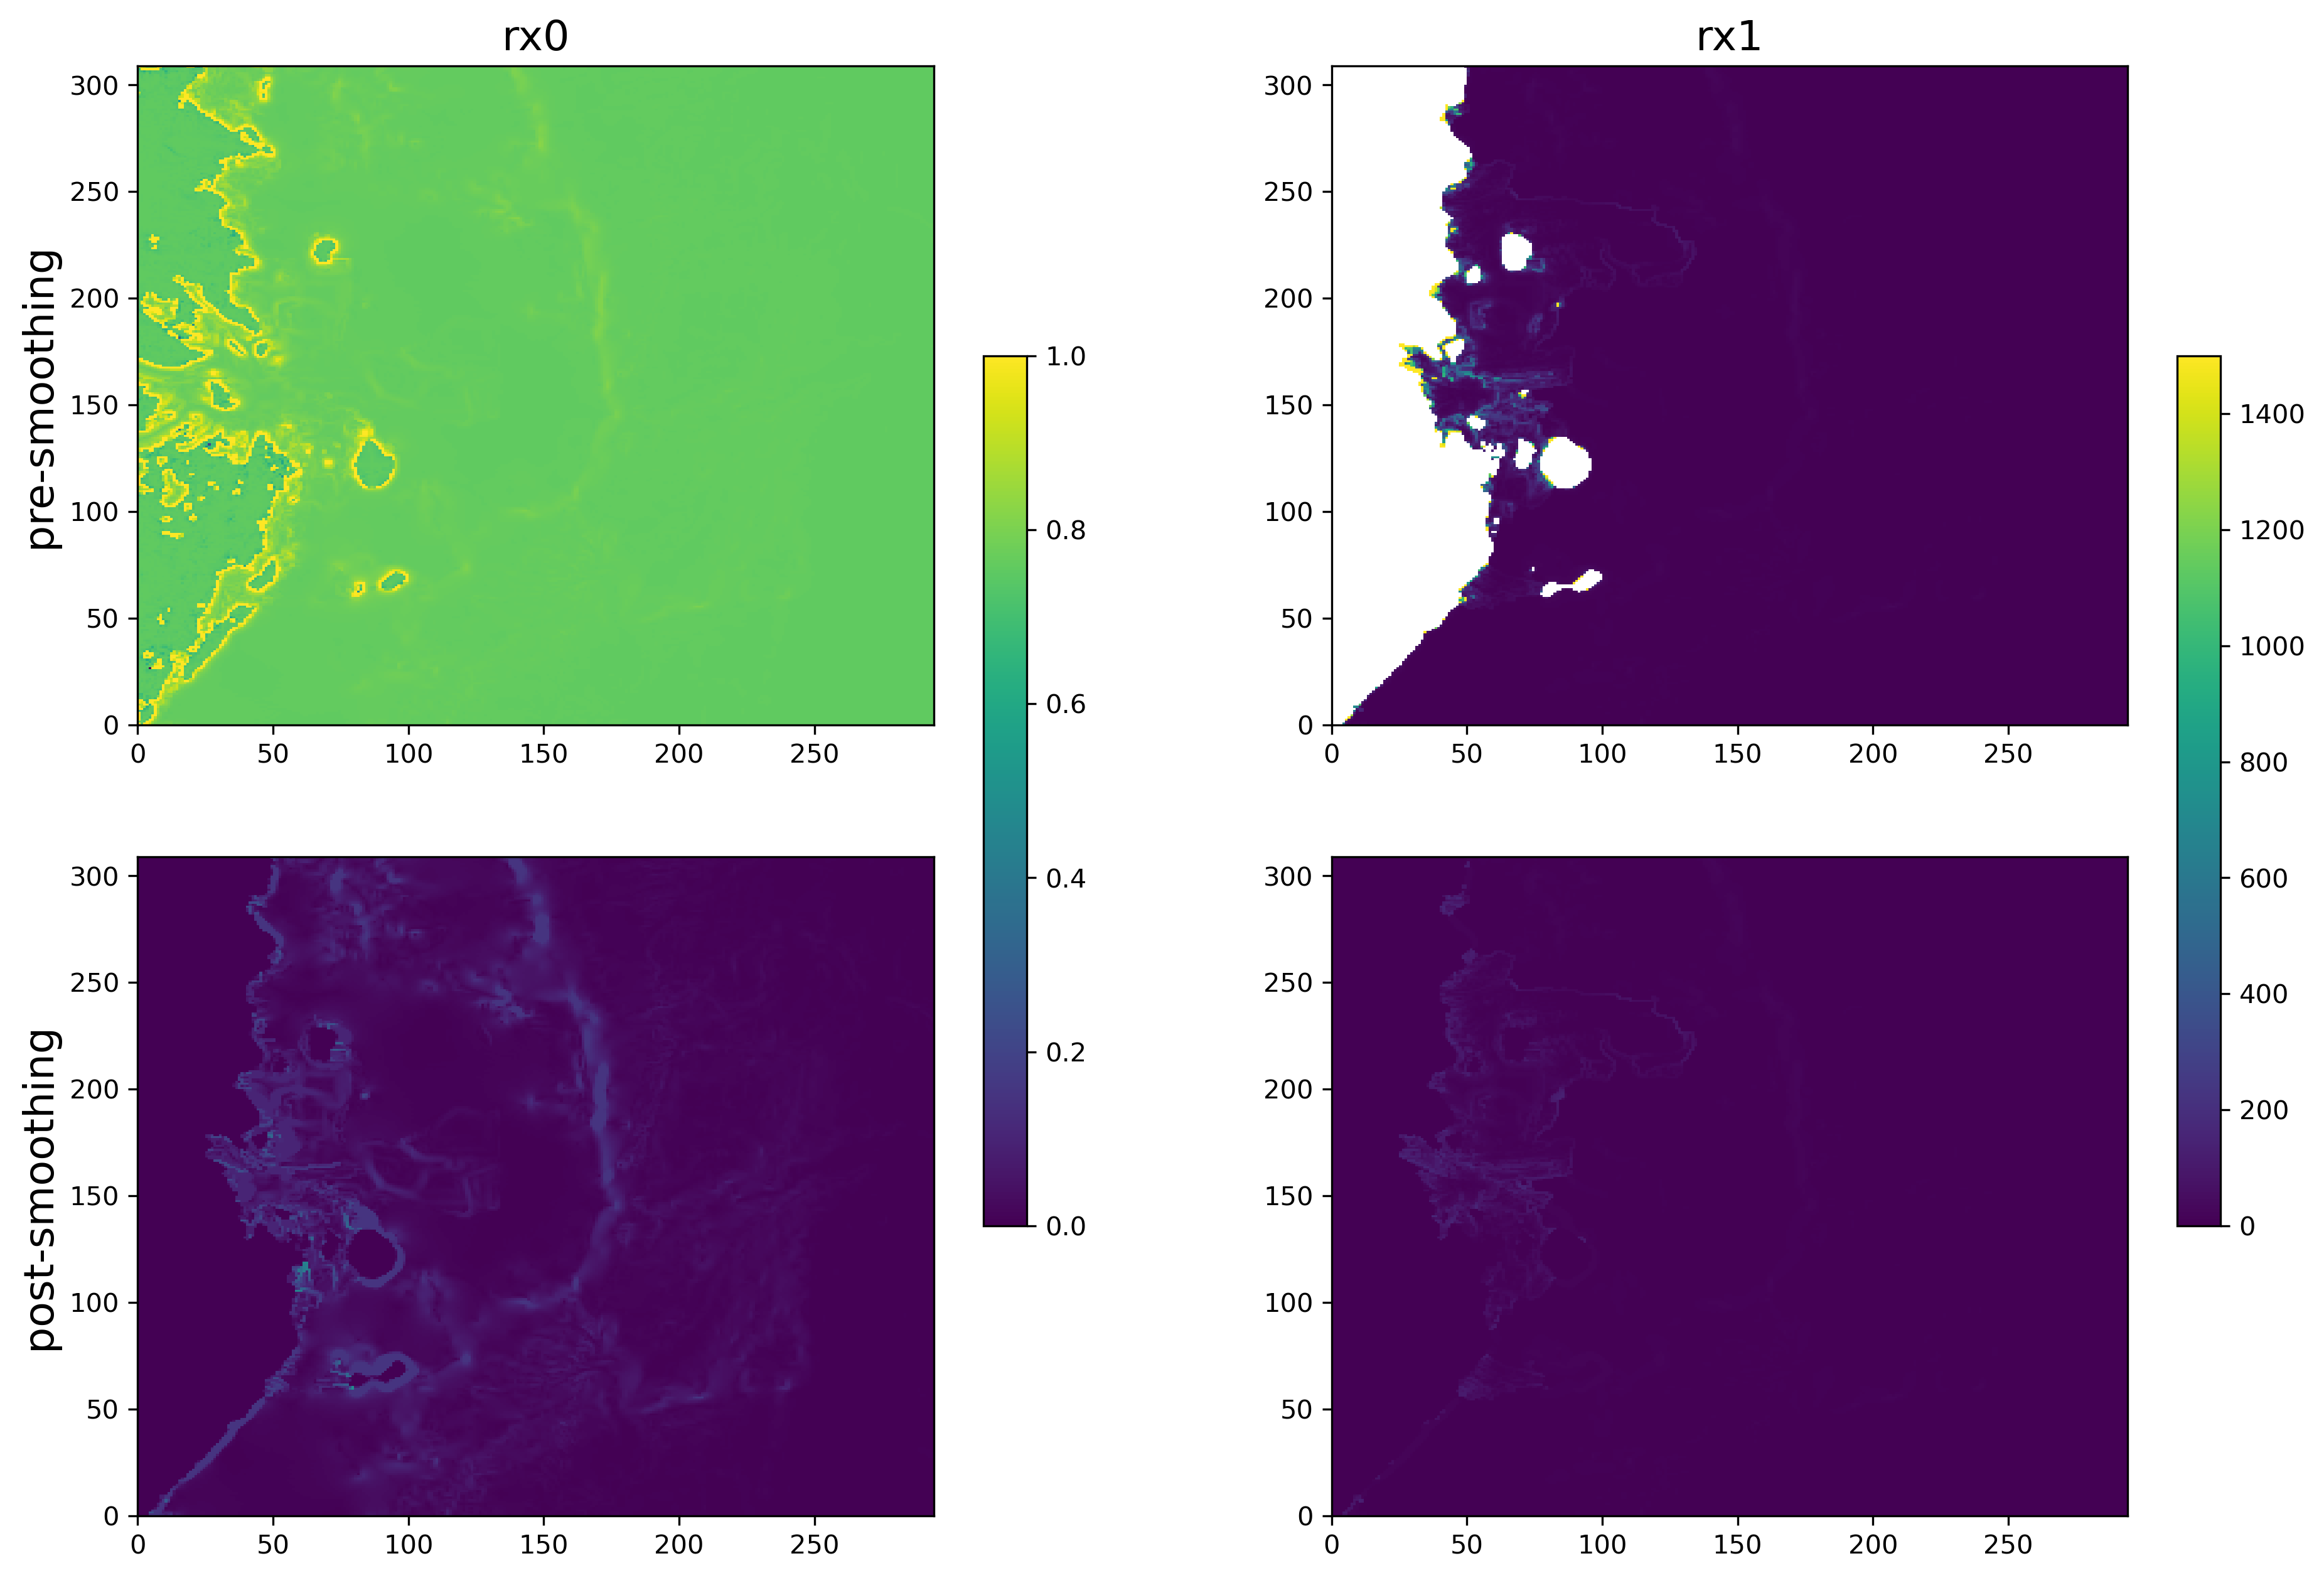

In [54]:
%matplotlib inline


z_rho_postManualEdits,z_w_postManualEdits,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh,zzz)
grd_rx0_postManualEdits=GridStiffness.rx0(hhh,mmm)
grd_rx1_postManualEdits=GridStiffness.rx1(z_w_postManualEdits,mmm)


plt.close('all')
fig,axs = plt.subplots(2,2,figsize=[15,10],dpi=300)

ax = axs[0,0]
ax.pcolormesh(grd_rx0_pre,vmax=1)
ax.set_title('rx0',fontsize=16)
ax.set_ylabel('pre-smoothing',fontsize=16)
ax = axs[0,1]
grd_rx1_pre[np.isnan(grd_rx1_pre)]=0
ax.pcolormesh(grd_rx1_pre,vmax=1500)
ax.set_title('rx1',fontsize=16)
ax = axs[1,0]
im=ax.pcolormesh(grd_rx0_postManualEdits,vmax=1)
plt.colorbar(im,ax=axs[:,0],shrink=0.6)
ax.set_ylabel('post-smoothing',fontsize=16)
ax = axs[1,1]
im=ax.pcolormesh(grd_rx1_postManualEdits,vmax=1500)
plt.colorbar(im,ax=axs[:,1],shrink=0.6)

plt.savefig('../out/pre_post_rxVals.png')

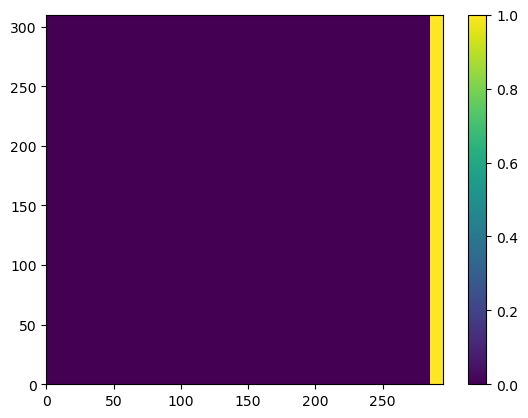

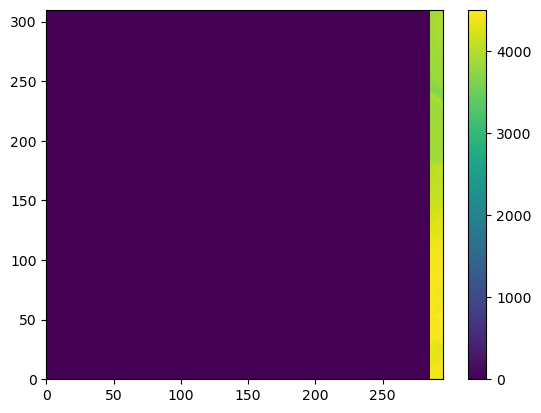

Old Max Roughness value is:  0.019331984221935272


DeltaBathymetry =  0.0
New Max Roughness value is:  0.019331984221935272


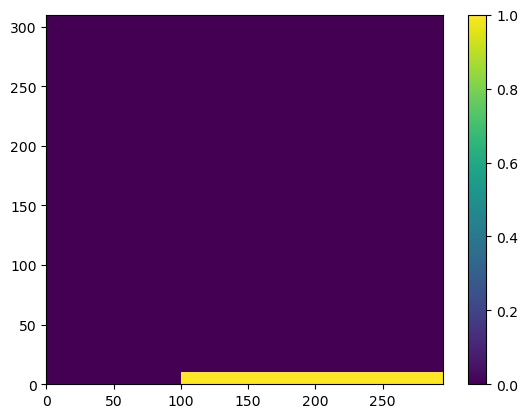

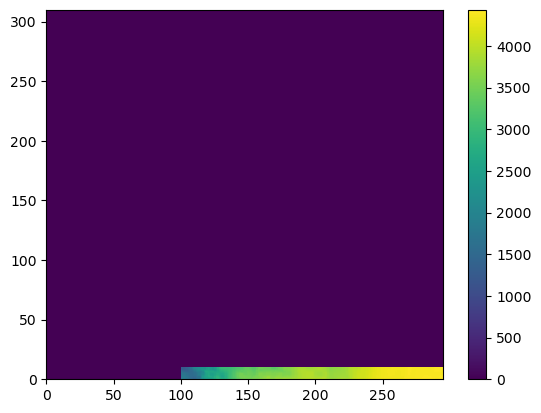

Old Max Roughness value is:  0.08784125745296478


DeltaBathymetry =  18640.72265625
New Max Roughness value is:  0.025005483999848366


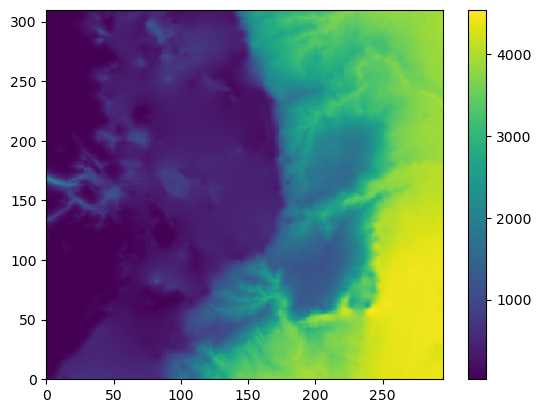

In [55]:
# border grid modifications
addBorderEdits=True
if addBorderEdits:

    # do some smoothing of the deep bathy on east bnd
    mask_eastbnd = np.zeros_like(hhh)
    mask_eastbnd[:,-10:]=True

    plt.pcolormesh(mask_eastbnd)
    plt.colorbar()
    plt.show()
    plt.pcolormesh(mask_eastbnd*hhh)
    plt.colorbar()
    plt.show()

    # smooth the wct
    rx0in = 0.03
    max_iter = 100
    Area = 1/(pm*pn)
    hhh_tmp = hhh.copy()
    hhh_tmp, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(mask_eastbnd,hhh_tmp,rx0in,Area,max_iter)


    # # do some replication of the southern boundary
    # for ii in range(1,5):
    #     hhh_tmp[ii,110:] = hhh_tmp[0,110:]



    # now do some smoothing of the deep bathy on south bnd
    mask_southbnd = np.zeros_like(hhh)
    mask_southbnd[:10,100:]=True

    plt.pcolormesh(mask_southbnd)
    plt.colorbar()
    plt.show()
    plt.pcolormesh(mask_southbnd*hhh)
    plt.colorbar()
    plt.show()

    # smooth the wct
    rx0in = 0.025
    max_iter = 100
    Area = 1/(pm*pn)
    hhh_tmp = hhh.copy()
    hhh_tmp, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(mask_southbnd,hhh_tmp,rx0in,Area,max_iter)




    plt.pcolormesh(hhh_tmp)
    plt.colorbar()
    plt.show()


In [56]:
if addBorderEdits:
    hhh = hhh_tmp

restore any min_wct which have been affected by new fast ice


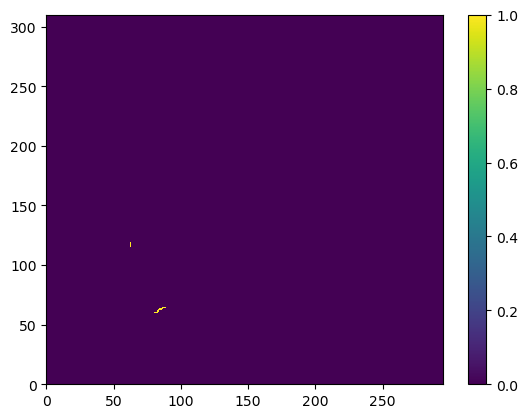

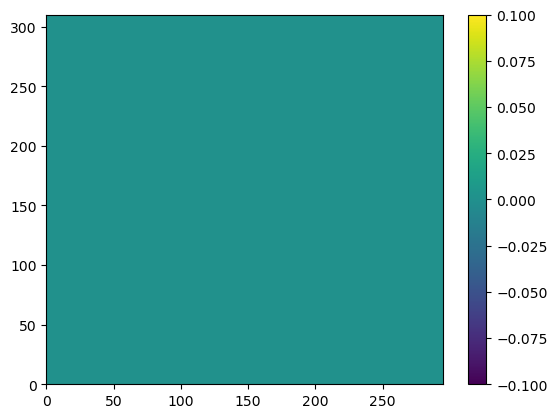

In [57]:
print('restore any min_wct which have been affected by new fast ice')
plt.pcolormesh(((hhh+zzz)<min_depth)*mmm)
plt.colorbar()
plt.show()

iii=(hhh+zzz)<min_depth
hhh[iii] = min_depth - zzz[iii]
plt.pcolormesh(((hhh+zzz)<min_depth)*mmm)
plt.colorbar()

and cap max depth


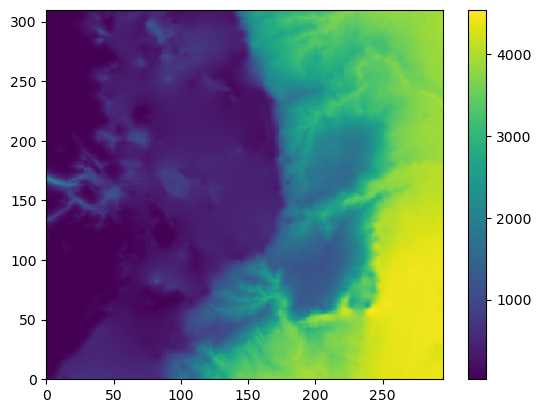

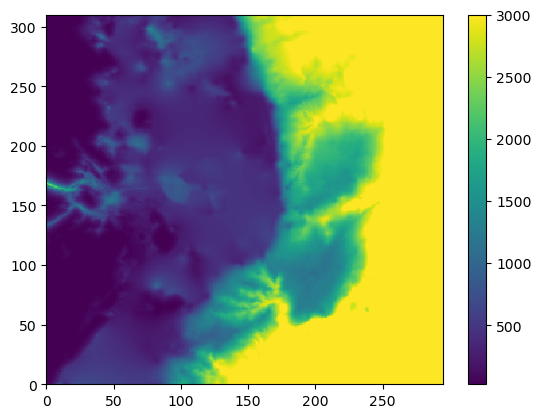

In [58]:
print('and cap max depth')
maxDepth=3000
iii=hhh>maxDepth
plt.figure()
plt.pcolormesh(hhh)
plt.colorbar()
plt.show()
hhh[iii] = maxDepth
plt.pcolormesh(hhh)
plt.colorbar()

In [59]:
# calculate final rx0 and rx1 values, check that you're happy before overwriting these
z_rho_final,z_w_final,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh,zzz)
grd_rx0_final=GridStiffness.rx0(hhh,mmm)

grd_rx1_final=GridStiffness.rx1(z_w_final,mmm)

maskNaN = mmm.copy().astype('float')
maskNaN[maskNaN == 0] = np.NaN

print('whole domain')
print('min/max zice is',zzz.min(),'/',zzz.max())
print('min/max h is',hhh.min(),'/',hhh.max())
print('min/max wct is',(hhh+zzz).min(),'/',(hhh+zzz).max())
print('ocean cells')
print('min/max zice is',np.nanmin(zzz*maskNaN),'/',np.nanmax(zzz*maskNaN))
print('min/max h is',np.nanmin(hhh*maskNaN),'/',np.nanmax(hhh*maskNaN))
print('min/max wct is',np.nanmin((hhh+zzz)*maskNaN),'/',np.nanmax((hhh+zzz)*maskNaN))


  
Minimum r-value =  0.0
Maximum r-value =  0.46199533343315125
Mean    r-value =  0.018150560321228075
Median  r-value =  0.006298657972365618
  
Minimum r-value =  0.0
Maximum r-value =  154.30531706752615
Mean    r-value =  4.315482643388551
Median  r-value =  0.8327954221139924
whole domain
min/max zice is -2505.46 / -0.0
min/max h is 25.0 / 3000.0
min/max wct is 25.0 / 3000.0
ocean cells
min/max zice is -1323.3829345703125 / -0.0
min/max h is 30.0 / 3000.0
min/max wct is 25.0 / 3000.0


In [60]:
# Make final versions
hhh_final = hhh.copy()
zzz_final = zzz.copy()
mmm_final = mmm.copy()

# now re-check that min_depth is obeyed for all ocean points
ii = ((hhh_final + zzz_final) < min_depth) & (mmm == 1)
hhh_final[ii] = -zzz_final[ii] + min_depth

# do the same for all non-ocean points
ii = ((hhh_final + zzz_final) < min_depth) & (mmm == 0)
zzz_final[ii] = min_depth-hhh_final[ii] # for those locations, the depth needs to be min_depth above the bathy

# remove any zice that is >0.
zzz_final_backup = zzz_final.copy()

anyPosZice=np.any(zzz_final>0)

if anyPosZice:
    new_ice = zzz_final.copy()
    new_ice[(zzz_final>0)]=0
    zzz_final=new_ice.copy()

In [61]:
maskNaN = mmm.copy().astype('float')
maskNaN[maskNaN == 0] = np.NaN

print('whole domain')
print('min/max zice is',zzz_final.min(),'/',zzz_final.max())
print('min/max h is',hhh_final.min(),'/',hhh_final.max())
print('min/max wct is',(hhh_final+zzz_final).min(),'/',(hhh_final+zzz_final).max())
print('ocean cells')
print('min/max zice is',np.nanmin(zzz_final*maskNaN),'/',np.nanmax(zzz_final*maskNaN))
print('min/max h is',np.nanmin(hhh_final*maskNaN),'/',np.nanmax(hhh_final*maskNaN))
print('min/max wct is',np.nanmin((hhh_final+zzz_final)*maskNaN),'/',np.nanmax((hhh_final+zzz_final)*maskNaN))

whole domain
min/max zice is -2505.46 / -0.0
min/max h is 25.0 / 3000.0
min/max wct is 25.0 / 3000.0
ocean cells
min/max zice is -1323.3829345703125 / -0.0
min/max h is 30.0 / 3000.0
min/max wct is 25.0 / 3000.0


In [62]:
# if this is set as 'True', then overwrite the bed, ice and mask with updated values.

handAdjustments=True
if handAdjustments:
    print('updating bathy, zice and mask')
    roms_tmp['bed_backup'] = roms_tmp['bed'].copy()
    roms_tmp['ice_backup'] = roms_tmp['ice'].copy()
    roms_tmp['mask_backup'] = roms_tmp['mask'].copy()
    roms_tmp['bed']=hhh_final.copy()
    roms_tmp['ice']=zzz_final.copy()
    roms_tmp['mask']=mmm_final.copy()
    
    bed = hhh_final.copy()
    ice = zzz_final.copy()
    mask = mmm_final.copy()


updating bathy, zice and mask


In [63]:
# do checks

maskNaN = mask.copy().astype('float')
maskNaN[maskNaN == 0] = np.NaN

print('whole domain')
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(bed+ice).min(),'/',(bed+ice).max())
print('ocean cells')
print('min/max zice is',np.nanmin(ice*maskNaN),'/',np.nanmax(ice*maskNaN))
print('min/max h is',np.nanmin(bed*maskNaN),'/',np.nanmax(bed*maskNaN))
print('min/max wct is',np.nanmin((bed+ice)*maskNaN),'/',np.nanmax((bed+ice)*maskNaN))

whole domain
min/max zice is -2505.46 / -0.0
min/max h is 25.0 / 3000.0
min/max wct is 25.0 / 3000.0
ocean cells
min/max zice is -1323.3829345703125 / -0.0
min/max h is 30.0 / 3000.0
min/max wct is 25.0 / 3000.0


In [64]:
mask = mask.astype(float)
mindxy = min(np.hstack((1/pm.flatten(),1/pn.flatten())))
maskNaN = mask.copy()
maskNaN[mask==0]=np.nan
CFL = mindxy/abs(np.sqrt(9.81*wct))*maskNaN

print('max fast DT in s following CFL with ROMS requiring a 0.85 tolerance: ', 0.85*np.nanmin(CFL))
print('max slow DT in s following CFL: ', 0.85*np.nanmin(mindxy/8*maskNaN)) # approx max 8m/s baroclinic wave speed
print('Set ROMS timestep settings of at least: \n','DT <',0.85*np.nanmin(mindxy/8*maskNaN),'s \n NDTFAST >',(np.nanmin(mindxy/8*maskNaN)/(0.85*np.nanmin(CFL))).round())
timescale = 12*60*60 #s
print('approximate viscosity settings for smoothing timescale of ',timescale/(60*60),' hrs')
print('visc2 for 2dx noise ~ ',(2*mindxy/(2*np.pi))**2 / timescale)
print('approximate diff settings are an order of magnitude lower:')
print('tnu2 ~ ',((2*mindxy/(2*np.pi))**2 / timescale/10))



max fast DT in s following CFL with ROMS requiring a 0.85 tolerance:  7.747432851791381
max slow DT in s following CFL:  204.52080260625965
Set ROMS timestep settings of at least: 
 DT < 204.52080260625965 s 
 NDTFAST > 31.0
approximate viscosity settings for smoothing timescale of  12.0  hrs
visc2 for 2dx noise ~  8.690276748210465
approximate diff settings are an order of magnitude lower:
tnu2 ~  0.8690276748210465


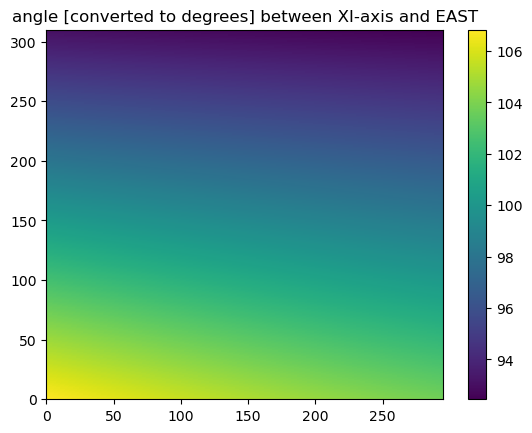

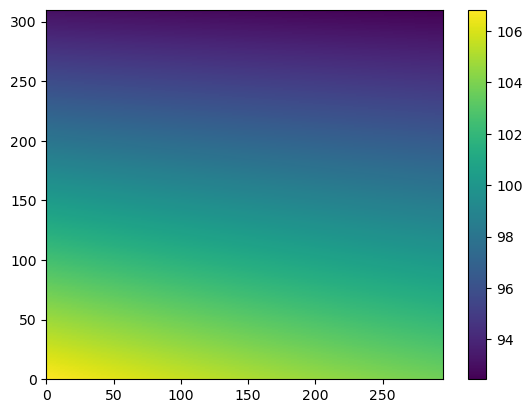

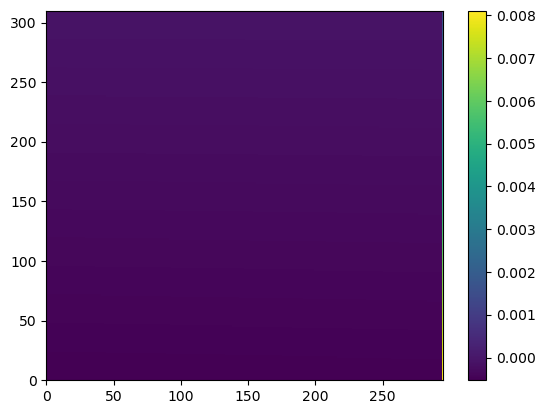

In [65]:
# Calculate the grid angle. !Important!

Angle_method = 'powell'

if Angle_method=='ole':
    angle = lon_rho/180.0*np.pi
    # ^^ only works for the polar stereographic grid of the Ole style WAOM model.
    # and note there is a slight error of a few fractions of a degree.
elif Angle_method == 'charles':
    # From Charles James GridBuilder:
    # note that the approximations within this method don't work so well
    # close to the poles. So best used near the low latitudes

    _,dxdxi = np.gradient(lon_rho)
    _,dydxi = np.gradient(lat_rho)

    angle = np.arctan2(dydxi,dxdxi)

elif Angle_method == 'powell':
    ### method from Brian Powell group

    def _distq(lon1, lat1, lon2, lat2):
        """
        Compute the geodesic distance between lat/lon points. This code is
        taken from the dist.f routine and the Matlab version distg.m passed
        around WHOI and APL. This was stripped down to use the WGS84 ellipsoid.

        Parameters
        ----------
        lon1 : array_like or scalar
            Input array of source longitude(s)
        lat1 : array_like or scalar
            Input array of source latitude(s)
        lon2 : array_like or scalar
            Input array of destination longitude(s)
        lat2 : array_like or scalar
            Input array of destination latitude(s)

        Returns
        -------
        distance : array or scalar of distance in meters
        angle: array or scalar of angle in radians

        """
        lon1 = np.asanyarray(np.radians(lon1))
        lat1 = np.asanyarray(np.radians(lat1))
        lon2 = np.asanyarray(np.radians(lon2))
        lat2 = np.asanyarray(np.radians(lat2))

        # # If one of the points is a singleton and the other is an
        # array, make them the same size
        if lon1.size == 1 and lon2.size > 1:
            lon1 = lon1.repeat(lon2.size)
            lat1 = lat1.repeat(lat2.size)
        if lon2.size == 1 and lon1.size > 1:
            lon2 = lon2.repeat(lon1.size)
            lat2 = lat2.repeat(lat1.size)

        # Set the WGS84 parameters
        A = 6378137.
        E = 0.081819191
        B = np.sqrt(A * A - (A * E)**2)
        EPS = E * E / (1.0 - E * E)

        # Move any latitudes off of the equator
        lat1[lat1 == 0] = np.finfo(float).eps
        lat2[lat2 == 0] = -np.finfo(float).eps

        # COMPUTE THE RADIUS OF CURVATURE IN THE PRIME VERTICAL FOR EACH POINT
        xnu1 = A / np.sqrt(1.0 - (E * np.sin(lat1))**2)
        xnu2 = A / np.sqrt(1.0 - (E * np.sin(lat2))**2)

        TPSI2 = (1.0 - E * E) * np.tan(lat2) + E * E * xnu1 * np.sin(lat1) / \
            (xnu2 * np.cos(lat2))
        PSI2 = np.arctan(TPSI2)

        DPHI2 = lat2 - PSI2
        DLAM = (lon2 - lon1) + np.finfo(float).eps
        CTA12 = np.sin(DLAM) / (np.cos(lat1) * TPSI2 - np.sin(lat1) * np.cos(DLAM))
        A12 = np.arctan(CTA12)
        CTA21P = np.sin(DLAM) / (np.sin(PSI2) * np.cos(DLAM) -
                                np.cos(PSI2) * np.tan(lat1))
        A21P = np.arctan(CTA21P)

        # C    GET THE QUADRANT RIGHT
        DLAM2 = (np.abs(DLAM) < np.pi).astype(int) * DLAM + \
            (DLAM >= np.pi).astype(int) * (-2 * np.pi + DLAM) + \
            (DLAM <= -np.pi).astype(int) * (2 * np.pi + DLAM)
        A12 = A12 + (A12 < -np.pi).astype(int) * 2 * np.pi - \
            (A12 >= np.pi).astype(int) * 2 * np.pi
        A12 = A12 + np.pi * np.sign(-A12) * \
            (np.sign(A12).astype(int) != np.sign(DLAM2))
        A21P = A21P + (A21P < -np.pi).astype(int) * 2 * np.pi - \
            (A21P >= np.pi).astype(int) * 2 * np.pi
        A21P = A21P + np.pi * np.sign(-A21P) * \
            (np.sign(A21P).astype(int) != np.sign(-DLAM2))

        SSIG = np.sin(DLAM) * np.cos(PSI2) / np.sin(A12)

        dd1 = np.array([np.cos(lon1) * np.cos(lat1),
                        np.sin(lon1) * np.cos(lat1), np.sin(lat1)])
        dd2 = np.array([np.cos(lon2) * np.cos(lat2),
                        np.sin(lon2) * np.cos(lat2), np.sin(lat2)])
        dd2 = np.sum((dd2 - dd1)**2, axis=0)
        bigbrnch = (dd2 > 2).astype(int)

        SIG = np.arcsin(SSIG) * (bigbrnch == 0).astype(int) + \
            (np.pi - np.arcsin(SSIG)) * bigbrnch

        SSIGC = -np.sin(DLAM) * np.cos(lat1) / np.sin(A21P)
        SIGC = np.arcsin(SSIGC)
        A21 = A21P - DPHI2 * np.sin(A21P) * np.tan(SIG / 2.0)

        # C   COMPUTE RANGE
        G2 = EPS * (np.sin(lat1))**2
        G = np.sqrt(G2)
        H2 = EPS * (np.cos(lat1) * np.cos(A12))**2
        H = np.sqrt(H2)
        SIG2 = SIG * SIG
        TERM1 = -H2 * (1.0 - H2) / 6.0
        TERM2 = G * H * (1.0 - 2.0 * H2) / 8.0
        TERM3 = (H2 * (4.0 - 7.0 * H2) - 3.0 * G2 * (1.0 - 7.0 * H2)) / 120.0
        TERM4 = -G * H / 48.0
        rng = xnu1 * SIG * (1.0 + SIG2 * (TERM1 + SIG * TERM2 + SIG2 * TERM3 +
                                        SIG2 * SIG * TERM4))

        return rng, A12


    def earth_angle(lon1, lat1, lon2, lat2):
        """
        Compute the angle between lat/lon points. NOTE: The bearing angle
        is computed, but then converted to geometric (counter-clockwise)
        angle to be returned.

        Parameters
        ----------
        lon1 : array_like or scalar
            Input array of source longitude(s)
        lat1 : array_like or scalar
            Input array of source latitude(s)
        lon2 : array_like or scalar
            Input array of destination longitude(s)
        lat2 : array_like or scalar
            Input array of destination latitude(s)

        Returns
        -------
        angle : array or scalar of bearing in radians

        """
        _, angle = _distq(lon1, lat1, lon2, lat2)
        return (np.pi / 2.0 - angle)


    # Calculate the angle between the points
    angle = np.zeros(lon_rho.shape)
    angle[:, :-1] = earth_angle(lon_rho[:, :-1],
                                        lat_rho[:, :-1], lon_rho[:, 1:], lat_rho[:, 1:])
    angle[:, -1] = angle[:, -2]
    angle[np.rad2deg(angle)>180] = angle[np.rad2deg(angle)>180] - np.deg2rad(360) # this last line was added
    # to make the angle variable stretch from -180 to 180, not -90 to 270.
    
    # i think this method is similar to that from the pyroms repo:
        # from  https://github.com/BobTorgerson/Pyroms/blob/master/pyroms/hgrid.py

                    # geod = pyproj.Geod(ellps=self.ellipse)
                    # az_forward, az_back, dx = geod.inv(self.lon[:,:-1], self.lat[:,:-1], \
                    #                                    self.lon[:,1:], self.lat[:,1:])

                    # angle = 0.5 * (az_forward[1:,:] + az_forward[:-1,:])
                    # self.angle_rho = (90 - angle) * np.pi/180.



plt.pcolormesh(np.rad2deg(angle))
plt.colorbar()
plt.title('angle [converted to degrees] between XI-axis and EAST')
plt.show()
plt.pcolormesh(np.rad2deg(lon_rho/180.0*np.pi))
plt.colorbar()
plt.show()
plt.pcolormesh(np.rad2deg(angle)-np.rad2deg(lon_rho/180.0*np.pi))
plt.colorbar()

In [66]:
#set spherical flag to 1, since we're creating a curvilinear spherical grid
spherical_da = xr.DataArray('"T"',name='spherical',attrs={'flag_meanings': 'Cartesian spherical',
 'flag_values': np.array(['"F"', '"T"'], dtype=str),
 'long_name': 'grid type logical switch'})

xl = np.maximum(dx[0,:].sum(), dx[-1,:].sum())
xl_da = xr.DataArray(xl,name='xl',attrs={'long_name': 'basin length in the XI-direction', 'units': 'meter'} )
el = np.maximum(dy[:,0].sum(), dy[:,-1].sum())
el_da = xr.DataArray(el,name='el',attrs={'long_name': 'basin length in the ETA-direction', 'units': 'meter'} )

angle_da = xr.DataArray(angle,name='angle',dims=['eta_rho','xi_rho'],attrs={'long_name': 'angle between XI-axis and EAST', 'units': 'radians'})

pn_da = xr.DataArray(pn,name="pn",dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in ETA', 'units': 'meter-1'})
pm_da = xr.DataArray(pm,name='pm',dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in XI', 'units': 'meter-1'})

dmde_da = xr.DataArray(dmde,name='dmde',dims=['eta_rho','xi_rho'],attrs={'long_name': 'ETA-derivative of inverse metric factor pm', 'units': 'meter'})
dndx_da = xr.DataArray(dndx,name='dndx',dims=['eta_rho','xi_rho'],attrs={'long_name': 'XI-derivative of inverse metric factor nm', 'units': 'meter'})

f = 2*7.29e-5*np.sin(lat_rho*np.pi/180)
f_da = xr.DataArray(f,name='f',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Coriolis parameter at RHO-points', 'units': 'second-1'})

h_da = xr.DataArray(bed,name='h',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model bathymetry at RHO-points', 'units': 'meter'})

zice_da = xr.DataArray(ice,name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model ice draft at RHO-points', 'units': 'meter'})

hraw_da = xr.DataArray(hraw.astype(float),name='hraw',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Working unmasked bathymetry at RHO-points', 'units': 'meter'})
ziceraw_da = xr.DataArray(ziceraw.astype(float),name='ziceraw',dims=['eta_rho','xi_rho'],attrs={'long_name': 'raw unmasked model ice draft at RHO-points', 'units': 'meter'})
mask_oceanraw_da = xr.DataArray(mask_oceanraw.astype(float),name='maskraw',dims=['eta_rho','xi_rho'],attrs={'long_name': 'raw unmasked model ocean mask at RHO-points'})

lon_rho_da = xr.DataArray(lon_rho,name='lon_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'longitude of RHO-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_rho_da = xr.DataArray(lat_rho,name='lat_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'latitude of RHO-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_psi_da = xr.DataArray(lon_psi,name='lon_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'longitude of psi-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_psi_da = xr.DataArray(lat_psi,name='lat_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'latitude of psi-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_u_da = xr.DataArray(lon_u,name='lon_u',dims=['eta_u','xi_u'],attrs={'long_name': 'longitude of u-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_u_da = xr.DataArray(lat_u,name='lat_u',dims=['eta_u','xi_u'],attrs={'long_name': 'latitude of u-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_v_da = xr.DataArray(lon_v,name='lon_v',dims=['eta_v','xi_v'],attrs={'long_name': 'longitude of v-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_v_da = xr.DataArray(lat_v,name='lat_v',dims=['eta_v','xi_v'],attrs={'long_name': 'latitude of v-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})

x_rho_da = xr.DataArray(x_rho,name='x_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'x-location of RHO-points, Easting, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection x-coordinate',
 'units': 'metre'})
y_rho_da = xr.DataArray(y_rho,name='y_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'y-location of RHO-points, Northing, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection y-coordinate',
 'units': 'metre'})
x_psi_da = xr.DataArray(x_psi,name='x_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'x-location of psi-points, Easting, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection x-coordinate',
 'units': 'metre'})
y_psi_da = xr.DataArray(y_psi,name='y_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'y-location of psi-points, Northing, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection y-coordinate',
 'units': 'metre'})
x_u_da = xr.DataArray(x_u,name='x_u',dims=['eta_u','xi_u'],attrs={'long_name': 'x-location of u-points, Easting, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection x-coordinate',
 'units': 'metre'})
y_u_da = xr.DataArray(y_u,name='y_u',dims=['eta_u','xi_u'],attrs={'long_name': 'y-location of u-points, Northing, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection y-coordinate',
 'units': 'metre'})
x_v_da = xr.DataArray(x_v,name='x_v',dims=['eta_v','xi_v'],attrs={'long_name': 'x-location of v-points, Easting, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection x-coordinate',
 'units': 'metre'})
y_v_da = xr.DataArray(y_v,name='y_v',dims=['eta_v','xi_v'],attrs={'long_name': 'y-location of v-points, Northing, EPSG:3031, Lat of origin=-71',
 'standard_name': 'projection y-coordinate',
 'units': 'metre'})


mask_u,mask_v,mask_psi = uvp_masks(mask)

mask_rho_da = xr.DataArray(mask,name='mask_rho',dims=['eta_rho','xi_rho'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on RHO-points'})
mask_psi_da = xr.DataArray(mask_psi,name='mask_psi',dims=['eta_psi','xi_psi'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on psi-points'})
mask_u_da = xr.DataArray(mask_u,name='mask_u',dims=['eta_u','xi_u'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on u-points'})
mask_v_da = xr.DataArray(mask_v,name='mask_v',dims=['eta_v','xi_v'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on v-points'})

grd = xr.Dataset({'spherical':spherical_da,
                'xl':xl_da,
                'el':el_da,
                'angle':angle_da,
                'pm':pm_da,
                'pn':pn_da,
                'dndx':dndx_da,
                'dmde':dmde_da,
                'f':f_da,
                'h':h_da,
                'zice':zice_da,
                'hraw':hraw_da,
                'ziceraw':ziceraw_da,
                'mask_oceanraw':mask_oceanraw_da,
                'lon_rho':lon_rho_da,
                'lat_rho':lat_rho_da,
                'lon_psi':lon_psi_da,
                'lat_psi':lat_psi_da,
                'lon_u':lon_u_da,
                'lat_u':lat_u_da,
                'lon_v':lon_v_da,
                'lat_v':lat_v_da,
                'x_rho':x_rho_da,
                'y_rho':y_rho_da,
                'x_psi':x_psi_da,
                'y_psi':y_psi_da,
                'x_u':x_u_da,
                'y_u':y_u_da,
                'x_v':x_v_da,
                'y_v':y_v_da,
                'mask_rho':mask_rho_da,
                'mask_psi':mask_psi_da,
                'mask_u':mask_u_da,
                'mask_v':mask_v_da,},
               attrs={'history': 'GRID file using make_grid.py,'+str(datetime.date.today()),
                      'type': 'ROMS grid file'})

In [71]:
print('saving to',out_path)
grd.to_netcdf(out_path,unlimited_dims='bath')

saving to /home/woden/Documents/shackleton-setup/data/proc/shackleton_2km_v3_grd.nc


In [68]:
print('grid shape for rho points (xi,eta) is ',grd.x_rho.T.shape)
print('so in ROMS, set this to:')
print('Lm is   ',grd.xi_rho.size-2)
print('Mm is   ',grd.eta_rho.size-2)

grid shape for rho points (xi,eta) is  (295, 310)
so in ROMS, set this to:
Lm is    293
Mm is    308


Text(0, 0.5, 'water column thickness [m]')

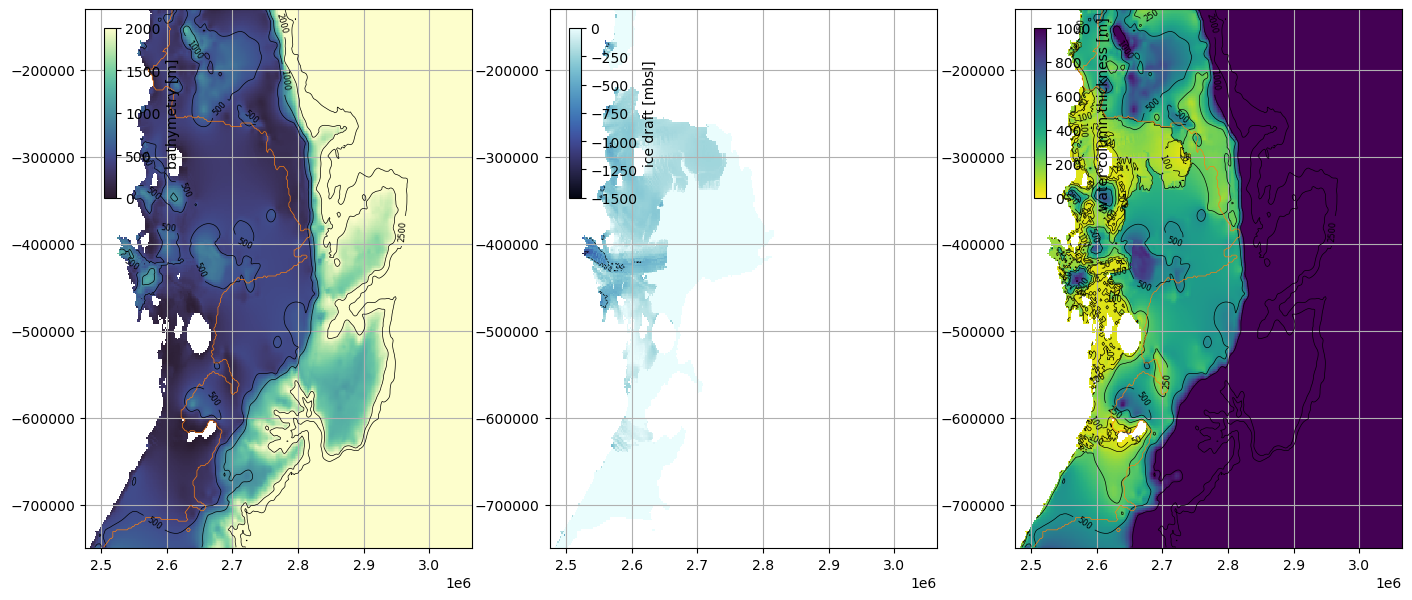

In [69]:
# plot of bathy and draft subset

nanMask = grd.mask_rho.where(grd.mask_rho!=0,np.NaN)
nanMaskZice = grd.mask_rho.where((grd.mask_rho!=0)&(grd.zice<0),np.NaN)

plt.close('all')
fig,axs=plt.subplots(ncols=3,figsize=(17,7))
im=axs[0].pcolormesh(grd.x_rho,grd.y_rho,(grd.h*nanMask),vmin=000,vmax=2000,cmap='cmo.deep_r')
co=axs[0].contour(grd.x_rho,grd.y_rho,(grd.h*nanMask),levels=[0,500,1000,2000,2500],colors='k',linewidths=0.5)
axs[0].contour(grd.x_rho,grd.y_rho,(grd.zice!=0 * nanMask),levels=[0,1],colors='C1',linewidths=0.5)
axs[2].clabel(co,fontsize=6)

axs[0].grid()
# axs[0].set_aspect('equal','box')
# colorbar
cax = inset_axes(axs[0],
                 width="3%",  # width = 10% of parent_bbox width
                 height="45%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.65, 1, .7),
                 bbox_transform=axs[0].transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)
cax.set_ylabel('bathymetry [m]')

im=axs[1].pcolormesh(grd.x_rho,grd.y_rho,grd.zice*nanMask*nanMaskZice,vmin=-1500,vmax=000,cmap='cmo.ice')
axs[1].contour(grd.x_rho,grd.y_rho,grd.zice*nanMask*nanMaskZice,levels=[-1500,-1000,-500,0],colors='k',linewidths=0.5)

axs[1].grid()

cax = inset_axes(axs[1],
                 width="3%",  # width = 10% of parent_bbox width
                 height="45%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.65, 1, .7),
                 bbox_transform=axs[1].transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)
cax.set_ylabel('ice draft [mbsl]')

im=axs[2].pcolormesh(grd.x_rho,grd.y_rho,((grd.h+grd.zice)*nanMask),vmin=000,vmax=1000,cmap='viridis_r')
# im=axs[2].pcolormesh(grd.x_rho,grd.y_rho,((grd.h+grd.zice)*nanMask),cmap='viridis_r',norm=mpl.colors.LogNorm(vmin=10,vmax=1000))
co=axs[2].contour(grd.x_rho,grd.y_rho,((grd.h+grd.zice)*nanMask),levels=[20,50,100,250,500,1000,2000,2500],colors='k',linewidths=0.5)
axs[2].contour(grd.x_rho,grd.y_rho,(grd.zice!=0 * nanMask),levels=[0,1],colors='C1',linewidths=0.5)
axs[2].clabel(co,fontsize=6)

axs[2].grid()
# axs[0].set_aspect('equal','box')
# colorbar
cax = inset_axes(axs[2],
                 width="3%",  # width = 10% of parent_bbox width
                 height="45%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.05,.65, 1, .7),
                 bbox_transform=axs[2].transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)
cax.set_ylabel('water column thickness [m]')
